<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: spec2, barshadow step

<span style="color:red"> **Instruments Affected**</span>: NIRSpec 

Tested on CV3 data

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Testing Data Set](#data_ID) <br> [Run the JWST pipeline and assign_wcs validation tests](#pipeline_ID): [FS Full-Frame test](#FULLFRAME), [FS ALLSLITS test](#ALLSLITS), [MOS test](#MOS) <br> [About This Notebook](#about_ID)<br> [Results](#results) <br>

</div>

<a id="imports_ID"></a>
# Imports
The library imports relevant to this notebook are aready taken care of by importing PTT.

* astropy.io for opening fits files
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot.plt to generate plot

NOTE: This notebook assumes that the pipeline version to be tested is already installed and its environment is activated.

To be able to run this notebook you need to install nptt. 

If all goes well you will be able to import PTT.

[Top of Page](#title_ID)

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
import shutil
import os
from tempfile import TemporaryDirectory

use_tempdir = True
if use_tempdir:
    # Create temporary directory
    data_dir = TemporaryDirectory()
    # Save original directory
    orig_dir = os.getcwd()
    # Move to new directory
    os.chdir(data_dir.name)

# For info, print out where the script is running
print("Running in {}".format(os.getcwd()))

Running in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_


In [2]:
# Choose CRDS cache location
use_local_crds_cache = False
crds_cache_tempdir = False
crds_cache_notebook_dir = True
crds_cache_home = False
crds_cache_custom_dir = False
crds_cache_dir_name = ""

if use_local_crds_cache:
    if crds_cache_tempdir:
        os.environ['CRDS_PATH'] = os.path.join(os.getcwd(), "crds")
    elif crds_cache_notebook_dir:
        try:
            os.environ['CRDS_PATH'] = os.path.join(orig_dir, "crds")
        except Exception as e:
            os.environ['CRDS_PATH'] = os.path.join(os.getcwd(), "crds")
    elif crds_cache_home:
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif crds_cache_custom_dir:
        os.environ['CRDS_PATH'] = crds_cache_dir_name

In [3]:
import warnings
import psutil
from astropy.io import fits

# Only print a DeprecationWarning the first time it shows up, not every time.
with warnings.catch_warnings():
    warnings.simplefilter("once", category=DeprecationWarning)
    import jwst
    from jwst.pipeline.calwebb_detector1 import Detector1Pipeline
    from jwst.assign_wcs.assign_wcs_step import AssignWcsStep
    from jwst.msaflagopen.msaflagopen_step import MSAFlagOpenStep
    from jwst.extract_2d.extract_2d_step import Extract2dStep
    from jwst.srctype.srctype_step import SourceTypeStep
    from jwst.wavecorr.wavecorr_step import WavecorrStep
    from jwst.flatfield.flat_field_step import FlatFieldStep
    from jwst.pathloss.pathloss_step import PathLossStep
    from jwst.barshadow import BarShadowStep
    from jwst import datamodels

# The latest version of NPTT is installed in the requirements text file at:
# /jwst_validation_notebooks/environment.yml

# import NPTT
import nirspec_pipe_testing_tool as nptt

# To get data from Artifactory
from ci_watson.artifactory_helpers import get_bigdata


In [4]:
# Print the versions used for the pipeline and NPTT

pipeline_version = jwst.__version__
nptt_version = nptt.__version__

print("Using jwst pipeline version: ", pipeline_version)
print("Using NPTT version: ", nptt_version)

Using jwst pipeline version:  1.3.1
Using NPTT version:  1.1.19


<a id="intro_ID"></a>
# Test Description

The NIRSpec team implemented code for the barshadow step and then compared the output with the the pipeline. The test is considered passed if the difference between the two outputs is smaller than 5%, the error provided by the IDT team (or 0.0025 in absolute numbers). 

For the test to be considered PASSED, every single MOS slitlet has to pass. If there is any failure, the whole test will be considered as FAILED. 

The code for this test can be obtained from: https://github.com/spacetelescope/nirspec_pipe_testing_tool/blob/master/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/barshadow_testing.py. 


Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/barshadow/description.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/barshadow


### Results

If the test **PASSED** this means that all slits, slitlets, or slices individually passed the test. However, if ony one individual MOS slitlet, the whole test will be reported as **FAILED**.


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/pages/viewpage.action?spaceKey=JWSTCC&title=Vanilla+MSA+Bar+Shadow+Correction


### Defining Term
Acronymns used un this notebook:

pipeline: calibration pipeline

spec2: spectroscopic calibration pipeline level 2b

PTT: NIRSpec pipeline testing tool (https://github.com/spacetelescope/nirspec_pipe_testing_tool)


[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
# Run the JWST pipeline and pathloss validation tests

The pipeline can be run from the command line in two variants: full or per step.

Tu run the spec2 pipeline in full use the command: 

$ strun jwst.pipeline.Spec2Pipeline jwtest_rate.fits

Tu only run the barshadow step, use the command:

$ strun jwst.barshadow.BarShadowStep jwtest_previous_step_output.fits


These options are also callable from a script with the testing environment active. The Python call for running the pipeline in full or by step are:

$\gt$ from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

$\gt$ Spec2Pipeline.call(jwtest_rate.fits)
 
or
 
$\gt$ from jwst.barshadow import BarShadowStep
 
$\gt$ BarShadowStep.call(jwtest_previous_step_output.fits)


PTT can run the spec2 pipeline either in full or per step, as well as the imaging pipeline in full. In this notebook we will use PTT to run the pipeline and the validation tests. To run PTT, follow the directions in the corresponding repo page.

[Top of Page](#title_ID)

<a id="data_ID"></a>
# Testing Data Set

All testing data is from the CV3 campaign. We chose these files because this is our most complete data set, i.e. all modes and filter-grating combinations.

Data used was for testing was only MOS:
- MOS_G140M_LINE1 
- MOS_PRISM


[Top of Page](#title_ID)

In [5]:
testing_data = {              
                'mos_prism_clear':{
                                  'uncal_file_nrs1': 'mos_prism_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'mos_prism_nrs2_uncal.fits',
                                  'msa_shutter_config': 'V0030006000104_msa.fits' },
                
                'mos_g140m_f100lp':{
                                  'uncal_file_nrs1': 'mos_g140m_line1_NRS1_uncal.fits',
                                  'uncal_file_nrs2': 'mos_g140m_line1_NRS2_uncal.fits',  
                                  'msa_shutter_config': 'V8460001000101_msa.fits' }
                }

In [6]:
# define function to pull data from Artifactory
def get_artifactory_file(data_set_dict, detector):
    """This function creates a list with all the files needed per detector to run the test.
    Args:
        data_set_dict: dictionary, contains inputs for a specific mode and configuration
        detector: string, either nrs1 or nrs2
    Returns:
        data: list, contains all files needed to run test
    """
    files2obtain = ['uncal_file_nrs1', 'msa_shutter_config']
    data = []
    for file in files2obtain:
        data_file = None
        try: 
            if '_nrs' in file and '2' in detector:
                file = file.replace('_nrs1', '_nrs2')

            data_file = get_bigdata('jwst_validation_notebooks',
                                         'validation_data',
                                         'nirspec_data', 
                                         data_set_dict[file])
        except TypeError:
            data.append(None)
            continue

        data.append(data_file)

    return data
    

Testing files for detector:  nrs1


Working with uncal_file:  /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_/mos_prism_nrs1_uncal.fits


2021-10-04 21:19:50,436 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_nirspec_pars-detector1pipeline_0004.asdf


2021-10-04 21:19:50,457 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-04 21:19:50,460 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-04 21:19:50,461 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-04 21:19:50,463 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-04 21:19:50,464 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-04 21:19:50,466 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-04 21:19:50,467 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-04 21:19:50,469 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-04 21:19:50,470 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-04 21:19:50,471 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-04 21:19:50,473 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-04 21:19:50,477 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-04 21:19:50,479 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-04 21:19:50,481 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-04 21:19:50,483 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-04 21:19:50,484 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-04 21:19:50,485 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-10-04 21:19:50,643 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_/mos_prism_nrs1_uncal.fits',).


2021-10-04 21:19:50,654 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outp

2021-10-04 21:19:50,814 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'mos_prism_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-04 21:19:50,831 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dark_0086.fits'.


2021-10-04 21:19:50,833 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits'.


2021-10-04 21:19:50,835 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_linearity_0018.fits'.


2021-10-04 21:19:50,837 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_mask_0010.fits'.


2021-10-04 21:19:50,839 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-04 21:19:50,840 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0018.fits'.


2021-10-04 21:19:50,843 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_refpix_0022.fits'.


2021-10-04 21:19:50,845 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-04 21:19:50,845 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2021-10-04 21:19:50,846 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_saturation_0020.fits'.


2021-10-04 21:19:50,849 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_superbias_0113.fits'.


2021-10-04 21:19:50,851 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-04 21:19:50,852 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-04 21:19:50,853 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-04 21:19:51,323 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).


2021-10-04 21:19:51,326 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:19:51,554 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2021-10-04 21:19:51,555 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-04 21:19:51,557 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-04 21:19:51,701 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).


2021-10-04 21:19:51,703 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:19:51,724 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nirspec_mask_0010.fits


2021-10-04 21:19:52,204 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-04 21:19:52,381 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).


2021-10-04 21:19:52,383 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:19:52,407 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nirspec_saturation_0020.fits


2021-10-04 21:19:53,257 - stpipe.Detector1Pipeline.saturation - INFO - Detected 9869 saturated pixels


2021-10-04 21:19:53,304 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-04 21:19:53,342 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-04 21:19:53,507 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).


2021-10-04 21:19:53,509 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:19:53,510 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-04 21:19:53,512 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-04 21:19:53,647 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).


2021-10-04 21:19:53,649 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:19:53,672 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_nirspec_superbias_0113.fits


/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stdatamodels/validate.py:34: ValidationWarning: While validating meta.exposure.readpatt the following error occurred:
'ALLIRS2' is not one of ['ACQ1', 'ACQ2', 'BRIGHT1', 'BRIGHT2', 'DEEP2', 'DEEP8', 'FAST', 'FASTGRPAVG', 'FASTGRPAVG8', 'FASTGRPAVG16', 'FASTGRPAVG32', 'FASTGRPAVG64', 'FASTR1', 'FASTR100', 'FGS', 'FGS60', 'FGS8370', 'FGS840', 'FGSRAPID', 'FINEGUIDE', 'ID', 'MEDIUM2', 'MEDIUM8', 'NIS', 'NISRAPID', 'NRS', 'NRSIRS2', 'NRSN16R4', 'NRSN32R8', 'NRSN8R2', 'NRSRAPID', 'NRSIRS2RAPID', 'NRSRAPIDD1', 'NRSRAPIDD2', 'NRSRAPIDD6', 'NRSSLOW', 'RAPID', 'SHALLOW2', 'SHALLOW4', 'SLOW', 'SLOWR1', 'TRACK', 'ANY', 'N/A']

Failed validating 'enum' in schema:
    OrderedDict([('title', 'Readout pattern'),
                 ('type', 'string'),
                 ('enum',
                  ['ACQ1',
                   'ACQ2',
                   'BRIGHT1',


2021-10-04 21:19:54,190 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2021-10-04 21:19:54,360 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).


2021-10-04 21:19:54,363 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-04 21:19:54,383 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /grp/crds/cache/references/jwst/jwst_nirspec_refpix_0022.fits


2021-10-04 21:20:07,917 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-04 21:20:08,276 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).


2021-10-04 21:20:08,278 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:20:08,300 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nirspec_linearity_0018.fits


2021-10-04 21:20:09,053 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-04 21:20:09,227 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).


2021-10-04 21:20:09,229 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_', 'dark_output': None}


2021-10-04 21:20:09,292 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_nirspec_dark_0086.fits


2021-10-04 21:20:13,366 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=4, nframes=1, groupgap=0


2021-10-04 21:20:13,367 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=65, nframes=1, groupgap=0


2021-10-04 21:20:13,948 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-04 21:20:14,537 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).


2021-10-04 21:20:14,540 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-04 21:20:14,568 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-04 21:20:14,599 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits


2021-10-04 21:20:14,701 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0018.fits


2021-10-04 21:20:14,753 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-04 21:20:15,014 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-04 21:20:15,168 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-04 21:20:16,923 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and at least four groups


2021-10-04 21:20:16,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 19712 pixels with at least one CR and three groups


2021-10-04 21:20:16,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 8617 pixels with at least one CR and two groups


2021-10-04 21:20:17,668 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.65283 sec


2021-10-04 21:20:17,672 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 3.103686


2021-10-04 21:20:17,676 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-04 21:20:17,827 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).


2021-10-04 21:20:17,829 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-04 21:20:17,902 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0018.fits


2021-10-04 21:20:17,954 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits


2021-10-04 21:20:17,999 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-04 21:20:18,000 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/ramp_fitting/ols_fit.py:1169: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


2021-10-04 21:20:31,680 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 4


2021-10-04 21:20:31,682 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2021-10-04 21:20:31,901 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-04 21:20:32,111 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 2048) from mos_prism_nrs1_uncal.fits>,).


2021-10-04 21:20:32,113 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:20:32,187 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-04 21:20:32,188 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-04 21:20:32,191 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-04 21:20:32,292 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from mos_prism_nrs1_uncal.fits>,).


2021-10-04 21:20:32,294 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:20:32,356 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-04 21:20:32,357 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-04 21:20:32,360 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-04 21:20:32,362 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-04 21:20:32,363 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-04 21:20:32,373 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-10-04 21:20:32,502 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from mos_prism_nrs1_uncal.fits>,).


2021-10-04 21:20:32,505 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-04 21:20:32,647 - stpipe.AssignWcsStep - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 1


2021-10-04 21:20:32,698 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.0332140289247036 deg


2021-10-04 21:20:32,700 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3367482721805573 deg


2021-10-04 21:20:32,701 - stpipe.AssignWcsStep - INFO - theta_y correction: -1.0907214098475986e-05 deg


2021-10-04 21:20:32,702 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2021-10-04 21:20:33,123 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS1: [3, 4]


2021-10-04 21:20:33,125 - stpipe.AssignWcsStep - INFO - Computing WCS for 2 open slitlets


2021-10-04 21:20:33,155 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.0332140289247036 deg


2021-10-04 21:20:33,156 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3367482721805573 deg


2021-10-04 21:20:33,157 - stpipe.AssignWcsStep - INFO - theta_y correction: -1.0907214098475986e-05 deg


2021-10-04 21:20:33,158 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2021-10-04 21:20:33,167 - stpipe.AssignWcsStep - INFO - SPORDER= 0, wrange=[6e-07, 5.3e-06]


2021-10-04 21:20:33,290 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 1


2021-10-04 21:20:33,291 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 2


2021-10-04 21:20:33,292 - stpipe.AssignWcsStep - INFO - There are 1 open slits in quadrant 3


2021-10-04 21:20:33,304 - stpipe.AssignWcsStep - INFO - There are 1 open slits in quadrant 4


2021-10-04 21:20:33,315 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 5


2021-10-04 21:20:33,502 - stpipe.AssignWcsStep - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf', 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf', 'disperser': '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0034.asdf', 'fore': '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0028.asdf', 'fpa': '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf', 'msa': '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf', 'ote': '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None, 'msametafile': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_/V0030006000104_msa.fits'}


2021-10-04 21:20:33,749 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2021-10-04 21:20:33,757 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2021-10-04 21:20:33,767 - stpipe.MSAFlagOpenStep - INFO - MSAFlagOpenStep instance created.


2021-10-04 21:20:33,887 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep running with args (<ImageModel(2048, 2048) from mos_prism_nrs1_uncal.fits>,).


2021-10-04 21:20:33,889 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-04 21:20:33,907 - stpipe.MSAFlagOpenStep - INFO - Using reference file /grp/crds/cache/references/jwst/jwst_nirspec_msaoper_0001.json


2021-10-04 21:20:33,909 - stpipe.JwstStep - INFO - JwstStep instance created.


2021-10-04 21:20:34,208 - stpipe.MSAFlagOpenStep - INFO - gwa_ytilt is 0.0332140289247036 deg


2021-10-04 21:20:34,209 - stpipe.MSAFlagOpenStep - INFO - gwa_xtilt is 0.3367482721805573 deg


2021-10-04 21:20:34,210 - stpipe.MSAFlagOpenStep - INFO - theta_y correction: -1.0907214098475986e-05 deg


2021-10-04 21:20:34,212 - stpipe.MSAFlagOpenStep - INFO - theta_x correction: 0.0 deg


2021-10-04 21:20:34,223 - stpipe.MSAFlagOpenStep - INFO - SPORDER= 0, wrange=[6e-07, 5.3e-06]


2021-10-04 21:20:34,348 - stpipe.MSAFlagOpenStep - INFO - There are 5 open slits in quadrant 1


2021-10-04 21:20:34,392 - stpipe.MSAFlagOpenStep - INFO - There are 3 open slits in quadrant 2


2021-10-04 21:20:34,420 - stpipe.MSAFlagOpenStep - INFO - There are 9 open slits in quadrant 3


2021-10-04 21:20:34,554 - stpipe.MSAFlagOpenStep - INFO - There are 3 open slits in quadrant 4


2021-10-04 21:20:34,582 - stpipe.MSAFlagOpenStep - INFO - There are 0 open slits in quadrant 5


/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)


2021-10-04 21:20:45,601 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep done


2021-10-04 21:20:45,612 - stpipe.Extract2dStep - INFO - Extract2dStep instance created.


2021-10-04 21:20:45,827 - stpipe.Extract2dStep - INFO - Step Extract2dStep running with args (<ImageModel(2048, 2048) from mos_prism_nrs1_uncal.fits>,).


2021-10-04 21:20:45,829 - stpipe.Extract2dStep - INFO - Step Extract2dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_name': None, 'extract_orders': None, 'tsgrism_extract_height': None, 'wfss_extract_half_height': 5, 'grism_objects': None, 'mmag_extract': 99.0}


2021-10-04 21:20:45,846 - stpipe.Extract2dStep - INFO - EXP_TYPE is NRS_MSASPEC


/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)
2021-10-04 21:20:46,067 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 3


2021-10-04 21:20:46,068 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1027 1464


2021-10-04 21:20:46,068 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1971 1983


2021-10-04 21:20:46,203 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:20:46,216 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.216281195 -45.702862740 156.216151591 -45.702738206 156.216089149 -45.702770462 156.216218751 -45.702894998


2021-10-04 21:20:46,218 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.216281195 -45.702862740 156.216151591 -45.702738206 156.216089149 -45.702770462 156.216218751 -45.702894998


2021-10-04 21:20:46,374 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 4


2021-10-04 21:20:46,375 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1275 1699


2021-10-04 21:20:46,376 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 32 43


2021-10-04 21:20:46,505 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:20:46,515 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.168120618 -45.657220874 156.167995139 -45.657100409 156.167933468 -45.657132147 156.168058946 -45.657252613


2021-10-04 21:20:46,516 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.168120618 -45.657220874 156.167995139 -45.657100409 156.167933468 -45.657132147 156.168058946 -45.657252613


2021-10-04 21:20:46,585 - stpipe.Extract2dStep - INFO - Step Extract2dStep done


2021-10-04 21:20:46,803 - stpipe.SourceTypeStep - INFO - SourceTypeStep instance created.


2021-10-04 21:20:46,940 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep running with args (<MultiSlitModel from mos_prism_nrs1_uncal.fits>,).


2021-10-04 21:20:46,942 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-04 21:20:46,950 - stpipe.SourceTypeStep - INFO - Input EXP_TYPE is NRS_MSASPEC


2021-10-04 21:20:46,952 - stpipe.SourceTypeStep - INFO - source_id=3, stellarity=100.0000, type=POINT


2021-10-04 21:20:46,953 - stpipe.SourceTypeStep - INFO - source_id=4, stellarity=100.0000, type=POINT


2021-10-04 21:20:46,955 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep done


2021-10-04 21:20:46,969 - stpipe.WavecorrStep - INFO - WavecorrStep instance created.


2021-10-04 21:20:47,067 - stpipe.WavecorrStep - INFO - Step WavecorrStep running with args (<MultiSlitModel from mos_prism_nrs1_uncal.fits>,).


2021-10-04 21:20:47,068 - stpipe.WavecorrStep - INFO - Step WavecorrStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-04 21:20:47,089 - stpipe.WavecorrStep - INFO - Using WAVECORR reference file /grp/crds/cache/references/jwst/jwst_nirspec_wavecorr_0002.asdf


2021-10-04 21:20:47,384 - stpipe.WavecorrStep - INFO - Detected a POINT source type in slit 3


2021-10-04 21:20:47,465 - stpipe.WavecorrStep - INFO - Using wavelength zero-point correction for aperture MOS


2021-10-04 21:20:47,468 - stpipe.WavecorrStep - INFO - Detected a POINT source type in slit 4


2021-10-04 21:20:47,522 - stpipe.WavecorrStep - INFO - Using wavelength zero-point correction for aperture MOS


2021-10-04 21:20:47,526 - stpipe.WavecorrStep - INFO - Step WavecorrStep done


2021-10-04 21:20:47,540 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.


2021-10-04 21:20:47,660 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<MultiSlitModel from mos_prism_nrs1_uncal.fits>,).


2021-10-04 21:20:47,663 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-04 21:21:47,897 - stpipe.FlatFieldStep - INFO - Working on slit 3


2021-10-04 21:21:48,571 - stpipe.FlatFieldStep - INFO - Working on slit 4


2021-10-04 21:21:49,284 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done


2021-10-04 21:21:49,298 - stpipe.PathLossStep - INFO - PathLossStep instance created.


2021-10-04 21:21:49,563 - stpipe.PathLossStep - INFO - Step PathLossStep running with args (<MultiSlitModel from mos_prism_nrs1_uncal.fits>,).


2021-10-04 21:21:49,565 - stpipe.PathLossStep - INFO - Step PathLossStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-04 21:21:49,589 - stpipe.PathLossStep - INFO - Using PATHLOSS reference file /grp/crds/cache/references/jwst/jwst_nirspec_pathloss_0002.fits


2021-10-04 21:21:49,741 - stpipe.PathLossStep - INFO - Input exposure type is NRS_MSASPEC


2021-10-04 21:21:50,049 - stpipe.PathLossStep - INFO - Working on slit 0


2021-10-04 21:21:50,064 - stpipe.PathLossStep - INFO - Working on slit 1


2021-10-04 21:21:50,081 - stpipe.PathLossStep - INFO - Step PathLossStep done


2021-10-04 21:21:50,095 - stpipe.BarShadowStep - INFO - BarShadowStep instance created.


2021-10-04 21:21:50,212 - stpipe.BarShadowStep - INFO - Step BarShadowStep running with args (<MultiSlitModel from mos_prism_nrs1_uncal.fits>,).


2021-10-04 21:21:50,214 - stpipe.BarShadowStep - INFO - Step BarShadowStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-04 21:21:50,236 - stpipe.BarShadowStep - INFO - Using BARSHADOW reference file /grp/crds/cache/references/jwst/jwst_nirspec_barshadow_0001.fits


2021-10-04 21:21:50,681 - stpipe.BarShadowStep - INFO - Working on slitlet 3


2021-10-04 21:21:50,692 - stpipe.BarShadowStep - INFO - Bar shadow correction skipped for slitlet 3 (source not uniform)


2021-10-04 21:21:50,697 - stpipe.BarShadowStep - INFO - Working on slitlet 4


2021-10-04 21:21:50,706 - stpipe.BarShadowStep - INFO - Bar shadow correction skipped for slitlet 4 (source not uniform)


2021-10-04 21:21:50,713 - stpipe.BarShadowStep - INFO - Step BarShadowStep done


Looping over open slitlets...
Working with slitlet  3
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Test for this slit is skipped since source is POINT and hence, the correction is not applied.

Working with slitlet  4
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Test for this slit is skipped since source is POINT and hence, the correction is not applied.


 * Test of barshadow_correction for slitlet 3  SKIPPED due to source=POINT. 
   Reported as PASSED since behavior is as expected.

 * Test of percentage_greater_3threshold for slitlet 3  SKIPPED due to source=POINT. 
   Reported as PASSED since behavior is as expected.

 * Test of percentage_greater_5threshold for slitlet 3  SKIPPED due to source=POINT. 
   Reported as PASSED since behavior is as expected.

 * Test of barshadow_correction for slitlet 4  SKIPPED due to source=POINT. 
   Reported as PASSED since behavior is as expected.

 * Test

Working with uncal_file:  /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_/mos_prism_nrs2_uncal.fits


2021-10-04 21:21:51,891 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_nirspec_pars-detector1pipeline_0004.asdf


2021-10-04 21:21:51,907 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-04 21:21:51,909 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-04 21:21:51,910 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-04 21:21:51,912 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-04 21:21:51,913 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-04 21:21:51,915 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-04 21:21:51,916 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-04 21:21:51,918 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-04 21:21:51,920 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-04 21:21:51,921 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-04 21:21:51,922 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-04 21:21:51,924 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-04 21:21:51,925 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-04 21:21:51,927 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-04 21:21:51,930 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-04 21:21:51,932 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-04 21:21:51,934 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:359: ResourceWarning: unclosed file <_io.FileIO name='/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_/mos_prism_nrs2_uncal.fits' mode='rb' closefd=True>
  gc.collect()
2021-10-04 21:21:52,074 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_/mos_prism_nrs2_uncal.fits',).


2021-10-04 21:21:52,084 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outp

2021-10-04 21:21:52,197 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'mos_prism_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-04 21:21:52,207 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dark_0087.fits'.


2021-10-04 21:21:52,210 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits'.


2021-10-04 21:21:52,212 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_linearity_0021.fits'.


2021-10-04 21:21:52,215 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_mask_0011.fits'.


2021-10-04 21:21:52,217 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-04 21:21:52,218 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0017.fits'.


2021-10-04 21:21:52,220 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_refpix_0020.fits'.


2021-10-04 21:21:52,222 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-04 21:21:52,223 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2021-10-04 21:21:52,223 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_saturation_0021.fits'.


2021-10-04 21:21:52,225 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_superbias_0114.fits'.


2021-10-04 21:21:52,227 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-04 21:21:52,228 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-04 21:21:52,229 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-04 21:21:52,529 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs2_uncal.fits>,).


2021-10-04 21:21:52,531 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:21:52,626 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2021-10-04 21:21:52,627 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-04 21:21:52,629 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-04 21:21:52,753 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs2_uncal.fits>,).


2021-10-04 21:21:52,756 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:21:52,775 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nirspec_mask_0011.fits


2021-10-04 21:21:53,134 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-04 21:21:53,261 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs2_uncal.fits>,).


2021-10-04 21:21:53,264 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:21:53,283 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nirspec_saturation_0021.fits


2021-10-04 21:21:53,833 - stpipe.Detector1Pipeline.saturation - INFO - Detected 5379 saturated pixels


2021-10-04 21:21:53,861 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-04 21:21:53,883 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-04 21:21:54,028 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs2_uncal.fits>,).


2021-10-04 21:21:54,030 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:21:54,031 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-04 21:21:54,033 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-04 21:21:54,151 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs2_uncal.fits>,).


2021-10-04 21:21:54,154 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:21:54,174 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_nirspec_superbias_0114.fits


/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stdatamodels/validate.py:34: ValidationWarning: While validating meta.exposure.readpatt the following error occurred:
'ALLIRS2' is not one of ['ACQ1', 'ACQ2', 'BRIGHT1', 'BRIGHT2', 'DEEP2', 'DEEP8', 'FAST', 'FASTGRPAVG', 'FASTGRPAVG8', 'FASTGRPAVG16', 'FASTGRPAVG32', 'FASTGRPAVG64', 'FASTR1', 'FASTR100', 'FGS', 'FGS60', 'FGS8370', 'FGS840', 'FGSRAPID', 'FINEGUIDE', 'ID', 'MEDIUM2', 'MEDIUM8', 'NIS', 'NISRAPID', 'NRS', 'NRSIRS2', 'NRSN16R4', 'NRSN32R8', 'NRSN8R2', 'NRSRAPID', 'NRSIRS2RAPID', 'NRSRAPIDD1', 'NRSRAPIDD2', 'NRSRAPIDD6', 'NRSSLOW', 'RAPID', 'SHALLOW2', 'SHALLOW4', 'SLOW', 'SLOWR1', 'TRACK', 'ANY', 'N/A']

Failed validating 'enum' in schema:
    OrderedDict([('title', 'Readout pattern'),
                 ('type', 'string'),
                 ('enum',
                  ['ACQ1',
                   'ACQ2',
                   'BRIGHT1',


2021-10-04 21:21:54,598 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2021-10-04 21:21:54,724 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs2_uncal.fits>,).


2021-10-04 21:21:54,726 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-04 21:21:54,747 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /grp/crds/cache/references/jwst/jwst_nirspec_refpix_0020.fits


2021-10-04 21:22:08,136 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-04 21:22:08,372 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs2_uncal.fits>,).


2021-10-04 21:22:08,375 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:22:08,395 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nirspec_linearity_0021.fits


2021-10-04 21:22:09,160 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-04 21:22:09,334 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs2_uncal.fits>,).


2021-10-04 21:22:09,335 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_', 'dark_output': None}


2021-10-04 21:22:09,395 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_nirspec_dark_0087.fits


2021-10-04 21:22:13,722 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=4, nframes=1, groupgap=0


2021-10-04 21:22:13,724 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=65, nframes=1, groupgap=0


2021-10-04 21:22:14,297 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-04 21:22:14,842 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs2_uncal.fits>,).


2021-10-04 21:22:14,844 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-04 21:22:14,878 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-04 21:22:14,926 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits


2021-10-04 21:22:15,035 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0017.fits


2021-10-04 21:22:15,077 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-04 21:22:15,333 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-04 21:22:15,485 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-04 21:22:17,180 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and at least four groups


2021-10-04 21:22:17,182 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 7787 pixels with at least one CR and three groups


2021-10-04 21:22:17,183 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3636 pixels with at least one CR and two groups


2021-10-04 21:22:17,563 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.22768 sec


2021-10-04 21:22:17,566 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 2.687949


2021-10-04 21:22:17,569 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-04 21:22:17,704 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs2_uncal.fits>,).


2021-10-04 21:22:17,707 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-04 21:22:17,797 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0017.fits


2021-10-04 21:22:17,839 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits


2021-10-04 21:22:17,884 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-04 21:22:17,886 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/ramp_fitting/ols_fit.py:1169: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


2021-10-04 21:22:31,002 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 4


2021-10-04 21:22:31,003 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2021-10-04 21:22:31,213 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-04 21:22:31,365 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 2048) from mos_prism_nrs2_uncal.fits>,).


2021-10-04 21:22:31,368 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:22:31,436 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-04 21:22:31,437 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-04 21:22:31,440 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-04 21:22:31,562 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from mos_prism_nrs2_uncal.fits>,).


2021-10-04 21:22:31,564 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:22:31,626 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-04 21:22:31,627 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-04 21:22:31,630 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-04 21:22:31,631 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-04 21:22:31,633 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-04 21:22:31,643 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-10-04 21:22:31,766 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from mos_prism_nrs2_uncal.fits>,).


2021-10-04 21:22:31,769 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-04 21:22:31,916 - stpipe.AssignWcsStep - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 1


2021-10-04 21:22:31,952 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.0332140289247036 deg


2021-10-04 21:22:31,953 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3367482721805573 deg


2021-10-04 21:22:31,955 - stpipe.AssignWcsStep - INFO - theta_y correction: -1.0907214098475986e-05 deg


2021-10-04 21:22:31,956 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2021-10-04 21:22:32,135 - stpipe.AssignWcsStep - INFO - Removing slit 3 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:22:32,174 - stpipe.AssignWcsStep - INFO - Removing slit 4 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:22:32,175 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS2: []


2021-10-04 21:22:32,175 - stpipe.AssignWcsStep - CRITICAL - No open slits fall on detector NRS2.


No open slits fall on detector  nrs2 

Did barshadow validation test passed?  skipped 


Testing files for detector:  nrs1


Working with uncal_file:  /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_/mos_g140m_line1_NRS1_uncal.fits


2021-10-04 21:22:33,883 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_nirspec_pars-detector1pipeline_0004.asdf


2021-10-04 21:22:33,900 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-04 21:22:33,901 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-04 21:22:33,903 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-04 21:22:33,904 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-04 21:22:33,906 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-04 21:22:33,907 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-04 21:22:33,908 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-04 21:22:33,910 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-04 21:22:33,911 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-04 21:22:33,912 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-04 21:22:33,914 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-04 21:22:33,915 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-04 21:22:33,916 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-04 21:22:33,918 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-04 21:22:33,919 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-04 21:22:33,920 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-04 21:22:33,922 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:359: ResourceWarning: unclosed file <_io.FileIO name='/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_/mos_g140m_line1_NRS1_uncal.fits' mode='rb' closefd=True>
  gc.collect()


2021-10-04 21:22:34,215 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_/mos_g140m_line1_NRS1_uncal.fits',).


2021-10-04 21:22:34,227 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outp

2021-10-04 21:22:34,365 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'mos_g140m_line1_NRS1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-04 21:22:34,381 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dark_0140.fits'.


2021-10-04 21:22:34,383 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits'.


2021-10-04 21:22:34,385 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_linearity_0019.fits'.


2021-10-04 21:22:34,387 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_mask_0024.fits'.


2021-10-04 21:22:34,389 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-04 21:22:34,389 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0019.fits'.


2021-10-04 21:22:34,391 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2021-10-04 21:22:34,391 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-04 21:22:34,392 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2021-10-04 21:22:34,392 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_saturation_0023.fits'.


2021-10-04 21:22:34,394 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_superbias_0087.fits'.


2021-10-04 21:22:34,396 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-04 21:22:34,396 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-04 21:22:34,397 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-04 21:22:34,910 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2021-10-04 21:22:34,912 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:22:35,046 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2021-10-04 21:22:35,047 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-04 21:22:35,049 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-04 21:22:35,348 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2021-10-04 21:22:35,351 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:22:35,372 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nirspec_mask_0024.fits


2021-10-04 21:22:35,746 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-04 21:22:36,050 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2021-10-04 21:22:36,053 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:22:36,078 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nirspec_saturation_0023.fits


2021-10-04 21:22:36,495 - stpipe.Detector1Pipeline.saturation - INFO - Detected 58922 saturated pixels


2021-10-04 21:22:36,520 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-04 21:22:36,528 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-04 21:22:36,680 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2021-10-04 21:22:36,682 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:22:36,683 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-04 21:22:36,685 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-04 21:22:36,800 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2021-10-04 21:22:36,802 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:22:36,822 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_nirspec_superbias_0087.fits


2021-10-04 21:22:37,067 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2021-10-04 21:22:37,194 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2021-10-04 21:22:37,196 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-04 21:22:37,204 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2021-10-04 21:22:37,205 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2021-10-04 21:22:37,206 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2021-10-04 21:22:37,207 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000


2021-10-04 21:22:37,208 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2021-10-04 21:22:39,836 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-04 21:22:39,961 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2021-10-04 21:22:39,963 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:22:39,982 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nirspec_linearity_0019.fits


2021-10-04 21:22:40,679 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-04 21:22:40,805 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2021-10-04 21:22:40,807 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_', 'dark_output': None}


2021-10-04 21:22:40,826 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_nirspec_dark_0140.fits


2021-10-04 21:22:41,073 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=6, nframes=1, groupgap=0


2021-10-04 21:22:41,075 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=10, nframes=1, groupgap=0


2021-10-04 21:22:41,290 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-04 21:22:41,415 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2021-10-04 21:22:41,417 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-04 21:22:41,425 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-04 21:22:41,437 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits


2021-10-04 21:22:41,492 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0019.fits


2021-10-04 21:22:41,535 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-04 21:22:41,717 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-04 21:22:41,924 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-04 21:22:43,853 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 39308 pixels with at least one CR and at least four groups


2021-10-04 21:22:43,857 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3301 pixels with at least one CR and three groups


2021-10-04 21:22:43,858 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 44253 pixels with at least one CR and two groups


2021-10-04 21:22:46,466 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 4.74815 sec


2021-10-04 21:22:46,471 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 5.045365


2021-10-04 21:22:46,474 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-04 21:22:46,646 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2021-10-04 21:22:46,648 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-04 21:22:46,678 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0019.fits


2021-10-04 21:22:46,724 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits


2021-10-04 21:22:46,774 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-04 21:22:46,775 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/ramp_fitting/ols_fit.py:1169: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


2021-10-04 21:23:12,384 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 6


2021-10-04 21:23:12,385 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2021-10-04 21:23:12,572 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-04 21:23:12,738 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2021-10-04 21:23:12,740 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:23:12,808 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-04 21:23:12,809 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-04 21:23:12,811 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-04 21:23:12,934 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2021-10-04 21:23:12,936 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:23:12,997 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-04 21:23:12,998 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-04 21:23:13,001 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-04 21:23:13,002 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-04 21:23:13,003 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-04 21:23:13,012 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-10-04 21:23:13,137 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2021-10-04 21:23:13,139 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-04 21:23:13,297 - stpipe.AssignWcsStep - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 1


2021-10-04 21:23:13,521 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1260581910610199 deg


2021-10-04 21:23:13,522 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3316612243652344 deg


2021-10-04 21:23:13,523 - stpipe.AssignWcsStep - INFO - theta_y correction: 0.0002496099796717191 deg


2021-10-04 21:23:13,524 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2021-10-04 21:23:13,706 - stpipe.AssignWcsStep - INFO - Removing slit 6 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:13,720 - stpipe.AssignWcsStep - INFO - Removing slit 7 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:13,733 - stpipe.AssignWcsStep - INFO - Removing slit 8 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:13,747 - stpipe.AssignWcsStep - INFO - Removing slit 9 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:13,760 - stpipe.AssignWcsStep - INFO - Removing slit 10 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:13,773 - stpipe.AssignWcsStep - INFO - Removing slit 11 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:13,786 - stpipe.AssignWcsStep - INFO - Removing slit 14 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:13,799 - stpipe.AssignWcsStep - INFO - Removing slit 15 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:13,812 - stpipe.AssignWcsStep - INFO - Removing slit 16 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:13,825 - stpipe.AssignWcsStep - INFO - Removing slit 17 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:13,838 - stpipe.AssignWcsStep - INFO - Removing slit 18 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:13,851 - stpipe.AssignWcsStep - INFO - Removing slit 19 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:13,865 - stpipe.AssignWcsStep - INFO - Removing slit 21 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:13,878 - stpipe.AssignWcsStep - INFO - Removing slit 25 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:13,891 - stpipe.AssignWcsStep - INFO - Removing slit 26 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:13,905 - stpipe.AssignWcsStep - INFO - Removing slit 27 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:13,918 - stpipe.AssignWcsStep - INFO - Removing slit 29 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:13,931 - stpipe.AssignWcsStep - INFO - Removing slit 31 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:13,944 - stpipe.AssignWcsStep - INFO - Removing slit 32 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:13,958 - stpipe.AssignWcsStep - INFO - Removing slit 33 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:13,971 - stpipe.AssignWcsStep - INFO - Removing slit 35 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:13,984 - stpipe.AssignWcsStep - INFO - Removing slit 37 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:13,997 - stpipe.AssignWcsStep - INFO - Removing slit 38 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:14,010 - stpipe.AssignWcsStep - INFO - Removing slit 39 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:14,023 - stpipe.AssignWcsStep - INFO - Removing slit 41 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:14,060 - stpipe.AssignWcsStep - INFO - Removing slit 1 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:14,073 - stpipe.AssignWcsStep - INFO - Removing slit 2 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:14,086 - stpipe.AssignWcsStep - INFO - Removing slit 3 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:14,099 - stpipe.AssignWcsStep - INFO - Removing slit 4 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:14,113 - stpipe.AssignWcsStep - INFO - Removing slit 5 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:14,126 - stpipe.AssignWcsStep - INFO - Removing slit 12 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:14,139 - stpipe.AssignWcsStep - INFO - Removing slit 13 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:14,152 - stpipe.AssignWcsStep - INFO - Removing slit 20 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:14,165 - stpipe.AssignWcsStep - INFO - Removing slit 22 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:14,178 - stpipe.AssignWcsStep - INFO - Removing slit 23 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:14,201 - stpipe.AssignWcsStep - INFO - Removing slit 24 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:14,217 - stpipe.AssignWcsStep - INFO - Removing slit 28 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:14,230 - stpipe.AssignWcsStep - INFO - Removing slit 30 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:14,243 - stpipe.AssignWcsStep - INFO - Removing slit 34 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:14,256 - stpipe.AssignWcsStep - INFO - Removing slit 36 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:14,269 - stpipe.AssignWcsStep - INFO - Removing slit 40 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:23:14,563 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS1: [42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]


2021-10-04 21:23:14,564 - stpipe.AssignWcsStep - INFO - Computing WCS for 27 open slitlets


2021-10-04 21:23:14,591 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1260581910610199 deg


2021-10-04 21:23:14,592 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3316612243652344 deg


2021-10-04 21:23:14,592 - stpipe.AssignWcsStep - INFO - theta_y correction: 0.0002496099796717191 deg


2021-10-04 21:23:14,594 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2021-10-04 21:23:14,603 - stpipe.AssignWcsStep - INFO - SPORDER= -1, wrange=[9.7e-07, 1.89e-06]


2021-10-04 21:23:14,720 - stpipe.AssignWcsStep - INFO - There are 2 open slits in quadrant 1


2021-10-04 21:23:14,739 - stpipe.AssignWcsStep - INFO - There are 11 open slits in quadrant 2


2021-10-04 21:23:14,831 - stpipe.AssignWcsStep - INFO - There are 4 open slits in quadrant 3


2021-10-04 21:23:14,866 - stpipe.AssignWcsStep - INFO - There are 10 open slits in quadrant 4


2021-10-04 21:23:15,097 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 5


2021-10-04 21:23:15,231 - stpipe.AssignWcsStep - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf', 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf', 'disperser': '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0032.asdf', 'fore': '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0023.asdf', 'fpa': '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf', 'msa': '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf', 'ote': '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None, 'msametafile': 'V8460001000101_msa.fits'}


2021-10-04 21:23:15,678 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2021-10-04 21:23:15,685 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2021-10-04 21:23:15,694 - stpipe.MSAFlagOpenStep - INFO - MSAFlagOpenStep instance created.


2021-10-04 21:23:15,857 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep running with args (<ImageModel(2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2021-10-04 21:23:15,859 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-04 21:23:15,876 - stpipe.MSAFlagOpenStep - INFO - Using reference file /grp/crds/cache/references/jwst/jwst_nirspec_msaoper_0001.json


2021-10-04 21:23:15,877 - stpipe.JwstStep - INFO - JwstStep instance created.


2021-10-04 21:23:15,998 - stpipe.MSAFlagOpenStep - INFO - gwa_ytilt is 0.1260581910610199 deg


2021-10-04 21:23:15,999 - stpipe.MSAFlagOpenStep - INFO - gwa_xtilt is 0.3316612243652344 deg


2021-10-04 21:23:16,000 - stpipe.MSAFlagOpenStep - INFO - theta_y correction: 0.0002496099796717191 deg


2021-10-04 21:23:16,001 - stpipe.MSAFlagOpenStep - INFO - theta_x correction: 0.0 deg


2021-10-04 21:23:16,011 - stpipe.MSAFlagOpenStep - INFO - SPORDER= -1, wrange=[9.7e-07, 1.89e-06]


2021-10-04 21:23:16,141 - stpipe.MSAFlagOpenStep - INFO - There are 5 open slits in quadrant 1


2021-10-04 21:23:16,183 - stpipe.MSAFlagOpenStep - INFO - There are 3 open slits in quadrant 2


2021-10-04 21:23:16,210 - stpipe.MSAFlagOpenStep - INFO - There are 9 open slits in quadrant 3


2021-10-04 21:23:16,284 - stpipe.MSAFlagOpenStep - INFO - There are 3 open slits in quadrant 4


2021-10-04 21:23:16,309 - stpipe.MSAFlagOpenStep - INFO - There are 0 open slits in quadrant 5


/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)


2021-10-04 21:23:27,881 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep done


2021-10-04 21:23:27,893 - stpipe.Extract2dStep - INFO - Extract2dStep instance created.


2021-10-04 21:23:28,192 - stpipe.Extract2dStep - INFO - Step Extract2dStep running with args (<ImageModel(2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).


2021-10-04 21:23:28,195 - stpipe.Extract2dStep - INFO - Step Extract2dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_name': None, 'extract_orders': None, 'tsgrism_extract_height': None, 'wfss_extract_half_height': 5, 'grism_objects': None, 'mmag_extract': 99.0}


2021-10-04 21:23:28,220 - stpipe.Extract2dStep - INFO - EXP_TYPE is NRS_MSASPEC


/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)
2021-10-04 21:23:28,706 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 53


2021-10-04 21:23:28,707 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1542 2048


2021-10-04 21:23:28,708 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1315 1329


2021-10-04 21:23:28,836 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:28,847 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.226123221 -45.673642180 156.225994086 -45.673519691 156.225931834 -45.673551545 156.226060967 -45.673674035


2021-10-04 21:23:28,848 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.226123221 -45.673642180 156.225994086 -45.673519691 156.225931834 -45.673551545 156.226060967 -45.673674035


2021-10-04 21:23:29,500 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 54


2021-10-04 21:23:29,502 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1542 2048


2021-10-04 21:23:29,502 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1305 1319


2021-10-04 21:23:29,629 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:29,639 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.225872406 -45.673404272 156.225743296 -45.673281804 156.225681049 -45.673313656 156.225810156 -45.673436124


2021-10-04 21:23:29,640 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.225872406 -45.673404272 156.225743296 -45.673281804 156.225681049 -45.673313656 156.225810156 -45.673436124


2021-10-04 21:23:30,297 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 42


2021-10-04 21:23:30,298 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 2018 2048


2021-10-04 21:23:30,299 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 545 562


2021-10-04 21:23:30,422 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:30,433 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.223646010 -45.647128995 156.223518121 -45.647008321 156.223456024 -45.647039957 156.223583911 -45.647160632


2021-10-04 21:23:30,434 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.223646010 -45.647128995 156.223518121 -45.647008321 156.223456024 -45.647039957 156.223583911 -45.647160632


2021-10-04 21:23:31,097 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 43


2021-10-04 21:23:31,098 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1970 2048


2021-10-04 21:23:31,099 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 414 430


2021-10-04 21:23:31,224 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:31,234 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.218966486 -45.644829601 156.218838959 -45.644709141 156.218776943 -45.644740759 156.218904467 -45.644861220


2021-10-04 21:23:31,235 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.218966486 -45.644829601 156.218838959 -45.644709141 156.218776943 -45.644740759 156.218904467 -45.644861220


2021-10-04 21:23:31,695 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 44


2021-10-04 21:23:31,696 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1969 2048


2021-10-04 21:23:31,696 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 404 420


2021-10-04 21:23:31,821 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:31,831 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.218718991 -45.644595818 156.218591488 -45.644475376 156.218529475 -45.644506992 156.218656977 -45.644627436


2021-10-04 21:23:31,832 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.218718991 -45.644595818 156.218591488 -45.644475376 156.218529475 -45.644506992 156.218656977 -45.644627436


2021-10-04 21:23:32,518 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 45


2021-10-04 21:23:32,519 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1908 2048


2021-10-04 21:23:32,520 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 530 546


2021-10-04 21:23:32,642 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:32,653 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.219673020 -45.648613077 156.219545303 -45.648492383 156.219483265 -45.648524021 156.219610979 -45.648644716


2021-10-04 21:23:32,654 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.219673020 -45.648613077 156.219545303 -45.648492383 156.219483265 -45.648524021 156.219610979 -45.648644716


2021-10-04 21:23:33,340 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 46


2021-10-04 21:23:33,341 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1882 2048


2021-10-04 21:23:33,342 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 202 218


2021-10-04 21:23:33,467 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:33,477 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.211127421 -45.641279813 156.211000463 -45.641159678 156.210938572 -45.641191268 156.211065527 -45.641311404


2021-10-04 21:23:33,479 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.211127421 -45.641279813 156.211000463 -45.641159678 156.210938572 -45.641191268 156.211065527 -45.641311404


2021-10-04 21:23:33,943 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 47


2021-10-04 21:23:33,944 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1815 2048


2021-10-04 21:23:33,945 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 566 581


2021-10-04 21:23:34,069 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:34,079 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.217456055 -45.651006881 156.217328370 -45.650886079 156.217266356 -45.650917729 156.217394038 -45.651038531


2021-10-04 21:23:34,080 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.217456055 -45.651006881 156.217328370 -45.650886079 156.217266356 -45.650917729 156.217394038 -45.651038531


2021-10-04 21:23:34,798 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 48


2021-10-04 21:23:34,799 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1815 2048


2021-10-04 21:23:34,799 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 561 576


2021-10-04 21:23:34,925 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:34,934 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.217332149 -45.650889654 156.217204477 -45.650768862 156.217142464 -45.650800511 156.217270135 -45.650921304


2021-10-04 21:23:34,936 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.217332149 -45.650889654 156.217204477 -45.650768862 156.217142464 -45.650800511 156.217270135 -45.650921304


2021-10-04 21:23:35,638 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 49


2021-10-04 21:23:35,639 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1791 2048


2021-10-04 21:23:35,639 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 631 646


2021-10-04 21:23:35,766 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:35,776 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.218210913 -45.652969013 156.218083107 -45.652848076 156.218021073 -45.652879740 156.218148877 -45.653000678


2021-10-04 21:23:35,777 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.218210913 -45.652969013 156.218083107 -45.652848076 156.218021073 -45.652879740 156.218148877 -45.653000678


2021-10-04 21:23:36,242 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 50


2021-10-04 21:23:36,243 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1774 2048


2021-10-04 21:23:36,244 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 238 253


2021-10-04 21:23:36,370 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:36,381 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.208399869 -45.643929179 156.208272959 -45.643808942 156.208211096 -45.643840541 156.208338005 -45.643960778


2021-10-04 21:23:36,382 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.208399869 -45.643929179 156.208272959 -45.643808942 156.208211096 -45.643840541 156.208338005 -45.643960778


2021-10-04 21:23:37,116 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 51


2021-10-04 21:23:37,117 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1759 2048


2021-10-04 21:23:37,118 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 430 445


2021-10-04 21:23:37,246 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:37,256 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.212403238 -45.648718689 156.212275928 -45.648598111 156.212213993 -45.648629742 156.212341301 -45.648750320


2021-10-04 21:23:37,257 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.212403238 -45.648718689 156.212275928 -45.648598111 156.212213993 -45.648629742 156.212341301 -45.648750320


2021-10-04 21:23:37,976 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 52


2021-10-04 21:23:37,978 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1722 2048


2021-10-04 21:23:37,979 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 803 817


2021-10-04 21:23:38,101 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:38,112 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.219947139 -45.658234585 156.219819020 -45.658113276 156.219756938 -45.658144979 156.219885055 -45.658266289


2021-10-04 21:23:38,114 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.219947139 -45.658234585 156.219819020 -45.658113276 156.219756938 -45.658144979 156.219885055 -45.658266289


2021-10-04 21:23:38,580 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 55


2021-10-04 21:23:38,581 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1022 2048


2021-10-04 21:23:38,582 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1415 1430


2021-10-04 21:23:38,711 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:38,722 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.211226719 -45.684941334 156.211098073 -45.684818233 156.211035880 -45.684850241 156.211164524 -45.684973343


2021-10-04 21:23:38,724 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.211226719 -45.684941334 156.211098073 -45.684818233 156.211035880 -45.684850241 156.211164524 -45.684973343


2021-10-04 21:23:39,464 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 65


2021-10-04 21:23:39,466 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 427 1893


2021-10-04 21:23:39,467 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1251 1273


2021-10-04 21:23:39,609 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:39,618 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.187669449 -45.691221095 156.187541886 -45.691097893 156.187479754 -45.691130071 156.187607315 -45.691253274


2021-10-04 21:23:39,620 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.187669449 -45.691221095 156.187541886 -45.691097893 156.187479754 -45.691130071 156.187607315 -45.691253274


2021-10-04 21:23:40,086 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 66


2021-10-04 21:23:40,087 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 426 1892


2021-10-04 21:23:40,088 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1452 1474


2021-10-04 21:23:40,230 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:40,239 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.192290190 -45.696194513 156.192162195 -45.696070854 156.192099979 -45.696103094 156.192227972 -45.696226755


2021-10-04 21:23:40,242 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.192290190 -45.696194513 156.192162195 -45.696070854 156.192099979 -45.696103094 156.192227972 -45.696226755


2021-10-04 21:23:40,983 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 68


2021-10-04 21:23:40,989 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 375 1842


2021-10-04 21:23:40,990 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1476 1499


2021-10-04 21:23:41,134 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:41,143 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.191192483 -45.697686513 156.191064493 -45.697562756 156.191002259 -45.697595026 156.191130247 -45.697718784


2021-10-04 21:23:41,144 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.191192483 -45.697686513 156.191064493 -45.697562756 156.191002259 -45.697595026 156.191130247 -45.697718784


2021-10-04 21:23:41,602 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 56


2021-10-04 21:23:41,604 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 872 2048


2021-10-04 21:23:41,605 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 768 783


2021-10-04 21:23:41,743 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:41,754 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.191122501 -45.671742959 156.190995485 -45.671621176 156.190933579 -45.671653049 156.191060593 -45.671774833


2021-10-04 21:23:41,755 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.191122501 -45.671742959 156.190995485 -45.671621176 156.190933579 -45.671653049 156.191060593 -45.671774833


2021-10-04 21:23:42,512 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 57


2021-10-04 21:23:42,514 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 805 2048


2021-10-04 21:23:42,515 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 354 370


2021-10-04 21:23:42,646 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:42,656 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.179343124 -45.662963603 156.179216994 -45.662842617 156.179155236 -45.662874401 156.179281365 -45.662995389


2021-10-04 21:23:42,658 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.179343124 -45.662963603 156.179216994 -45.662842617 156.179155236 -45.662874401 156.179281365 -45.662995389


2021-10-04 21:23:43,173 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 58


2021-10-04 21:23:43,175 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 731 2048


2021-10-04 21:23:43,176 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 258 274


2021-10-04 21:23:43,308 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:43,319 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.174716949 -45.661919476 156.174591057 -45.661798624 156.174529324 -45.661830406 156.174655215 -45.661951259


2021-10-04 21:23:43,321 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.174716949 -45.661919476 156.174591057 -45.661798624 156.174529324 -45.661830406 156.174655215 -45.661951259


2021-10-04 21:23:44,094 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 59


2021-10-04 21:23:44,095 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 658 2048


2021-10-04 21:23:44,097 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 71 88


2021-10-04 21:23:44,231 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:44,242 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.167987333 -45.658726530 156.167861814 -45.658605973 156.167800128 -45.658637729 156.167925645 -45.658758288


2021-10-04 21:23:44,244 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.167987333 -45.658726530 156.167861814 -45.658605973 156.167800128 -45.658637729 156.167925645 -45.658758288


2021-10-04 21:23:44,702 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 60


2021-10-04 21:23:44,704 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 641 2048


2021-10-04 21:23:44,705 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 681 699


2021-10-04 21:23:45,148 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:45,159 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.181507045 -45.673611447 156.181380443 -45.673489678 156.181318559 -45.673521602 156.181445158 -45.673643373


2021-10-04 21:23:45,161 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.181507045 -45.673611447 156.181380443 -45.673489678 156.181318559 -45.673521602 156.181445158 -45.673643373


2021-10-04 21:23:45,625 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 61


2021-10-04 21:23:45,627 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 620 2048


2021-10-04 21:23:45,628 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 822 840


2021-10-04 21:23:45,764 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:45,774 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.184095390 -45.677365774 156.183968526 -45.677243686 156.183906587 -45.677275659 156.184033450 -45.677397747


2021-10-04 21:23:45,776 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.184095390 -45.677365774 156.183968526 -45.677243686 156.183906587 -45.677275659 156.184033450 -45.677397747


2021-10-04 21:23:46,232 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 62


2021-10-04 21:23:46,233 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 570 2032


2021-10-04 21:23:46,234 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 510 528


2021-10-04 21:23:46,681 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:46,692 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.175200333 -45.670700849 156.175074128 -45.670579384 156.175012293 -45.670611285 156.175138497 -45.670732752


2021-10-04 21:23:46,693 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.175200333 -45.670700849 156.175074128 -45.670579384 156.175012293 -45.670611285 156.175138497 -45.670732752


2021-10-04 21:23:47,155 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 63


2021-10-04 21:23:47,157 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 454 1915


2021-10-04 21:23:47,158 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 181 200


2021-10-04 21:23:47,294 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:47,307 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.163846800 -45.664818400 156.163721256 -45.664697497 156.163659498 -45.664729348 156.163785040 -45.664850252


2021-10-04 21:23:47,308 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.163846800 -45.664818400 156.163721256 -45.664697497 156.163659498 -45.664729348 156.163785040 -45.664850252


2021-10-04 21:23:47,760 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 64


2021-10-04 21:23:47,761 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 454 1915


2021-10-04 21:23:47,762 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 176 195


2021-10-04 21:23:48,230 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:48,243 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.163724974 -45.664701077 156.163599439 -45.664580184 156.163537682 -45.664612033 156.163663216 -45.664732928


2021-10-04 21:23:48,244 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.163724974 -45.664701077 156.163599439 -45.664580184 156.163537682 -45.664612033 156.163663216 -45.664732928


2021-10-04 21:23:48,725 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 67


2021-10-04 21:23:48,727 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 328 1789


2021-10-04 21:23:48,728 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 130 150


2021-10-04 21:23:48,869 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:23:48,878 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.158533940 -45.665758025 156.158408563 -45.665637125 156.158346784 -45.665669007 156.158472159 -45.665789909


2021-10-04 21:23:48,880 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.158533940 -45.665758025 156.158408563 -45.665637125 156.158346784 -45.665669007 156.158472159 -45.665789909


2021-10-04 21:23:50,144 - stpipe.Extract2dStep - INFO - Step Extract2dStep done


2021-10-04 21:23:52,691 - stpipe.SourceTypeStep - INFO - SourceTypeStep instance created.


2021-10-04 21:23:53,027 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep running with args (<MultiSlitModel from mos_g140m_line1_NRS1_uncal.fits>,).


2021-10-04 21:23:53,029 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-04 21:23:53,037 - stpipe.SourceTypeStep - INFO - Input EXP_TYPE is NRS_MSASPEC


2021-10-04 21:23:53,039 - stpipe.SourceTypeStep - INFO - source_id=53, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,041 - stpipe.SourceTypeStep - INFO - source_id=54, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,043 - stpipe.SourceTypeStep - INFO - source_id=42, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,044 - stpipe.SourceTypeStep - INFO - source_id=43, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,046 - stpipe.SourceTypeStep - INFO - source_id=44, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,048 - stpipe.SourceTypeStep - INFO - source_id=45, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,050 - stpipe.SourceTypeStep - INFO - source_id=46, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,052 - stpipe.SourceTypeStep - INFO - source_id=47, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,056 - stpipe.SourceTypeStep - INFO - source_id=48, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,058 - stpipe.SourceTypeStep - INFO - source_id=49, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,059 - stpipe.SourceTypeStep - INFO - source_id=50, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,061 - stpipe.SourceTypeStep - INFO - source_id=51, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,062 - stpipe.SourceTypeStep - INFO - source_id=52, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,063 - stpipe.SourceTypeStep - INFO - source_id=55, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,064 - stpipe.SourceTypeStep - INFO - source_id=65, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,066 - stpipe.SourceTypeStep - INFO - source_id=66, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,067 - stpipe.SourceTypeStep - INFO - source_id=68, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,068 - stpipe.SourceTypeStep - INFO - source_id=56, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,069 - stpipe.SourceTypeStep - INFO - source_id=57, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,071 - stpipe.SourceTypeStep - INFO - source_id=58, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,072 - stpipe.SourceTypeStep - INFO - source_id=59, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,074 - stpipe.SourceTypeStep - INFO - source_id=60, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,074 - stpipe.SourceTypeStep - INFO - source_id=61, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,075 - stpipe.SourceTypeStep - INFO - source_id=62, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,076 - stpipe.SourceTypeStep - INFO - source_id=63, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,077 - stpipe.SourceTypeStep - INFO - source_id=64, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,080 - stpipe.SourceTypeStep - INFO - source_id=67, stellarity=0.0000, type=EXTENDED


2021-10-04 21:23:53,082 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep done


2021-10-04 21:23:53,148 - stpipe.WavecorrStep - INFO - WavecorrStep instance created.


2021-10-04 21:23:53,431 - stpipe.WavecorrStep - INFO - Step WavecorrStep running with args (<MultiSlitModel from mos_g140m_line1_NRS1_uncal.fits>,).


2021-10-04 21:23:53,433 - stpipe.WavecorrStep - INFO - Step WavecorrStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-04 21:23:53,502 - stpipe.WavecorrStep - INFO - Using WAVECORR reference file /grp/crds/cache/references/jwst/jwst_nirspec_wavecorr_0002.asdf


2021-10-04 21:23:57,699 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 53


2021-10-04 21:23:57,700 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 54


2021-10-04 21:23:57,701 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 42


2021-10-04 21:23:57,703 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 43


2021-10-04 21:23:57,704 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 44


2021-10-04 21:23:57,705 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 45


2021-10-04 21:23:57,706 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 46


2021-10-04 21:23:57,707 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 47


2021-10-04 21:23:57,708 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 48


2021-10-04 21:23:57,708 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 49


2021-10-04 21:23:57,709 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 50


2021-10-04 21:23:57,710 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 51


2021-10-04 21:23:57,710 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 52


2021-10-04 21:23:57,711 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 55


2021-10-04 21:23:57,712 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 65


2021-10-04 21:23:57,712 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 66


2021-10-04 21:23:57,713 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 68


2021-10-04 21:23:57,713 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 56


2021-10-04 21:23:57,714 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 57


2021-10-04 21:23:57,716 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 58


2021-10-04 21:23:57,717 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 59


2021-10-04 21:23:57,717 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 60


2021-10-04 21:23:57,718 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 61


2021-10-04 21:23:57,718 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 62


2021-10-04 21:23:57,719 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 63


2021-10-04 21:23:57,719 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 64


2021-10-04 21:23:57,720 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 67


2021-10-04 21:23:57,725 - stpipe.WavecorrStep - INFO - Step WavecorrStep done


2021-10-04 21:23:57,779 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.


2021-10-04 21:23:58,301 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<MultiSlitModel from mos_g140m_line1_NRS1_uncal.fits>,).


2021-10-04 21:23:58,304 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-04 21:24:40,201 - stpipe.FlatFieldStep - INFO - Working on slit 53


2021-10-04 21:24:40,971 - stpipe.FlatFieldStep - INFO - Working on slit 54


2021-10-04 21:24:41,729 - stpipe.FlatFieldStep - INFO - Working on slit 42


2021-10-04 21:24:41,866 - stpipe.FlatFieldStep - INFO - Working on slit 43


2021-10-04 21:24:42,069 - stpipe.FlatFieldStep - INFO - Working on slit 44


2021-10-04 21:24:42,270 - stpipe.FlatFieldStep - INFO - Working on slit 45


2021-10-04 21:24:42,555 - stpipe.FlatFieldStep - INFO - Working on slit 46


2021-10-04 21:24:42,910 - stpipe.FlatFieldStep - INFO - Working on slit 47


2021-10-04 21:24:43,311 - stpipe.FlatFieldStep - INFO - Working on slit 48


2021-10-04 21:24:43,707 - stpipe.FlatFieldStep - INFO - Working on slit 49


2021-10-04 21:24:44,148 - stpipe.FlatFieldStep - INFO - Working on slit 50


2021-10-04 21:24:44,605 - stpipe.FlatFieldStep - INFO - Working on slit 51


2021-10-04 21:24:45,078 - stpipe.FlatFieldStep - INFO - Working on slit 52


2021-10-04 21:24:45,590 - stpipe.FlatFieldStep - INFO - Working on slit 55


2021-10-04 21:24:47,019 - stpipe.FlatFieldStep - INFO - Working on slit 65


2021-10-04 21:24:49,100 - stpipe.FlatFieldStep - INFO - Working on slit 66


2021-10-04 21:24:51,208 - stpipe.FlatFieldStep - INFO - Working on slit 68


2021-10-04 21:24:53,294 - stpipe.FlatFieldStep - INFO - Working on slit 56


2021-10-04 21:24:54,985 - stpipe.FlatFieldStep - INFO - Working on slit 57


2021-10-04 21:24:57,715 - stpipe.FlatFieldStep - INFO - Working on slit 58


2021-10-04 21:24:59,596 - stpipe.FlatFieldStep - INFO - Working on slit 59


2021-10-04 21:25:01,571 - stpipe.FlatFieldStep - INFO - Working on slit 60


2021-10-04 21:25:03,550 - stpipe.FlatFieldStep - INFO - Working on slit 61


2021-10-04 21:25:05,534 - stpipe.FlatFieldStep - INFO - Working on slit 62


2021-10-04 21:25:07,592 - stpipe.FlatFieldStep - INFO - Working on slit 63


2021-10-04 21:25:09,670 - stpipe.FlatFieldStep - INFO - Working on slit 64


2021-10-04 21:25:11,740 - stpipe.FlatFieldStep - INFO - Working on slit 67


2021-10-04 21:25:14,803 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done


2021-10-04 21:25:14,862 - stpipe.PathLossStep - INFO - PathLossStep instance created.


2021-10-04 21:25:16,268 - stpipe.PathLossStep - INFO - Step PathLossStep running with args (<MultiSlitModel from mos_g140m_line1_NRS1_uncal.fits>,).


2021-10-04 21:25:16,274 - stpipe.PathLossStep - INFO - Step PathLossStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-04 21:25:16,348 - stpipe.PathLossStep - INFO - Using PATHLOSS reference file /grp/crds/cache/references/jwst/jwst_nirspec_pathloss_0002.fits


2021-10-04 21:25:16,396 - stpipe.PathLossStep - INFO - Input exposure type is NRS_MSASPEC


2021-10-04 21:25:22,386 - stpipe.PathLossStep - INFO - Working on slit 0


2021-10-04 21:25:22,404 - stpipe.PathLossStep - INFO - Working on slit 1


2021-10-04 21:25:22,422 - stpipe.PathLossStep - INFO - Working on slit 2


2021-10-04 21:25:22,437 - stpipe.PathLossStep - INFO - Working on slit 3


2021-10-04 21:25:22,452 - stpipe.PathLossStep - INFO - Working on slit 4


2021-10-04 21:25:22,469 - stpipe.PathLossStep - INFO - Working on slit 5


2021-10-04 21:25:22,484 - stpipe.PathLossStep - INFO - Working on slit 6


2021-10-04 21:25:22,498 - stpipe.PathLossStep - INFO - Working on slit 7


2021-10-04 21:25:22,515 - stpipe.PathLossStep - INFO - Working on slit 8


2021-10-04 21:25:22,530 - stpipe.PathLossStep - INFO - Working on slit 9


2021-10-04 21:25:22,545 - stpipe.PathLossStep - INFO - Working on slit 10


2021-10-04 21:25:22,562 - stpipe.PathLossStep - INFO - Working on slit 11


2021-10-04 21:25:22,577 - stpipe.PathLossStep - INFO - Working on slit 12


2021-10-04 21:25:22,592 - stpipe.PathLossStep - INFO - Working on slit 13


2021-10-04 21:25:22,610 - stpipe.PathLossStep - INFO - Working on slit 14


2021-10-04 21:25:22,627 - stpipe.PathLossStep - INFO - Working on slit 15


2021-10-04 21:25:22,644 - stpipe.PathLossStep - INFO - Working on slit 16


2021-10-04 21:25:22,665 - stpipe.PathLossStep - INFO - Working on slit 17


2021-10-04 21:25:22,682 - stpipe.PathLossStep - INFO - Working on slit 18


2021-10-04 21:25:22,699 - stpipe.PathLossStep - INFO - Working on slit 19


2021-10-04 21:25:22,716 - stpipe.PathLossStep - INFO - Working on slit 20


2021-10-04 21:25:22,735 - stpipe.PathLossStep - INFO - Working on slit 21


2021-10-04 21:25:22,752 - stpipe.PathLossStep - INFO - Working on slit 22


2021-10-04 21:25:22,769 - stpipe.PathLossStep - INFO - Working on slit 23


2021-10-04 21:25:22,787 - stpipe.PathLossStep - INFO - Working on slit 24


2021-10-04 21:25:22,806 - stpipe.PathLossStep - INFO - Working on slit 25


2021-10-04 21:25:22,824 - stpipe.PathLossStep - INFO - Working on slit 26


2021-10-04 21:25:22,844 - stpipe.PathLossStep - INFO - Step PathLossStep done


2021-10-04 21:25:22,904 - stpipe.BarShadowStep - INFO - BarShadowStep instance created.


2021-10-04 21:25:23,950 - stpipe.BarShadowStep - INFO - Step BarShadowStep running with args (<MultiSlitModel from mos_g140m_line1_NRS1_uncal.fits>,).


2021-10-04 21:25:23,952 - stpipe.BarShadowStep - INFO - Step BarShadowStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-04 21:25:24,023 - stpipe.BarShadowStep - INFO - Using BARSHADOW reference file /grp/crds/cache/references/jwst/jwst_nirspec_barshadow_0001.fits


2021-10-04 21:25:29,185 - stpipe.BarShadowStep - INFO - Working on slitlet 53


2021-10-04 21:25:29,235 - stpipe.BarShadowStep - INFO - Working on slitlet 54


2021-10-04 21:25:29,284 - stpipe.BarShadowStep - INFO - Working on slitlet 42


2021-10-04 21:25:29,308 - stpipe.BarShadowStep - INFO - Working on slitlet 43


2021-10-04 21:25:29,335 - stpipe.BarShadowStep - INFO - Working on slitlet 44


2021-10-04 21:25:29,363 - stpipe.BarShadowStep - INFO - Working on slitlet 45


2021-10-04 21:25:29,393 - stpipe.BarShadowStep - INFO - Working on slitlet 46


2021-10-04 21:25:30,658 - stpipe.BarShadowStep - INFO - Working on slitlet 47


2021-10-04 21:25:30,696 - stpipe.BarShadowStep - INFO - Working on slitlet 48


2021-10-04 21:25:30,733 - stpipe.BarShadowStep - INFO - Working on slitlet 49


2021-10-04 21:25:30,771 - stpipe.BarShadowStep - INFO - Working on slitlet 50


2021-10-04 21:25:30,808 - stpipe.BarShadowStep - INFO - Working on slitlet 51


2021-10-04 21:25:30,846 - stpipe.BarShadowStep - INFO - Working on slitlet 52


2021-10-04 21:25:30,887 - stpipe.BarShadowStep - INFO - Working on slitlet 55


2021-10-04 21:25:30,965 - stpipe.BarShadowStep - INFO - Working on slitlet 65


2021-10-04 21:25:31,118 - stpipe.BarShadowStep - INFO - Working on slitlet 66


2021-10-04 21:25:31,250 - stpipe.BarShadowStep - INFO - Working on slitlet 68


2021-10-04 21:25:31,385 - stpipe.BarShadowStep - INFO - Working on slitlet 56


2021-10-04 21:25:31,478 - stpipe.BarShadowStep - INFO - Working on slitlet 57


2021-10-04 21:25:31,575 - stpipe.BarShadowStep - INFO - Working on slitlet 58


2021-10-04 21:25:31,673 - stpipe.BarShadowStep - INFO - Working on slitlet 59


2021-10-04 21:25:31,799 - stpipe.BarShadowStep - INFO - Working on slitlet 60


2021-10-04 21:25:31,915 - stpipe.BarShadowStep - INFO - Working on slitlet 61


2021-10-04 21:25:32,027 - stpipe.BarShadowStep - INFO - Working on slitlet 62


2021-10-04 21:25:32,137 - stpipe.BarShadowStep - INFO - Working on slitlet 63


2021-10-04 21:25:32,255 - stpipe.BarShadowStep - INFO - Working on slitlet 64


2021-10-04 21:25:32,371 - stpipe.BarShadowStep - INFO - Working on slitlet 67


2021-10-04 21:25:32,502 - stpipe.BarShadowStep - INFO - Step BarShadowStep done


/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Looping over open slitlets...
Working with slitlet  53
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations/5.3_BarShadow/referenceFilesBS-20160401/jwst-nirspec-mos1x1.bsrf.fits


Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


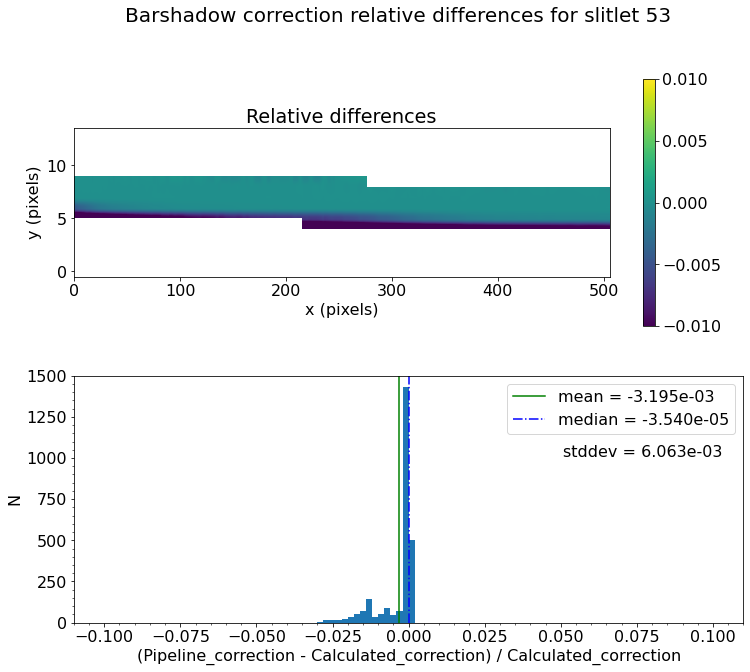


   Relative barshadow_correction  :   mean = -3.195e-03    median = -3.540e-05    stdev = 6.063e-03
    Maximum   Relativebarshadow_correction = 5.761e-04
    Minimum   Relativebarshadow_correction = -2.816e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 13%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 53? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  54
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Referenc

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


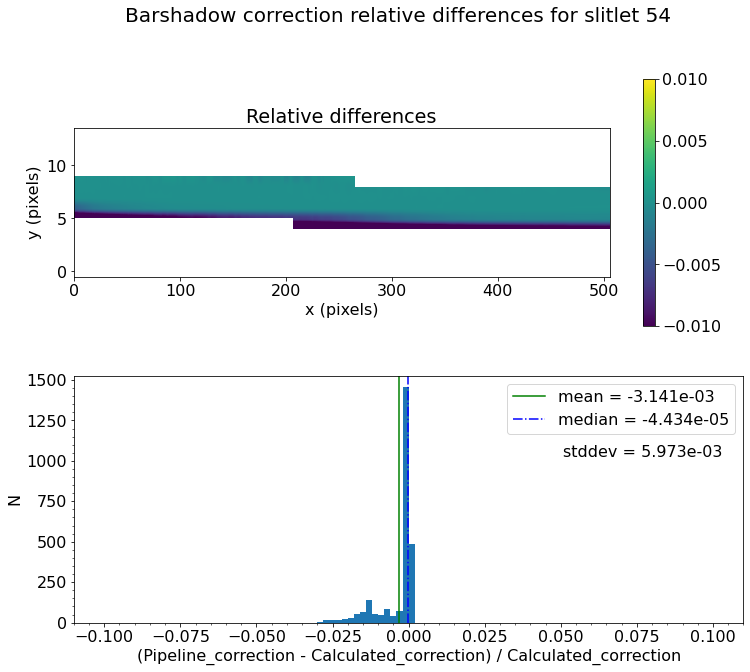


   Relative barshadow_correction  :   mean = -3.141e-03    median = -4.434e-05    stdev = 5.973e-03
    Maximum   Relativebarshadow_correction = 4.518e-04
    Minimum   Relativebarshadow_correction = -2.811e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 12%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 54? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  42
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Referenc

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


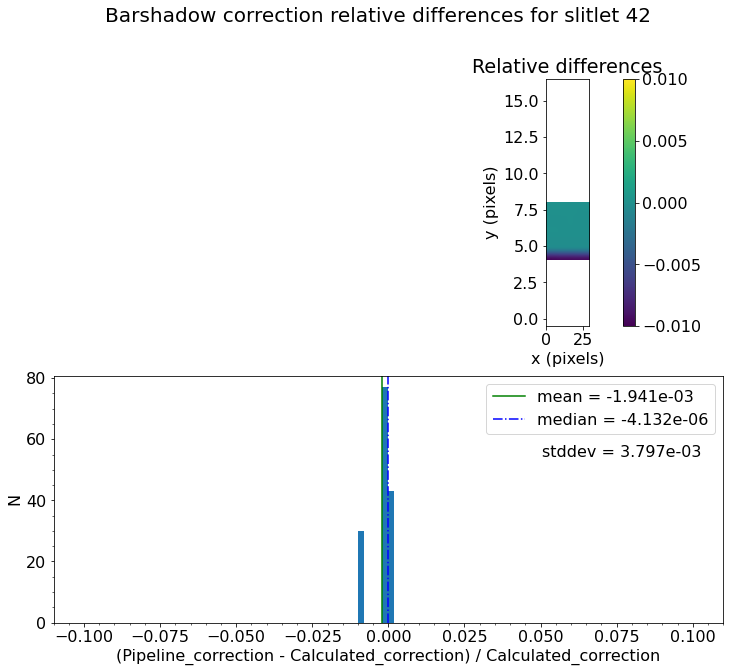


   Relative barshadow_correction  :   mean = -1.941e-03    median = -4.132e-06    stdev = 3.797e-03
    Maximum   Relativebarshadow_correction = 1.723e-04
    Minimum   Relativebarshadow_correction = -9.762e-03
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 20%
                            ->  3xtheshold = 20%
                            ->  5xtheshold = 0%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 42? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  43
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


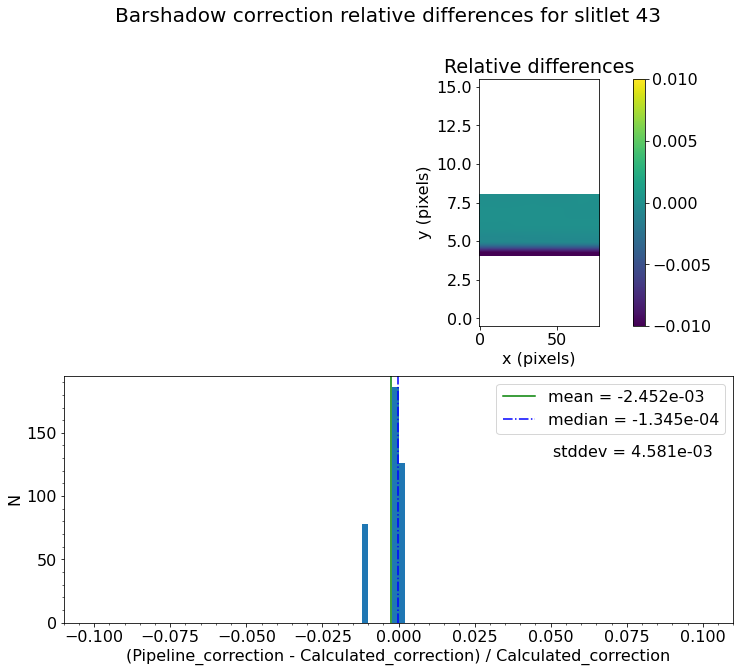


   Relative barshadow_correction  :   mean = -2.452e-03    median = -1.345e-04    stdev = 4.581e-03
    Maximum   Relativebarshadow_correction = 2.783e-05
    Minimum   Relativebarshadow_correction = -1.190e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 20%
                            ->  3xtheshold = 20%
                            ->  5xtheshold = 0%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 43? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  44
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


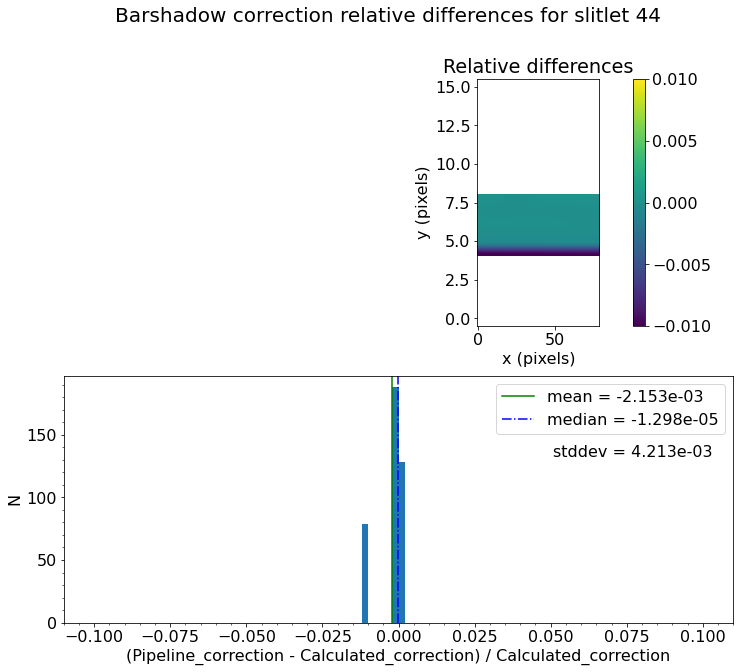


   Relative barshadow_correction  :   mean = -2.153e-03    median = -1.298e-05    stdev = 4.213e-03
    Maximum   Relativebarshadow_correction = 3.550e-04
    Minimum   Relativebarshadow_correction = -1.099e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 20%
                            ->  3xtheshold = 20%
                            ->  5xtheshold = 0%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 44? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  45
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


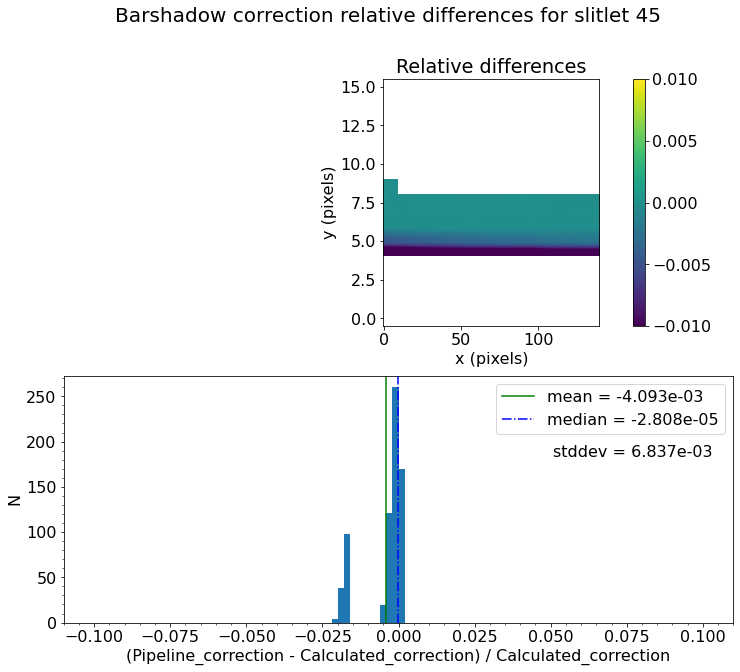


   Relative barshadow_correction  :   mean = -4.093e-03    median = -2.808e-05    stdev = 6.837e-03
    Maximum   Relativebarshadow_correction = 2.014e-04
    Minimum   Relativebarshadow_correction = -2.027e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 34%
                            ->  3xtheshold = 20%
                            ->  5xtheshold = 20%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 45? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  46
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.


/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations/5.3_BarShadow/referenceFilesBS-20160401/jwst-nirspec-mos1x1.bsrf.fits


Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


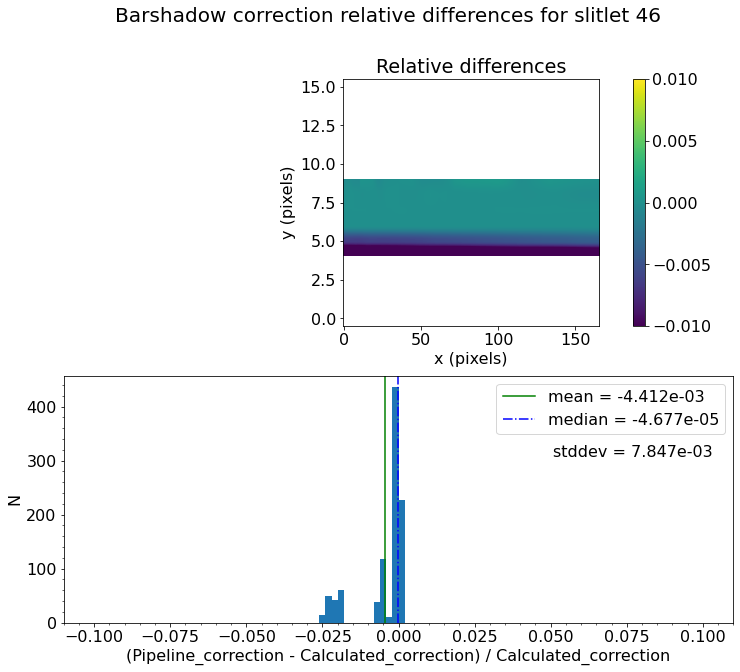


   Relative barshadow_correction  :   mean = -4.412e-03    median = -4.677e-05    stdev = 7.847e-03
    Maximum   Relativebarshadow_correction = 8.356e-04
    Minimum   Relativebarshadow_correction = -2.599e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 33%
                            ->  3xtheshold = 17%
                            ->  5xtheshold = 17%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 46? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  47
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Referenc

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


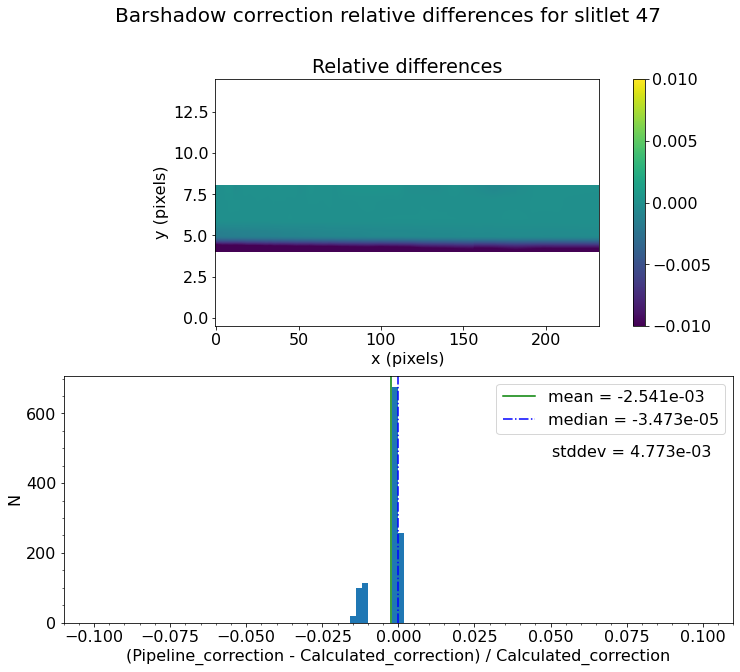


   Relative barshadow_correction  :   mean = -2.541e-03    median = -3.473e-05    stdev = 4.773e-03
    Maximum   Relativebarshadow_correction = 3.042e-04
    Minimum   Relativebarshadow_correction = -1.535e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 20%
                            ->  3xtheshold = 20%
                            ->  5xtheshold = 6%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 47? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  48
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


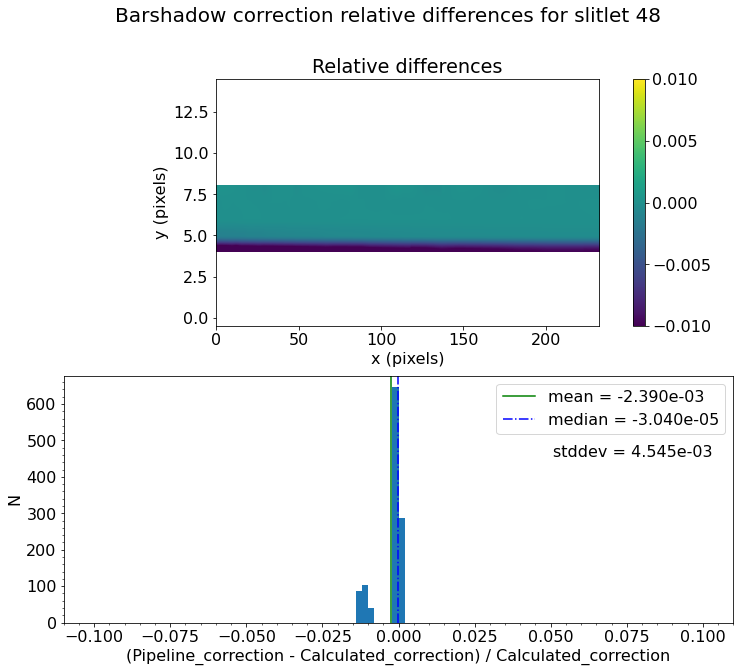


   Relative barshadow_correction  :   mean = -2.390e-03    median = -3.040e-05    stdev = 4.545e-03
    Maximum   Relativebarshadow_correction = 3.286e-04
    Minimum   Relativebarshadow_correction = -1.392e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 20%
                            ->  3xtheshold = 20%
                            ->  5xtheshold = 4%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 48? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  49
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


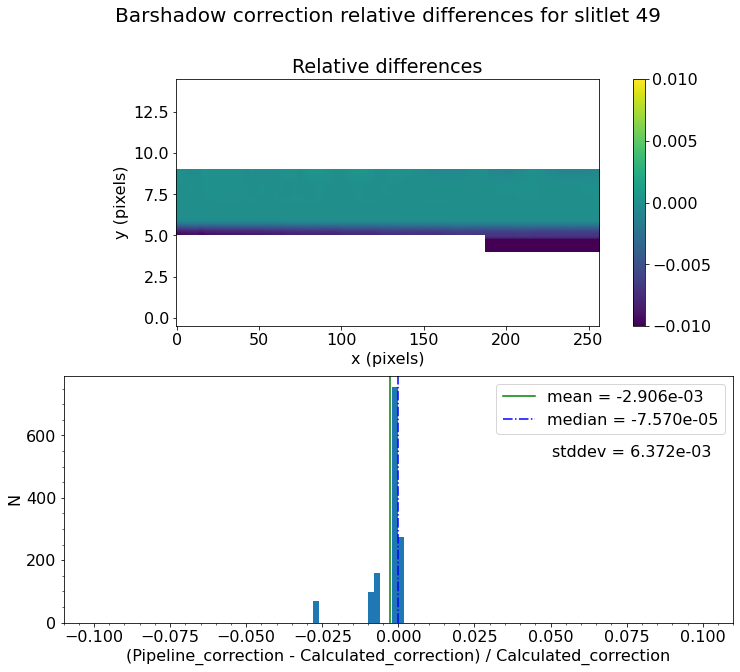


   Relative barshadow_correction  :   mean = -2.906e-03    median = -7.570e-05    stdev = 6.372e-03
    Maximum   Relativebarshadow_correction = 4.926e-04
    Minimum   Relativebarshadow_correction = -2.797e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 14%
                            ->  5xtheshold = 5%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 49? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  50
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


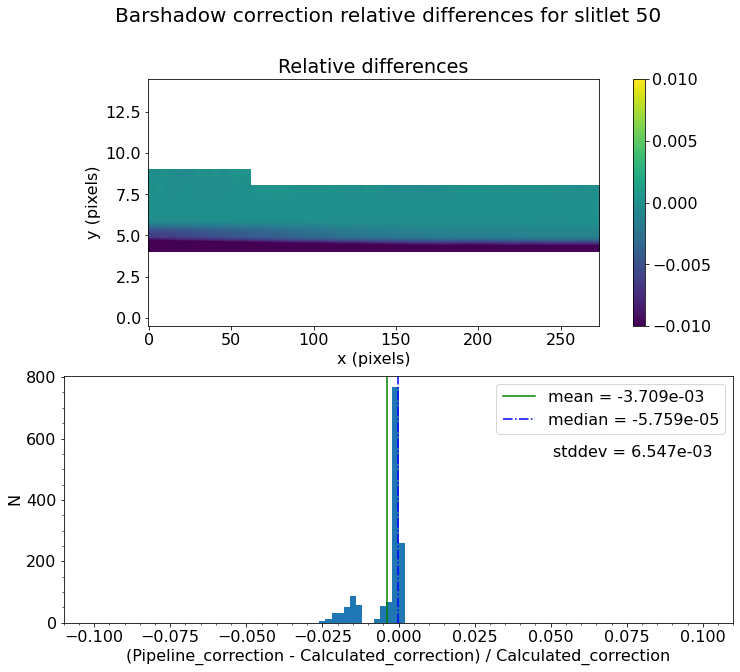


   Relative barshadow_correction  :   mean = -3.709e-03    median = -5.759e-05    stdev = 6.547e-03
    Maximum   Relativebarshadow_correction = 4.152e-04
    Minimum   Relativebarshadow_correction = -2.450e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 27%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 19%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 50? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  51
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Referenc

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


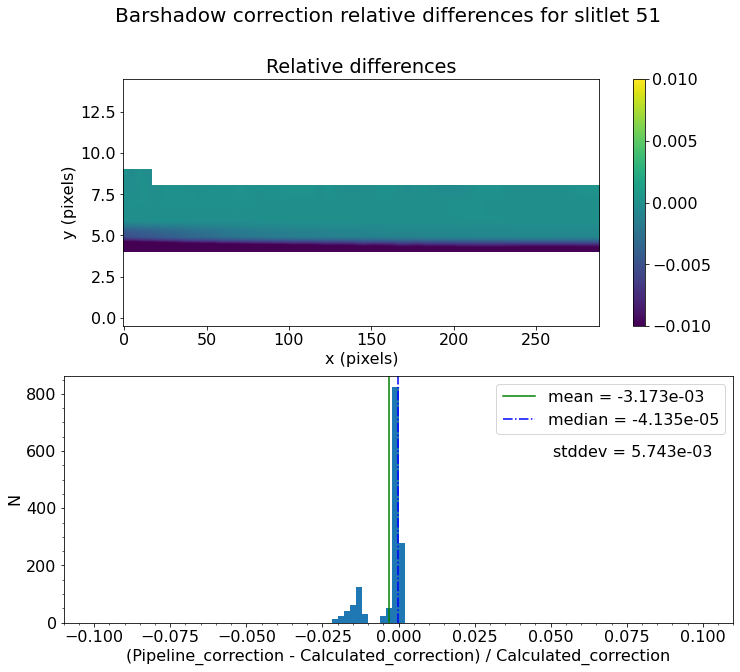


   Relative barshadow_correction  :   mean = -3.173e-03    median = -4.135e-05    stdev = 5.743e-03
    Maximum   Relativebarshadow_correction = 3.422e-04
    Minimum   Relativebarshadow_correction = -2.122e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 20%
                            ->  5xtheshold = 12%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 51? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  52
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Referenc

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Calculation of barshadow correction done.
nan nan


Creating final barshadow test plot...


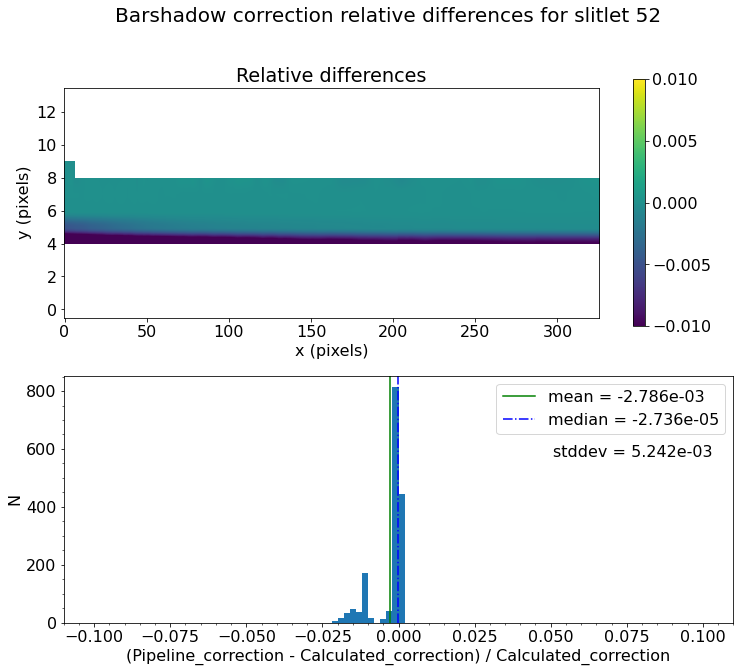


   Relative barshadow_correction  :   mean = -2.786e-03    median = -2.736e-05    stdev = 5.242e-03
    Maximum   Relativebarshadow_correction = 3.349e-04
    Minimum   Relativebarshadow_correction = -2.091e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 22%
                            ->  3xtheshold = 20%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 52? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  55
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


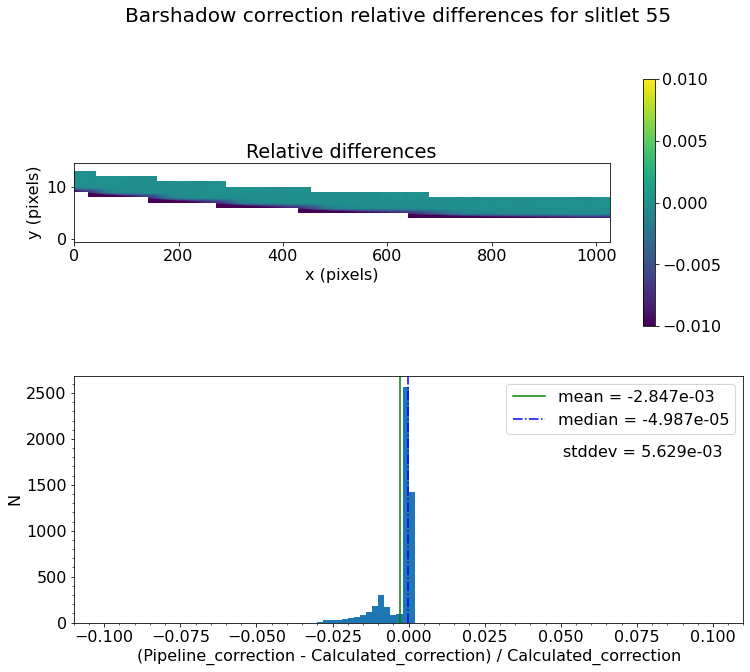


   Relative barshadow_correction  :   mean = -2.847e-03    median = -4.987e-05    stdev = 5.629e-03
    Maximum   Relativebarshadow_correction = 8.210e-04
    Minimum   Relativebarshadow_correction = -2.875e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 55? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  65
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


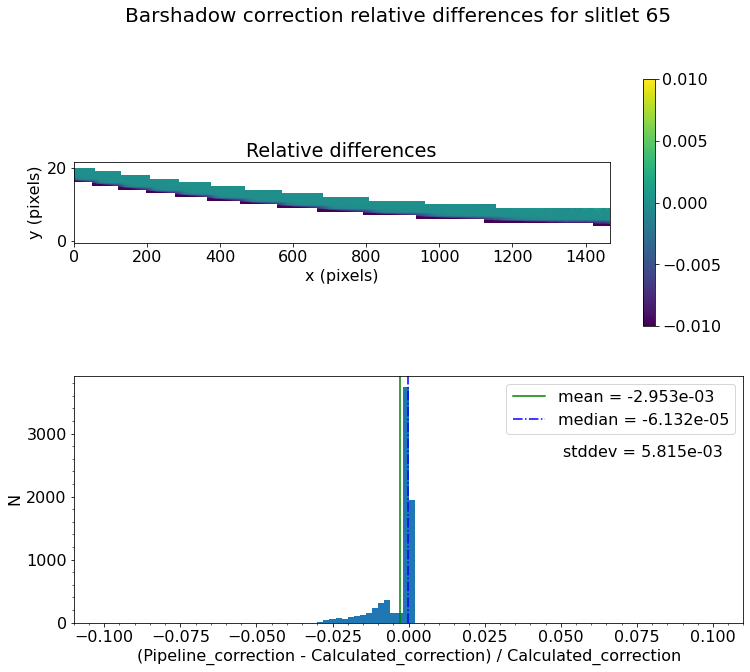


   Relative barshadow_correction  :   mean = -2.953e-03    median = -6.132e-05    stdev = 5.815e-03
    Maximum   Relativebarshadow_correction = 1.896e-03
    Minimum   Relativebarshadow_correction = -2.933e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 65? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  66
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


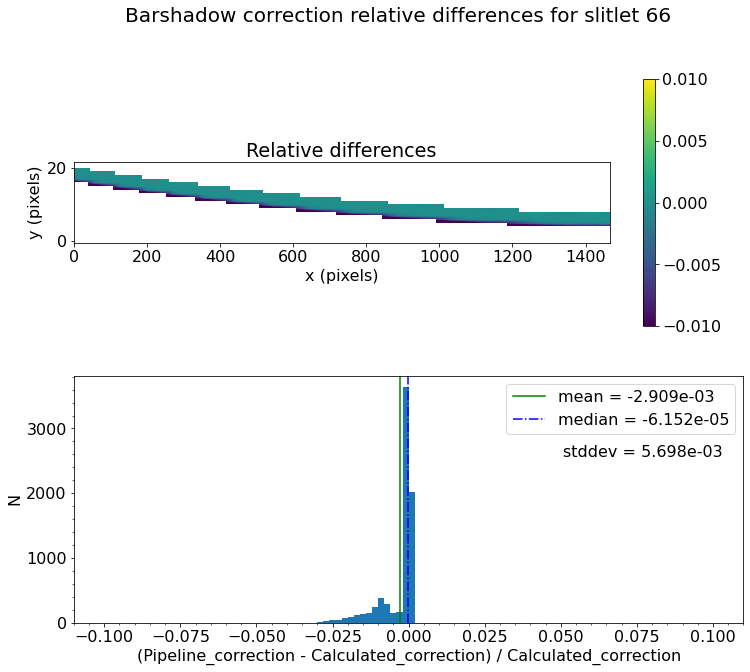


   Relative barshadow_correction  :   mean = -2.909e-03    median = -6.152e-05    stdev = 5.698e-03
    Maximum   Relativebarshadow_correction = 1.364e-03
    Minimum   Relativebarshadow_correction = -2.912e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 66? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  68
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


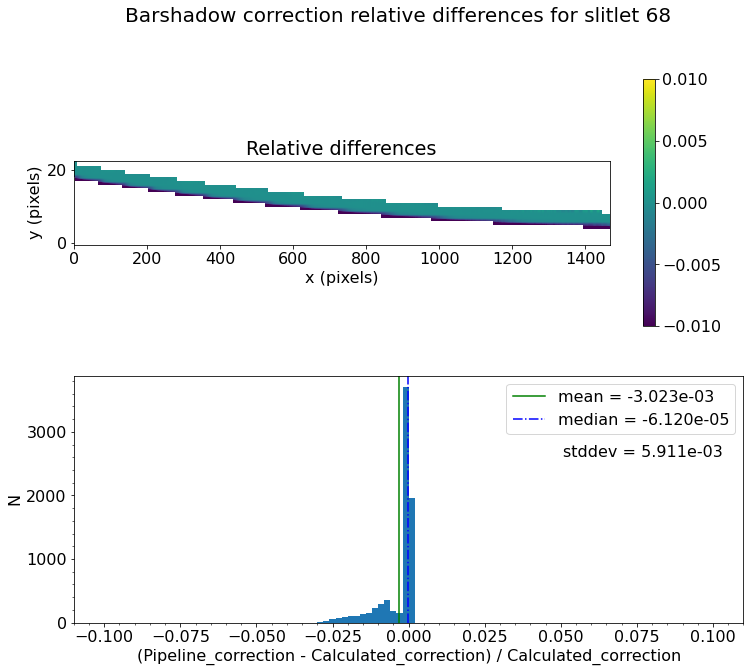


   Relative barshadow_correction  :   mean = -3.023e-03    median = -6.120e-05    stdev = 5.911e-03
    Maximum   Relativebarshadow_correction = 1.874e-03
    Minimum   Relativebarshadow_correction = -2.874e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 68? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  56
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


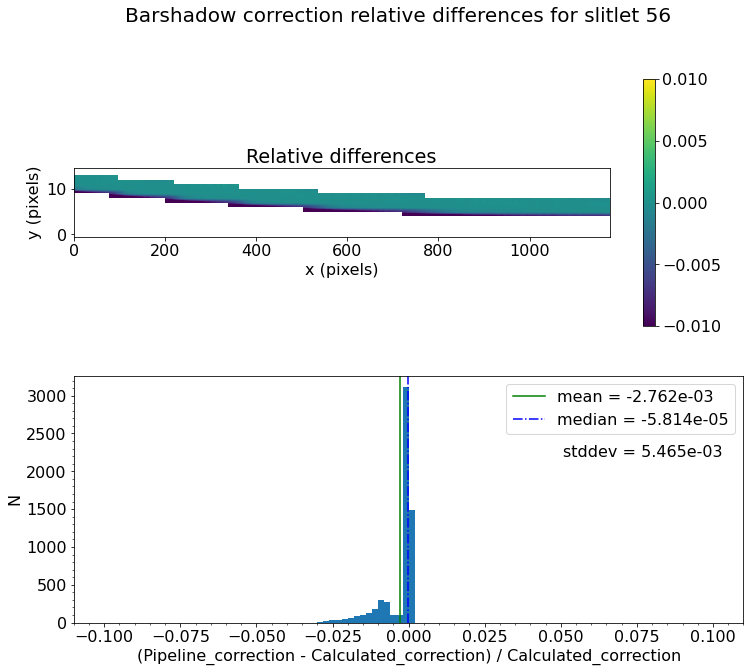


   Relative barshadow_correction  :   mean = -2.762e-03    median = -5.814e-05    stdev = 5.465e-03
    Maximum   Relativebarshadow_correction = 8.661e-04
    Minimum   Relativebarshadow_correction = -2.912e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 56? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  57
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


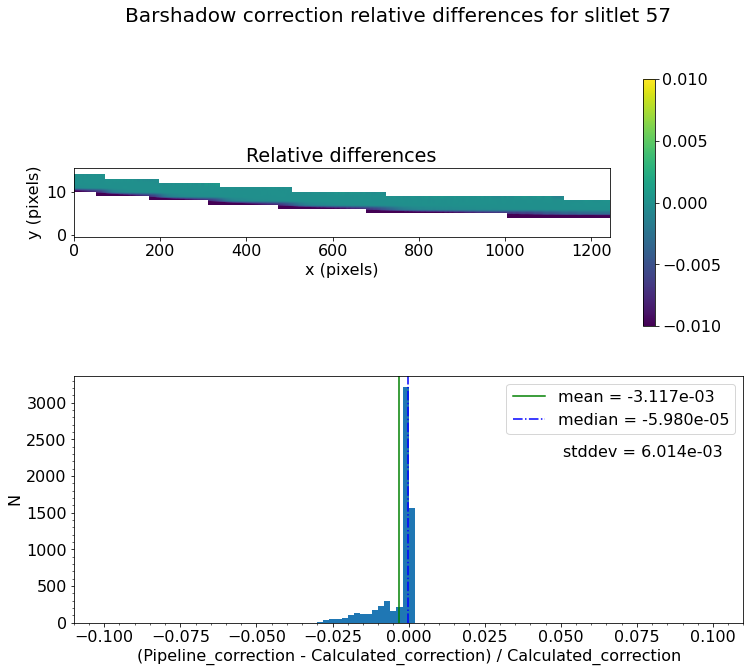


   Relative barshadow_correction  :   mean = -3.117e-03    median = -5.980e-05    stdev = 6.014e-03
    Maximum   Relativebarshadow_correction = 9.866e-04
    Minimum   Relativebarshadow_correction = -2.872e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 26%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 57? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  58
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


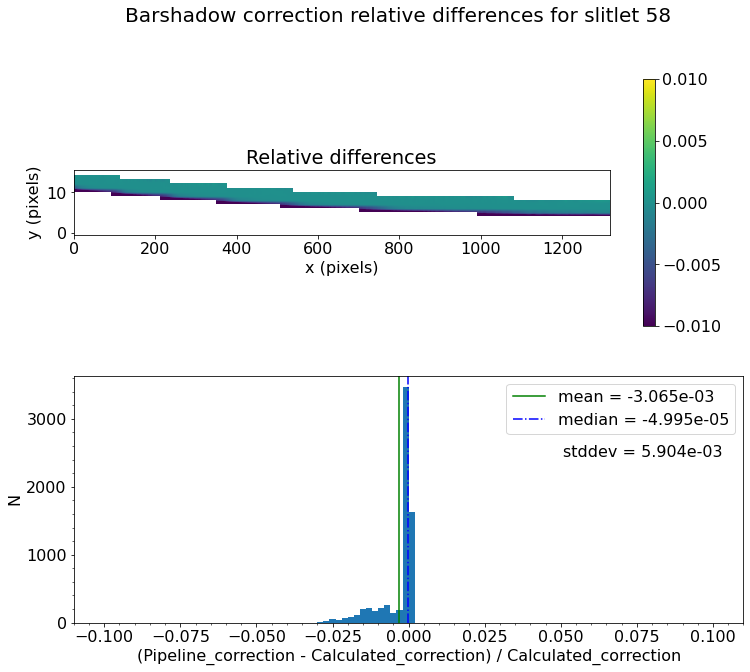


   Relative barshadow_correction  :   mean = -3.065e-03    median = -4.995e-05    stdev = 5.904e-03
    Maximum   Relativebarshadow_correction = 7.673e-04
    Minimum   Relativebarshadow_correction = -2.949e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 11%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 58? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  59
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Referenc

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


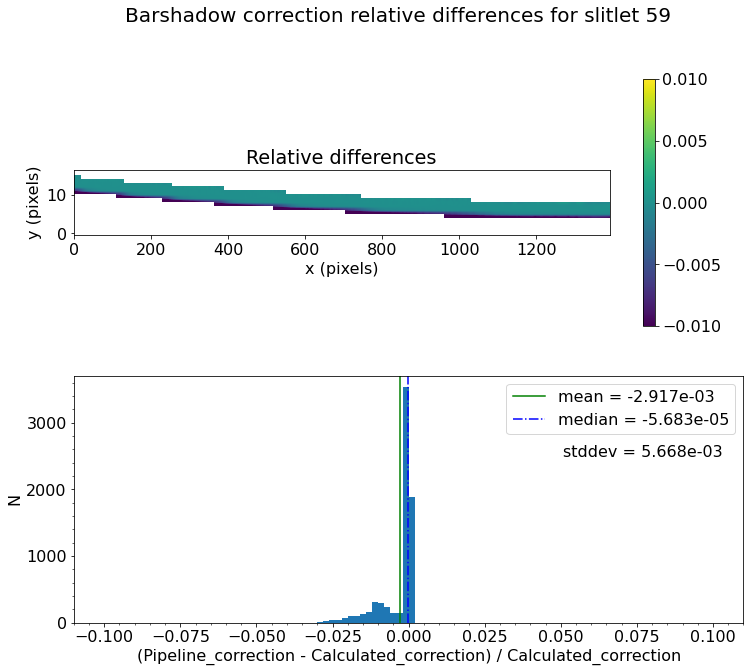


   Relative barshadow_correction  :   mean = -2.917e-03    median = -5.683e-05    stdev = 5.668e-03
    Maximum   Relativebarshadow_correction = 7.876e-04
    Minimum   Relativebarshadow_correction = -2.899e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 59? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  60
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


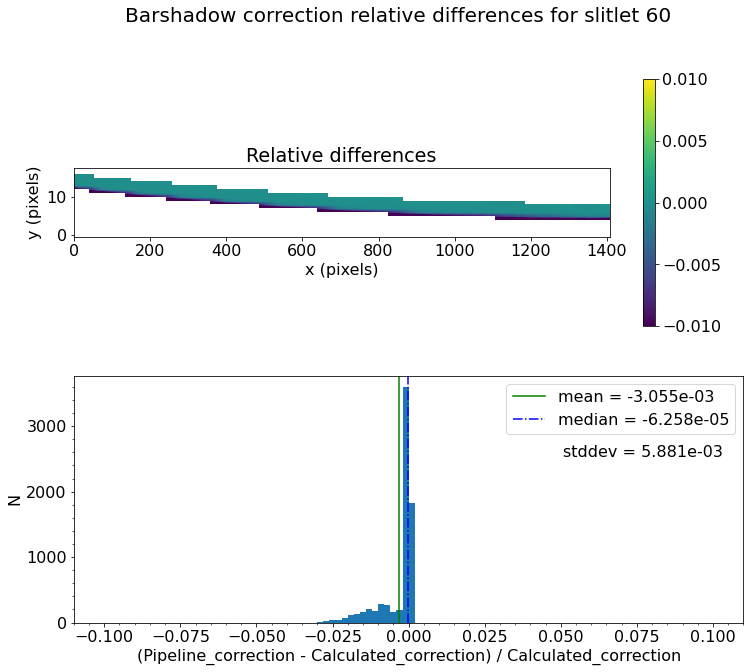


   Relative barshadow_correction  :   mean = -3.055e-03    median = -6.258e-05    stdev = 5.881e-03
    Maximum   Relativebarshadow_correction = 1.090e-03
    Minimum   Relativebarshadow_correction = -2.874e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 60? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  61
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


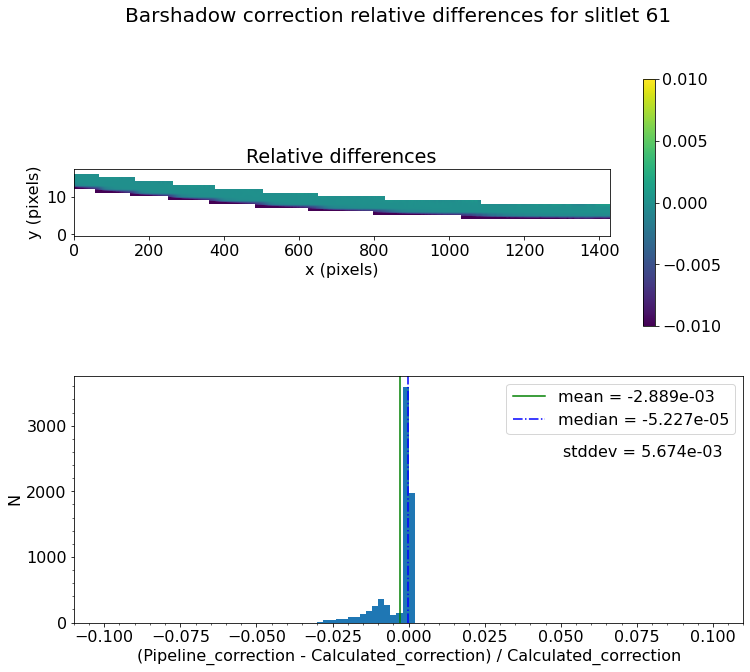


   Relative barshadow_correction  :   mean = -2.889e-03    median = -5.227e-05    stdev = 5.674e-03
    Maximum   Relativebarshadow_correction = 1.279e-03
    Minimum   Relativebarshadow_correction = -2.899e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 61? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  62
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


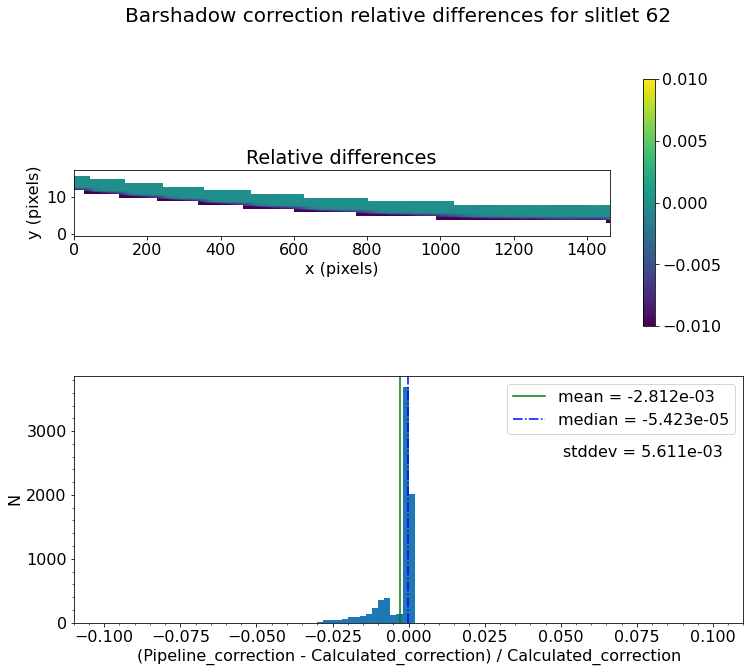


   Relative barshadow_correction  :   mean = -2.812e-03    median = -5.423e-05    stdev = 5.611e-03
    Maximum   Relativebarshadow_correction = 1.796e-03
    Minimum   Relativebarshadow_correction = -2.871e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 62? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  63
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


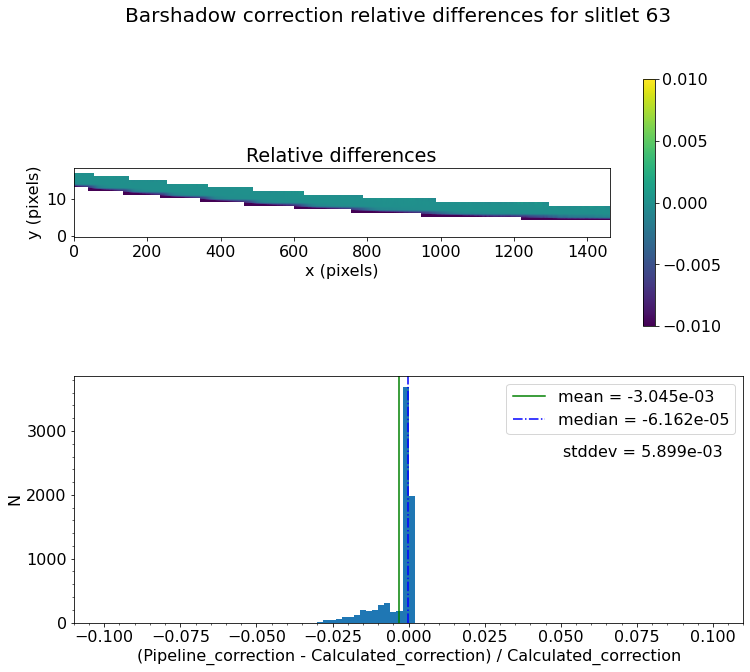


   Relative barshadow_correction  :   mean = -3.045e-03    median = -6.162e-05    stdev = 5.899e-03
    Maximum   Relativebarshadow_correction = 1.109e-03
    Minimum   Relativebarshadow_correction = -2.880e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 63? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  64
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

Calculation of barshadow correction done.
nan nan


Creating final barshadow test plot...


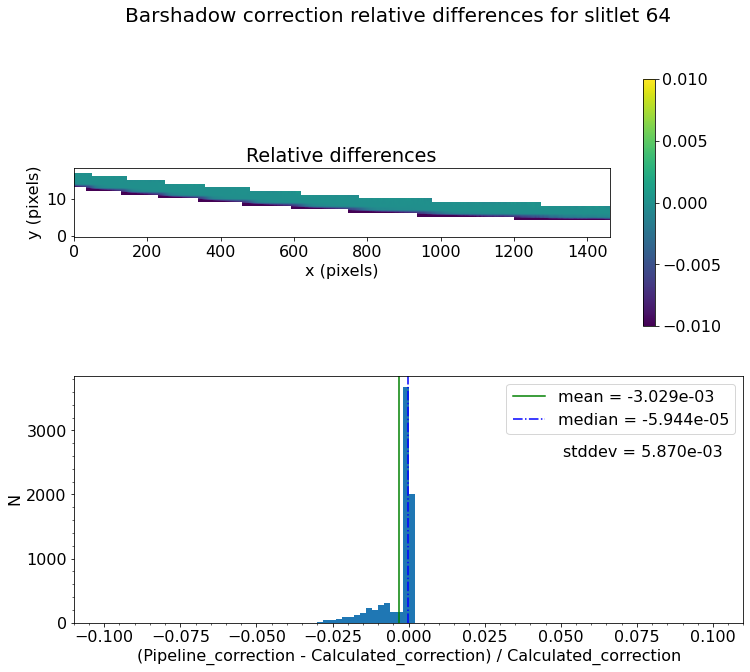


   Relative barshadow_correction  :   mean = -3.029e-03    median = -5.944e-05    stdev = 5.870e-03
    Maximum   Relativebarshadow_correction = 1.419e-03
    Minimum   Relativebarshadow_correction = -2.871e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 64? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  67
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


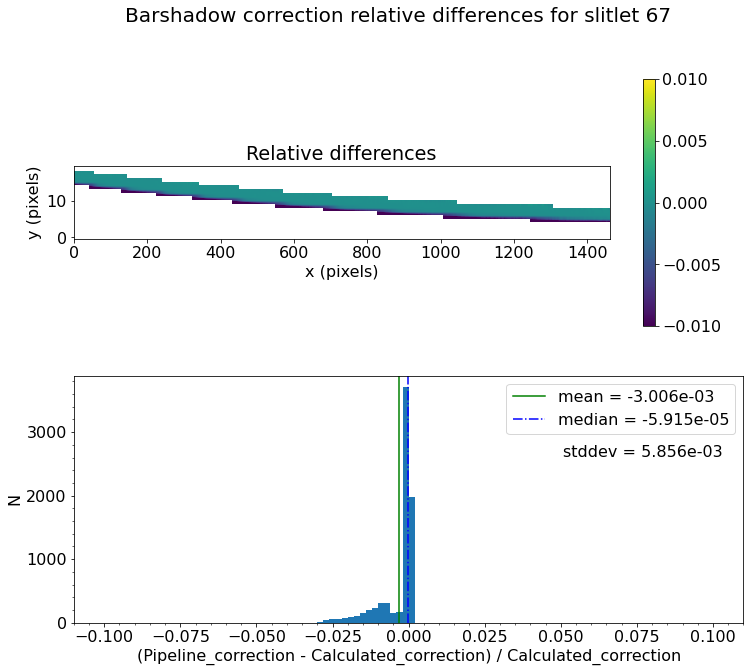


   Relative barshadow_correction  :   mean = -3.006e-03    median = -5.915e-05    stdev = 5.856e-03
    Maximum   Relativebarshadow_correction = 1.246e-03
    Minimum   Relativebarshadow_correction = -2.849e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 67? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED


 * Test of barshadow_correction for slitlet 53  PASSED.

 * Test of barshadow_correction for slitlet 54  PASSED.

 * Test of barshadow_correction for slitlet 42  PASSED.

 * Test of barshadow_correction for slitlet 43  PASSED.

 * Test of barshad

Working with uncal_file:  /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_/mos_g140m_line1_NRS2_uncal.fits


2021-10-04 21:26:31,719 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_nirspec_pars-detector1pipeline_0004.asdf


2021-10-04 21:26:31,745 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-10-04 21:26:31,748 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-10-04 21:26:31,749 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-10-04 21:26:31,751 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-10-04 21:26:31,752 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-10-04 21:26:31,754 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-10-04 21:26:31,756 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-10-04 21:26:31,758 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-10-04 21:26:31,759 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-10-04 21:26:31,761 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-10-04 21:26:31,762 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-10-04 21:26:31,764 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-10-04 21:26:31,765 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-10-04 21:26:31,767 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-10-04 21:26:31,769 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-10-04 21:26:31,770 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-10-04 21:26:31,772 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/step.py:359: ResourceWarning: unclosed file <_io.FileIO name='/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_/mos_g140m_line1_NRS2_uncal.fits' mode='rb' closefd=True>
  gc.collect()


2021-10-04 21:26:32,415 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_/mos_g140m_line1_NRS2_uncal.fits',).


2021-10-04 21:26:32,425 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outp

2021-10-04 21:26:32,564 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'mos_g140m_line1_NRS2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-10-04 21:26:32,574 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dark_0143.fits'.


2021-10-04 21:26:32,577 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits'.


2021-10-04 21:26:32,580 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_linearity_0020.fits'.


2021-10-04 21:26:32,583 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_mask_0025.fits'.


2021-10-04 21:26:32,585 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-10-04 21:26:32,586 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0016.fits'.


2021-10-04 21:26:32,588 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2021-10-04 21:26:32,589 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2021-10-04 21:26:32,590 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2021-10-04 21:26:32,592 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_saturation_0022.fits'.


2021-10-04 21:26:32,595 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_superbias_0104.fits'.


2021-10-04 21:26:32,597 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-10-04 21:26:32,598 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-10-04 21:26:32,599 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-10-04 21:26:33,347 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2021-10-04 21:26:33,349 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:26:33,494 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2021-10-04 21:26:33,496 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-10-04 21:26:33,498 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-10-04 21:26:34,028 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2021-10-04 21:26:34,030 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:26:34,050 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nirspec_mask_0025.fits


2021-10-04 21:26:34,321 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-10-04 21:26:34,855 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2021-10-04 21:26:34,858 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:26:34,877 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nirspec_saturation_0022.fits


2021-10-04 21:26:35,289 - stpipe.Detector1Pipeline.saturation - INFO - Detected 83201 saturated pixels


2021-10-04 21:26:35,312 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-10-04 21:26:35,321 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-10-04 21:26:35,863 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2021-10-04 21:26:35,866 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:26:35,867 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2021-10-04 21:26:35,869 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-10-04 21:26:36,400 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2021-10-04 21:26:36,402 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:26:36,422 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_nirspec_superbias_0104.fits


2021-10-04 21:26:36,714 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2021-10-04 21:26:37,248 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2021-10-04 21:26:37,250 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-10-04 21:26:37,259 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2021-10-04 21:26:37,260 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2021-10-04 21:26:37,261 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2021-10-04 21:26:37,262 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000


2021-10-04 21:26:37,263 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2021-10-04 21:26:39,988 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-10-04 21:26:40,525 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2021-10-04 21:26:40,527 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:26:40,553 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nirspec_linearity_0020.fits


2021-10-04 21:26:41,349 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-10-04 21:26:41,895 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2021-10-04 21:26:41,898 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_', 'dark_output': None}


2021-10-04 21:26:41,918 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_nirspec_dark_0143.fits


2021-10-04 21:26:42,161 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=6, nframes=1, groupgap=0


2021-10-04 21:26:42,162 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=10, nframes=1, groupgap=0


2021-10-04 21:26:42,386 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-10-04 21:26:42,942 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2021-10-04 21:26:42,944 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-10-04 21:26:42,953 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-10-04 21:26:42,964 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits


2021-10-04 21:26:43,021 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0016.fits


2021-10-04 21:26:43,067 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-10-04 21:26:43,263 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-10-04 21:26:43,474 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-10-04 21:26:45,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 39124 pixels with at least one CR and at least four groups


2021-10-04 21:26:45,465 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2731 pixels with at least one CR and three groups


2021-10-04 21:26:45,466 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 48084 pixels with at least one CR and two groups


2021-10-04 21:26:48,502 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 5.23724 sec


2021-10-04 21:26:48,505 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 5.552435


2021-10-04 21:26:48,509 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-10-04 21:26:49,060 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2021-10-04 21:26:49,062 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-10-04 21:26:49,093 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0016.fits


2021-10-04 21:26:49,139 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits


2021-10-04 21:26:49,183 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-10-04 21:26:49,184 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/ramp_fitting/ols_fit.py:1169: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


2021-10-04 21:27:14,274 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 6


2021-10-04 21:27:14,276 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2021-10-04 21:27:14,481 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-10-04 21:27:15,109 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2021-10-04 21:27:15,112 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:27:15,176 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-04 21:27:15,178 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-04 21:27:15,180 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-04 21:27:15,718 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2021-10-04 21:27:15,720 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp933_dwl_'}


2021-10-04 21:27:15,784 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-10-04 21:27:15,786 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-10-04 21:27:15,789 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-10-04 21:27:15,790 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-10-04 21:27:15,791 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-10-04 21:27:15,802 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-10-04 21:27:16,339 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2021-10-04 21:27:16,341 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-10-04 21:27:16,513 - stpipe.AssignWcsStep - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 1


2021-10-04 21:27:16,743 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1260581910610199 deg


2021-10-04 21:27:16,745 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3316612243652344 deg


2021-10-04 21:27:16,746 - stpipe.AssignWcsStep - INFO - theta_y correction: 0.0002496099796717191 deg


2021-10-04 21:27:16,747 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2021-10-04 21:27:17,617 - stpipe.AssignWcsStep - INFO - Removing slit 65 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:27:17,635 - stpipe.AssignWcsStep - INFO - Removing slit 66 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:27:17,650 - stpipe.AssignWcsStep - INFO - Removing slit 68 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:27:17,688 - stpipe.AssignWcsStep - INFO - Removing slit 58 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:27:17,702 - stpipe.AssignWcsStep - INFO - Removing slit 59 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:27:17,717 - stpipe.AssignWcsStep - INFO - Removing slit 60 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:27:17,730 - stpipe.AssignWcsStep - INFO - Removing slit 61 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:27:17,745 - stpipe.AssignWcsStep - INFO - Removing slit 62 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:27:17,759 - stpipe.AssignWcsStep - INFO - Removing slit 63 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:27:17,773 - stpipe.AssignWcsStep - INFO - Removing slit 64 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:27:17,788 - stpipe.AssignWcsStep - INFO - Removing slit 67 from the list of open slits because the WCS bounding_box is completely outside the detector.


2021-10-04 21:27:17,789 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS2: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]


2021-10-04 21:27:17,790 - stpipe.AssignWcsStep - INFO - Computing WCS for 57 open slitlets


2021-10-04 21:27:17,819 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1260581910610199 deg


2021-10-04 21:27:17,821 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3316612243652344 deg


2021-10-04 21:27:17,822 - stpipe.AssignWcsStep - INFO - theta_y correction: 0.0002496099796717191 deg


2021-10-04 21:27:17,823 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2021-10-04 21:27:17,833 - stpipe.AssignWcsStep - INFO - SPORDER= -1, wrange=[9.7e-07, 1.89e-06]


2021-10-04 21:27:17,954 - stpipe.AssignWcsStep - INFO - There are 27 open slits in quadrant 1


2021-10-04 21:27:18,191 - stpipe.AssignWcsStep - INFO - There are 27 open slits in quadrant 2


2021-10-04 21:27:18,414 - stpipe.AssignWcsStep - INFO - There are 1 open slits in quadrant 3


2021-10-04 21:27:18,424 - stpipe.AssignWcsStep - INFO - There are 2 open slits in quadrant 4


2021-10-04 21:27:18,443 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 5


2021-10-04 21:27:18,596 - stpipe.AssignWcsStep - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf', 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf', 'disperser': '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0032.asdf', 'fore': '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0023.asdf', 'fpa': '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf', 'msa': '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf', 'ote': '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None, 'msametafile': 'V8460001000101_msa.fits'}


2021-10-04 21:27:19,400 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2021-10-04 21:27:19,407 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2021-10-04 21:27:19,417 - stpipe.MSAFlagOpenStep - INFO - MSAFlagOpenStep instance created.


2021-10-04 21:27:20,236 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep running with args (<ImageModel(2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2021-10-04 21:27:20,241 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-04 21:27:20,259 - stpipe.MSAFlagOpenStep - INFO - Using reference file /grp/crds/cache/references/jwst/jwst_nirspec_msaoper_0001.json


2021-10-04 21:27:20,262 - stpipe.JwstStep - INFO - JwstStep instance created.


2021-10-04 21:27:20,392 - stpipe.MSAFlagOpenStep - INFO - gwa_ytilt is 0.1260581910610199 deg


2021-10-04 21:27:20,394 - stpipe.MSAFlagOpenStep - INFO - gwa_xtilt is 0.3316612243652344 deg


2021-10-04 21:27:20,395 - stpipe.MSAFlagOpenStep - INFO - theta_y correction: 0.0002496099796717191 deg


2021-10-04 21:27:20,396 - stpipe.MSAFlagOpenStep - INFO - theta_x correction: 0.0 deg


2021-10-04 21:27:20,407 - stpipe.MSAFlagOpenStep - INFO - SPORDER= -1, wrange=[9.7e-07, 1.89e-06]


2021-10-04 21:27:20,535 - stpipe.MSAFlagOpenStep - INFO - There are 5 open slits in quadrant 1


2021-10-04 21:27:20,581 - stpipe.MSAFlagOpenStep - INFO - There are 3 open slits in quadrant 2


2021-10-04 21:27:20,610 - stpipe.MSAFlagOpenStep - INFO - There are 9 open slits in quadrant 3


2021-10-04 21:27:20,691 - stpipe.MSAFlagOpenStep - INFO - There are 3 open slits in quadrant 4


2021-10-04 21:27:20,718 - stpipe.MSAFlagOpenStep - INFO - There are 0 open slits in quadrant 5


/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)


2021-10-04 21:27:34,362 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep done


2021-10-04 21:27:34,374 - stpipe.Extract2dStep - INFO - Extract2dStep instance created.


2021-10-04 21:27:35,201 - stpipe.Extract2dStep - INFO - Step Extract2dStep running with args (<ImageModel(2048, 2048) from mos_g140m_line1_NRS2_uncal.fits>,).


2021-10-04 21:27:35,206 - stpipe.Extract2dStep - INFO - Step Extract2dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_name': None, 'extract_orders': None, 'tsgrism_extract_height': None, 'wfss_extract_half_height': 5, 'grism_objects': None, 'mmag_extract': 99.0}


2021-10-04 21:27:35,227 - stpipe.Extract2dStep - INFO - EXP_TYPE is NRS_MSASPEC


/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)
2021-10-04 21:27:36,148 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 6


2021-10-04 21:27:36,149 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 138 1619


2021-10-04 21:27:36,149 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1761 1785


2021-10-04 21:27:36,302 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:27:36,311 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.263159350 -45.671304678 156.263027991 -45.671181725 156.262965146 -45.671213584 156.263096502 -45.671336538


2021-10-04 21:27:36,312 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.263159350 -45.671304678 156.263027991 -45.671181725 156.262965146 -45.671213584 156.263096502 -45.671336538


2021-10-04 21:27:37,814 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 7


2021-10-04 21:27:37,815 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 138 1619


2021-10-04 21:27:37,816 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1756 1780


2021-10-04 21:27:37,964 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:27:37,974 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.263031777 -45.671185268 156.262900430 -45.671062325 156.262837587 -45.671094183 156.262968931 -45.671217127


2021-10-04 21:27:37,975 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.263031777 -45.671185268 156.262900430 -45.671062325 156.262837587 -45.671094183 156.262968931 -45.671217127


2021-10-04 21:27:38,879 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 8


2021-10-04 21:27:38,880 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 137 1618


2021-10-04 21:27:38,881 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1806 1830


2021-10-04 21:27:39,029 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:27:39,038 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.264221225 -45.672423837 156.264089757 -45.672300789 156.264026890 -45.672332658 156.264158355 -45.672455707


2021-10-04 21:27:39,039 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.264221225 -45.672423837 156.264089757 -45.672300789 156.264026890 -45.672332658 156.264158355 -45.672455707


2021-10-04 21:27:40,653 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 9


2021-10-04 21:27:40,654 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 137 1618


2021-10-04 21:27:40,654 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1801 1825


2021-10-04 21:27:40,803 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:27:40,812 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.264093546 -45.672304335 156.263962090 -45.672181297 156.263899225 -45.672213165 156.264030678 -45.672336204


2021-10-04 21:27:40,814 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.264093546 -45.672304335 156.263962090 -45.672181297 156.263899225 -45.672213165 156.264030678 -45.672336204


2021-10-04 21:27:41,731 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 10


2021-10-04 21:27:41,732 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 137 1618


2021-10-04 21:27:41,733 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1796 1820


2021-10-04 21:27:41,883 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:27:41,893 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.263965879 -45.672184843 156.263834436 -45.672061816 156.263771574 -45.672093683 156.263903014 -45.672216711


2021-10-04 21:27:41,894 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.263965879 -45.672184843 156.263834436 -45.672061816 156.263771574 -45.672093683 156.263903014 -45.672216711


2021-10-04 21:27:43,528 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 11


2021-10-04 21:27:43,530 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 136 1617


2021-10-04 21:27:43,530 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1836 1860


2021-10-04 21:27:43,678 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:27:43,688 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.264900700 -45.673185083 156.264769161 -45.673061972 156.264706280 -45.673093849 156.264837816 -45.673216961


2021-10-04 21:27:43,689 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.264900700 -45.673185083 156.264769161 -45.673061972 156.264706280 -45.673093849 156.264837816 -45.673216961


2021-10-04 21:27:45,246 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 14


2021-10-04 21:27:45,247 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 104 1582


2021-10-04 21:27:45,248 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1221 1243


2021-10-04 21:27:45,392 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:27:45,401 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.249021000 -45.658685479 156.248891047 -45.658563629 156.248828487 -45.658595378 156.248958437 -45.658717230


2021-10-04 21:27:45,402 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.249021000 -45.658685479 156.248891047 -45.658563629 156.248828487 -45.658595378 156.248958437 -45.658717230


2021-10-04 21:27:46,316 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 15


2021-10-04 21:27:46,317 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 122 1604


2021-10-04 21:27:46,317 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1886 1910


2021-10-04 21:27:46,482 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:27:46,492 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.265657550 -45.674645528 156.265525910 -45.674522304 156.265463012 -45.674554193 156.265594650 -45.674677417


2021-10-04 21:27:46,493 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.265657550 -45.674645528 156.265525910 -45.674522304 156.265463012 -45.674554193 156.265594650 -45.674677417


2021-10-04 21:27:48,229 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 16


2021-10-04 21:27:48,230 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 117 1598


2021-10-04 21:27:48,231 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1821 1845


2021-10-04 21:27:48,381 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:27:48,391 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.263909649 -45.673134588 156.263778173 -45.673011497 156.263715311 -45.673043371 156.263846784 -45.673166463


2021-10-04 21:27:48,392 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.263909649 -45.673134588 156.263778173 -45.673011497 156.263715311 -45.673043371 156.263846784 -45.673166463


2021-10-04 21:27:49,304 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 17


2021-10-04 21:27:49,305 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 115 1597


2021-10-04 21:27:49,306 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1851 1875


2021-10-04 21:27:49,494 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:27:49,503 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.264589177 -45.673896098 156.264457630 -45.673772943 156.264394753 -45.673804824 156.264526298 -45.673927980


2021-10-04 21:27:49,504 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.264589177 -45.673896098 156.264457630 -45.673772943 156.264394753 -45.673804824 156.264526298 -45.673927980


2021-10-04 21:27:51,192 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 18


2021-10-04 21:27:51,193 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 115 1597


2021-10-04 21:27:51,194 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1846 1870


2021-10-04 21:27:51,364 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:27:51,373 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.264461421 -45.673776492 156.264329887 -45.673653347 156.264267013 -45.673685227 156.264398544 -45.673808373


2021-10-04 21:27:51,375 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.264461421 -45.673776492 156.264329887 -45.673653347 156.264267013 -45.673685227 156.264398544 -45.673808373


2021-10-04 21:27:52,272 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 19


2021-10-04 21:27:52,273 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 93 1571


2021-10-04 21:27:52,274 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1336 1358


2021-10-04 21:27:52,419 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:27:52,428 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.251408362 -45.661673296 156.251278132 -45.661551203 156.251215522 -45.661582975 156.251345749 -45.661705069


2021-10-04 21:27:52,430 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.251408362 -45.661673296 156.251278132 -45.661551203 156.251215522 -45.661582975 156.251345749 -45.661705069


2021-10-04 21:27:54,097 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 21


2021-10-04 21:27:54,098 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 89 1568


2021-10-04 21:27:54,099 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1381 1403


2021-10-04 21:27:54,241 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:27:54,250 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.252374207 -45.662828704 156.252243867 -45.662706516 156.252181238 -45.662738296 156.252311575 -45.662860485


2021-10-04 21:27:54,251 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.252374207 -45.662828704 156.252243867 -45.662706516 156.252181238 -45.662738296 156.252311575 -45.662860485


2021-10-04 21:27:55,155 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 25


2021-10-04 21:27:55,156 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 70 1547


2021-10-04 21:27:55,157 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1276 1298


2021-10-04 21:27:55,308 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:27:55,317 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.249200048 -45.660601994 156.249070003 -45.660480012 156.249007436 -45.660511773 156.249137478 -45.660633755


2021-10-04 21:27:55,318 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.249200048 -45.660601994 156.249070003 -45.660480012 156.249007436 -45.660511773 156.249137478 -45.660633755


2021-10-04 21:27:56,212 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 26


2021-10-04 21:27:56,213 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 65 1544


2021-10-04 21:27:56,214 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1562 1584


2021-10-04 21:27:57,190 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:27:57,199 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.255900113 -45.667634746 156.255769353 -45.667512168 156.255706649 -45.667543987 156.255837406 -45.667666566


2021-10-04 21:27:57,200 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.255900113 -45.667634746 156.255769353 -45.667512168 156.255706649 -45.667543987 156.255837406 -45.667666566


2021-10-04 21:27:58,105 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 27


2021-10-04 21:27:58,106 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 31 1507


2021-10-04 21:27:58,107 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1201 1222


2021-10-04 21:27:58,254 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:27:58,263 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.246097982 -45.659439921 156.245968181 -45.659318074 156.245905674 -45.659349821 156.246035471 -45.659471670


2021-10-04 21:27:58,265 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.246097982 -45.659439921 156.245968181 -45.659318074 156.245905674 -45.659349821 156.246035471 -45.659471670


2021-10-04 21:27:59,872 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 29


2021-10-04 21:27:59,873 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 22 1503


2021-10-04 21:27:59,873 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1867 1889


2021-10-04 21:28:00,019 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:00,030 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.261846987 -45.675840555 156.261715536 -45.675717309 156.261652705 -45.675749201 156.261784154 -45.675872448


2021-10-04 21:28:00,031 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.261846987 -45.675840555 156.261715536 -45.675717309 156.261652705 -45.675749201 156.261784154 -45.675872448


2021-10-04 21:28:00,955 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 31


2021-10-04 21:28:00,956 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1464


2021-10-04 21:28:00,957 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1367 1388


2021-10-04 21:28:01,106 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:01,116 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.248622769 -45.664184605 156.248492610 -45.664062392 156.248430047 -45.664094174 156.248560203 -45.664216388


2021-10-04 21:28:01,117 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.248622769 -45.664184605 156.248492610 -45.664062392 156.248430047 -45.664094174 156.248560203 -45.664216388


2021-10-04 21:28:02,007 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 32


2021-10-04 21:28:02,009 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1432


2021-10-04 21:28:02,009 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1352 1372


2021-10-04 21:28:03,004 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:03,014 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.247206881 -45.664355302 156.247076805 -45.664233103 156.247014266 -45.664264884 156.247144339 -45.664387085


2021-10-04 21:28:03,015 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.247206881 -45.664355302 156.247076805 -45.664233103 156.247014266 -45.664264884 156.247144339 -45.664387085


2021-10-04 21:28:03,920 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 33


2021-10-04 21:28:03,922 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1418


2021-10-04 21:28:03,922 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1272 1292


2021-10-04 21:28:04,064 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:04,075 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.244841867 -45.662633161 156.244712012 -45.662511121 156.244649520 -45.662542887 156.244779372 -45.662664928


2021-10-04 21:28:04,076 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.244841867 -45.662633161 156.244712012 -45.662511121 156.244649520 -45.662542887 156.244779372 -45.662664928


2021-10-04 21:28:05,851 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 35


2021-10-04 21:28:05,852 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1428


2021-10-04 21:28:05,852 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1722 1743


2021-10-04 21:28:05,994 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:06,003 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.255896650 -45.673517700 156.255765657 -45.673394713 156.255702938 -45.673426578 156.255833929 -45.673549566


2021-10-04 21:28:06,004 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.255896650 -45.673517700 156.255765657 -45.673394713 156.255702938 -45.673426578 156.255833929 -45.673549566


2021-10-04 21:28:06,920 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 37


2021-10-04 21:28:06,921 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1412


2021-10-04 21:28:06,922 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1663 1683


2021-10-04 21:28:07,067 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:07,077 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.253937935 -45.672305027 156.253807112 -45.672182158 156.253744431 -45.672214010 156.253875252 -45.672336880


2021-10-04 21:28:07,078 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.253937935 -45.672305027 156.253807112 -45.672182158 156.253744431 -45.672214010 156.253875252 -45.672336880


2021-10-04 21:28:08,745 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 38


2021-10-04 21:28:08,746 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1404


2021-10-04 21:28:08,747 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1603 1623


2021-10-04 21:28:08,891 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:08,901 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.252241050 -45.670961715 156.252110387 -45.670838969 156.252047741 -45.670870808 156.252178401 -45.670993555


2021-10-04 21:28:08,903 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.252241050 -45.670961715 156.252110387 -45.670838969 156.252047741 -45.670870808 156.252178401 -45.670993555


2021-10-04 21:28:09,821 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 39


2021-10-04 21:28:09,822 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1385


2021-10-04 21:28:09,822 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1242 1262


2021-10-04 21:28:09,965 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:09,976 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.243049984 -45.662448591 156.242920250 -45.662326596 156.242857790 -45.662358358 156.242987521 -45.662480354


2021-10-04 21:28:09,977 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.243049984 -45.662448591 156.242920250 -45.662326596 156.242857790 -45.662358358 156.242987521 -45.662480354


2021-10-04 21:28:10,875 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 41


2021-10-04 21:28:10,876 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1393


2021-10-04 21:28:10,877 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1768 1788


2021-10-04 21:28:11,021 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:11,033 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.255829101 -45.675209536 156.255698046 -45.675086431 156.255635323 -45.675118310 156.255766375 -45.675241415


2021-10-04 21:28:11,034 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.255829101 -45.675209536 156.255698046 -45.675086431 156.255635323 -45.675118310 156.255766375 -45.675241415


2021-10-04 21:28:12,840 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 53


2021-10-04 21:28:12,841 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 819


2021-10-04 21:28:12,842 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1315 1329


2021-10-04 21:28:12,977 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:12,987 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.226123221 -45.673642180 156.225994086 -45.673519691 156.225931834 -45.673551545 156.226060967 -45.673674035


2021-10-04 21:28:12,989 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.226123221 -45.673642180 156.225994086 -45.673519691 156.225931834 -45.673551545 156.226060967 -45.673674035


2021-10-04 21:28:13,906 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 54


2021-10-04 21:28:13,907 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 819


2021-10-04 21:28:13,908 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1305 1319


2021-10-04 21:28:14,043 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:14,053 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.225872406 -45.673404272 156.225743296 -45.673281804 156.225681049 -45.673313656 156.225810156 -45.673436124


2021-10-04 21:28:14,055 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.225872406 -45.673404272 156.225743296 -45.673281804 156.225681049 -45.673313656 156.225810156 -45.673436124


2021-10-04 21:28:15,809 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 1


2021-10-04 21:28:15,811 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 118 1591


2021-10-04 21:28:15,811 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 33 52


2021-10-04 21:28:15,953 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:15,964 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.221266819 -45.630196596 156.221139727 -45.630076839 156.221077689 -45.630108429 156.221204778 -45.630228186


2021-10-04 21:28:15,966 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.221266819 -45.630196596 156.221139727 -45.630076839 156.221077689 -45.630108429 156.221204778 -45.630228186


2021-10-04 21:28:16,883 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 2


2021-10-04 21:28:16,884 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 124 1598


2021-10-04 21:28:16,885 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 331 351


2021-10-04 21:28:17,034 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:17,043 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.228476955 -45.637109572 156.228349188 -45.636989367 156.228287022 -45.637020983 156.228414786 -45.637141189


2021-10-04 21:28:17,044 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.228476955 -45.637109572 156.228349188 -45.636989367 156.228287022 -45.637020983 156.228414786 -45.637141189


2021-10-04 21:28:18,780 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 3


2021-10-04 21:28:18,781 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 116 1589


2021-10-04 21:28:18,782 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 54 73


2021-10-04 21:28:18,923 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:18,934 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.221674541 -45.630705151 156.221547408 -45.630585366 156.221485363 -45.630616957 156.221612493 -45.630736743


2021-10-04 21:28:18,935 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.221674541 -45.630705151 156.221547408 -45.630585366 156.221485363 -45.630616957 156.221612493 -45.630736743


2021-10-04 21:28:19,864 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 4


2021-10-04 21:28:19,865 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 111 1584


2021-10-04 21:28:19,866 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 160 179


2021-10-04 21:28:20,013 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:20,023 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.224010549 -45.633278787 156.223883188 -45.633158845 156.223821102 -45.633190445 156.223948460 -45.633310387


2021-10-04 21:28:20,025 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.224010549 -45.633278787 156.223883188 -45.633158845 156.223821102 -45.633190445 156.223948460 -45.633310387


2021-10-04 21:28:21,793 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 5


2021-10-04 21:28:21,794 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 99 1573


2021-10-04 21:28:21,795 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 306 326


2021-10-04 21:28:21,939 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:21,948 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.227084510 -45.636919416 156.226956832 -45.636799245 156.226894691 -45.636830857 156.227022367 -45.636951029


2021-10-04 21:28:21,949 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.227084510 -45.636919416 156.226956832 -45.636799245 156.226894691 -45.636830857 156.227022367 -45.636951029


2021-10-04 21:28:22,857 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 12


2021-10-04 21:28:22,858 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 91 1566


2021-10-04 21:28:22,859 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 483 503


2021-10-04 21:28:23,008 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:23,017 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.230998580 -45.641224458 156.230870498 -45.641103991 156.230808285 -45.641135623 156.230936364 -45.641256090


2021-10-04 21:28:23,018 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.230998580 -45.641224458 156.230870498 -45.641103991 156.230808285 -45.641135623 156.230936364 -45.641256090


2021-10-04 21:28:23,908 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 13


2021-10-04 21:28:23,909 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 80 1553


2021-10-04 21:28:23,910 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 94 113


2021-10-04 21:28:24,050 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:24,060 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.221461889 -45.632246282 156.221334710 -45.632126430 156.221272668 -45.632158022 156.221399846 -45.632277874


2021-10-04 21:28:24,061 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.221461889 -45.632246282 156.221334710 -45.632126430 156.221272668 -45.632158022 156.221399846 -45.632277874


2021-10-04 21:28:25,887 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 20


2021-10-04 21:28:25,888 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 76 1551


2021-10-04 21:28:25,889 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 750 770


2021-10-04 21:28:26,032 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:26,041 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.236828252 -45.647826217 156.236699542 -45.647705266 156.236637217 -45.647736933 156.236765924 -45.647857884


2021-10-04 21:28:26,042 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.236828252 -45.647826217 156.236699542 -45.647705266 156.236637217 -45.647736933 156.236765924 -45.647857884


2021-10-04 21:28:26,942 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 22


2021-10-04 21:28:26,943 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 68 1542


2021-10-04 21:28:26,944 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 644 664


2021-10-04 21:28:27,086 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:27,095 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.234035860 -45.645450737 156.233907420 -45.645329977 156.233845148 -45.645361628 156.233973585 -45.645482389


2021-10-04 21:28:27,096 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.234035860 -45.645450737 156.233907420 -45.645329977 156.233845148 -45.645361628 156.233973585 -45.645482389


2021-10-04 21:28:28,948 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 23


2021-10-04 21:28:28,949 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 52 1525


2021-10-04 21:28:28,950 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 115 133


2021-10-04 21:28:29,091 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:29,101 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.221012951 -45.633191592 156.220885760 -45.633071703 156.220823726 -45.633103294 156.220950915 -45.633223183


2021-10-04 21:28:29,102 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.221012951 -45.633191592 156.220885760 -45.633071703 156.220823726 -45.633103294 156.220950915 -45.633223183


2021-10-04 21:28:30,006 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 24


2021-10-04 21:28:30,007 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 69 1545


2021-10-04 21:28:30,007 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 785 805


2021-10-04 21:28:30,151 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:30,160 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.237444560 -45.648779316 156.237315772 -45.648658296 156.237253434 -45.648689968 156.237382219 -45.648810988


2021-10-04 21:28:30,162 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.237444560 -45.648779316 156.237315772 -45.648658296 156.237253434 -45.648689968 156.237382219 -45.648810988


2021-10-04 21:28:31,974 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 28


2021-10-04 21:28:31,975 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 11 1485


2021-10-04 21:28:31,976 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 660 679


2021-10-04 21:28:32,120 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:32,131 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.232517711 -45.646764241 156.232389309 -45.646643431 156.232327062 -45.646675084 156.232455462 -45.646795894


2021-10-04 21:28:32,132 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.232517711 -45.646764241 156.232389309 -45.646643431 156.232327062 -45.646675084 156.232455462 -45.646795894


2021-10-04 21:28:33,050 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 30


2021-10-04 21:28:33,051 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1457


2021-10-04 21:28:33,052 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 700 719


2021-10-04 21:28:33,198 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:33,209 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.232568977 -45.648183467 156.232440513 -45.648062572 156.232378263 -45.648094230 156.232506725 -45.648215126


2021-10-04 21:28:33,210 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.232568977 -45.648183467 156.232440513 -45.648062572 156.232378263 -45.648094230 156.232506725 -45.648215126


2021-10-04 21:28:34,123 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 34


2021-10-04 21:28:34,124 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1394


2021-10-04 21:28:34,124 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 715 734


2021-10-04 21:28:34,266 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:34,278 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.230879662 -45.649585075 156.230751242 -45.649464125 156.230689019 -45.649495787 156.230817437 -45.649616737


2021-10-04 21:28:34,280 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.230879662 -45.649585075 156.230751242 -45.649464125 156.230689019 -45.649495787 156.230817437 -45.649616737


2021-10-04 21:28:36,176 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 36


2021-10-04 21:28:36,177 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1377


2021-10-04 21:28:36,178 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 449 466


2021-10-04 21:28:36,316 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:36,327 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.224033871 -45.643507774 156.223906106 -45.643387302 156.223844011 -45.643418924 156.223971774 -45.643539396


2021-10-04 21:28:36,328 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.224033871 -45.643507774 156.223906106 -45.643387302 156.223844011 -45.643418924 156.223971774 -45.643539396


2021-10-04 21:28:37,234 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 40


2021-10-04 21:28:37,235 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1343


2021-10-04 21:28:37,236 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 217 234


2021-10-04 21:28:37,377 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:37,387 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.217486084 -45.638574970 156.217358883 -45.638454874 156.217296902 -45.638486467 156.217424102 -45.638606563


2021-10-04 21:28:37,388 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.217486084 -45.638574970 156.217358883 -45.638454874 156.217296902 -45.638486467 156.217424102 -45.638606563


2021-10-04 21:28:39,229 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 42


2021-10-04 21:28:39,230 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1296


2021-10-04 21:28:39,231 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 545 562


2021-10-04 21:28:39,370 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:39,381 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.223646010 -45.647128995 156.223518121 -45.647008321 156.223456024 -45.647039957 156.223583911 -45.647160632


2021-10-04 21:28:39,382 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.223646010 -45.647128995 156.223518121 -45.647008321 156.223456024 -45.647039957 156.223583911 -45.647160632


2021-10-04 21:28:40,293 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 43


2021-10-04 21:28:40,294 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1246


2021-10-04 21:28:40,295 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 414 430


2021-10-04 21:28:40,435 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:40,446 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.218966486 -45.644829601 156.218838959 -45.644709141 156.218776943 -45.644740759 156.218904467 -45.644861220


2021-10-04 21:28:40,447 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.218966486 -45.644829601 156.218838959 -45.644709141 156.218776943 -45.644740759 156.218904467 -45.644861220


2021-10-04 21:28:41,351 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 44


2021-10-04 21:28:41,352 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1246


2021-10-04 21:28:41,352 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 404 420


2021-10-04 21:28:41,490 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:41,500 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.218718991 -45.644595818 156.218591488 -45.644475376 156.218529475 -45.644506992 156.218656977 -45.644627436


2021-10-04 21:28:41,501 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.218718991 -45.644595818 156.218591488 -45.644475376 156.218529475 -45.644506992 156.218656977 -45.644627436


2021-10-04 21:28:43,438 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 45


2021-10-04 21:28:43,439 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1185


2021-10-04 21:28:43,440 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 530 546


2021-10-04 21:28:43,582 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:43,593 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.219673020 -45.648613077 156.219545303 -45.648492383 156.219483265 -45.648524021 156.219610979 -45.648644716


2021-10-04 21:28:43,594 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.219673020 -45.648613077 156.219545303 -45.648492383 156.219483265 -45.648524021 156.219610979 -45.648644716


2021-10-04 21:28:44,503 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 46


2021-10-04 21:28:44,504 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1158


2021-10-04 21:28:44,505 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 202 218


2021-10-04 21:28:44,645 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:44,655 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.211127421 -45.641279813 156.211000463 -45.641159678 156.210938572 -45.641191268 156.211065527 -45.641311404


2021-10-04 21:28:44,656 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.211127421 -45.641279813 156.211000463 -45.641159678 156.210938572 -45.641191268 156.211065527 -45.641311404


2021-10-04 21:28:45,544 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 47


2021-10-04 21:28:45,545 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1091


2021-10-04 21:28:45,546 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 566 581


2021-10-04 21:28:45,682 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:45,692 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.217456055 -45.651006881 156.217328370 -45.650886079 156.217266356 -45.650917729 156.217394038 -45.651038531


2021-10-04 21:28:45,693 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.217456055 -45.651006881 156.217328370 -45.650886079 156.217266356 -45.650917729 156.217394038 -45.651038531


2021-10-04 21:28:47,616 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 48


2021-10-04 21:28:47,617 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1091


2021-10-04 21:28:47,618 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 561 576


2021-10-04 21:28:47,755 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:47,766 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.217332149 -45.650889654 156.217204477 -45.650768862 156.217142464 -45.650800511 156.217270135 -45.650921304


2021-10-04 21:28:47,767 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.217332149 -45.650889654 156.217204477 -45.650768862 156.217142464 -45.650800511 156.217270135 -45.650921304


2021-10-04 21:28:48,688 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 49


2021-10-04 21:28:48,689 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1067


2021-10-04 21:28:48,690 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 632 647


2021-10-04 21:28:48,827 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:48,838 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.218210913 -45.652969013 156.218083107 -45.652848076 156.218021073 -45.652879740 156.218148877 -45.653000678


2021-10-04 21:28:48,840 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.218210913 -45.652969013 156.218083107 -45.652848076 156.218021073 -45.652879740 156.218148877 -45.653000678


2021-10-04 21:28:50,757 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 50


2021-10-04 21:28:50,758 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1048


2021-10-04 21:28:50,758 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 238 253


2021-10-04 21:28:50,896 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:50,906 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.208399869 -45.643929179 156.208272959 -45.643808942 156.208211096 -45.643840541 156.208338005 -45.643960778


2021-10-04 21:28:50,908 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.208399869 -45.643929179 156.208272959 -45.643808942 156.208211096 -45.643840541 156.208338005 -45.643960778


2021-10-04 21:28:51,832 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 51


2021-10-04 21:28:51,833 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1034


2021-10-04 21:28:51,833 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 430 445


2021-10-04 21:28:51,970 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:51,981 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.212403238 -45.648718689 156.212275928 -45.648598111 156.212213993 -45.648629742 156.212341301 -45.648750320


2021-10-04 21:28:51,982 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.212403238 -45.648718689 156.212275928 -45.648598111 156.212213993 -45.648629742 156.212341301 -45.648750320


2021-10-04 21:28:52,898 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 52


2021-10-04 21:28:52,899 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 998


2021-10-04 21:28:52,900 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 803 817


2021-10-04 21:28:53,036 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:53,047 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.219947139 -45.658234585 156.219819020 -45.658113276 156.219756938 -45.658144979 156.219885055 -45.658266289


2021-10-04 21:28:53,049 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.219947139 -45.658234585 156.219819020 -45.658113276 156.219756938 -45.658144979 156.219885055 -45.658266289


2021-10-04 21:28:55,036 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 55


2021-10-04 21:28:55,037 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 297


2021-10-04 21:28:55,038 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1415 1430


2021-10-04 21:28:55,167 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:55,178 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.211226719 -45.684941334 156.211098073 -45.684818233 156.211035880 -45.684850241 156.211164524 -45.684973343


2021-10-04 21:28:55,179 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.211226719 -45.684941334 156.211098073 -45.684818233 156.211035880 -45.684850241 156.211164524 -45.684973343


2021-10-04 21:28:56,089 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 56


2021-10-04 21:28:56,090 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 143


2021-10-04 21:28:56,091 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 768 783


2021-10-04 21:28:56,222 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:56,233 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.191122501 -45.671742959 156.190995485 -45.671621176 156.190933579 -45.671653049 156.191060593 -45.671774833


2021-10-04 21:28:56,234 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.191122501 -45.671742959 156.190995485 -45.671621176 156.190933579 -45.671653049 156.191060593 -45.671774833


2021-10-04 21:28:57,128 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 57


2021-10-04 21:28:57,129 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 74


2021-10-04 21:28:57,129 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 354 370


2021-10-04 21:28:58,347 - stpipe.Extract2dStep - INFO - set slit_attributes completed


2021-10-04 21:28:58,356 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.179343124 -45.662963603 156.179216994 -45.662842617 156.179155236 -45.662874401 156.179281365 -45.662995389


2021-10-04 21:28:58,357 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.179343124 -45.662963603 156.179216994 -45.662842617 156.179155236 -45.662874401 156.179281365 -45.662995389


2021-10-04 21:29:00,541 - stpipe.Extract2dStep - INFO - Step Extract2dStep done


2021-10-04 21:29:03,635 - stpipe.SourceTypeStep - INFO - SourceTypeStep instance created.


2021-10-04 21:29:04,690 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep running with args (<MultiSlitModel from mos_g140m_line1_NRS2_uncal.fits>,).


2021-10-04 21:29:04,694 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-04 21:29:04,702 - stpipe.SourceTypeStep - INFO - Input EXP_TYPE is NRS_MSASPEC


2021-10-04 21:29:04,703 - stpipe.SourceTypeStep - INFO - source_id=6, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,704 - stpipe.SourceTypeStep - INFO - source_id=7, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,705 - stpipe.SourceTypeStep - INFO - source_id=8, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,706 - stpipe.SourceTypeStep - INFO - source_id=9, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,707 - stpipe.SourceTypeStep - INFO - source_id=10, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,708 - stpipe.SourceTypeStep - INFO - source_id=11, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,709 - stpipe.SourceTypeStep - INFO - source_id=14, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,710 - stpipe.SourceTypeStep - INFO - source_id=15, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,711 - stpipe.SourceTypeStep - INFO - source_id=16, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,712 - stpipe.SourceTypeStep - INFO - source_id=17, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,713 - stpipe.SourceTypeStep - INFO - source_id=18, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,714 - stpipe.SourceTypeStep - INFO - source_id=19, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,715 - stpipe.SourceTypeStep - INFO - source_id=21, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,716 - stpipe.SourceTypeStep - INFO - source_id=25, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,717 - stpipe.SourceTypeStep - INFO - source_id=26, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,718 - stpipe.SourceTypeStep - INFO - source_id=27, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,718 - stpipe.SourceTypeStep - INFO - source_id=29, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,719 - stpipe.SourceTypeStep - INFO - source_id=31, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,720 - stpipe.SourceTypeStep - INFO - source_id=32, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,721 - stpipe.SourceTypeStep - INFO - source_id=33, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,722 - stpipe.SourceTypeStep - INFO - source_id=35, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,723 - stpipe.SourceTypeStep - INFO - source_id=37, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,724 - stpipe.SourceTypeStep - INFO - source_id=38, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,725 - stpipe.SourceTypeStep - INFO - source_id=39, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,725 - stpipe.SourceTypeStep - INFO - source_id=41, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,726 - stpipe.SourceTypeStep - INFO - source_id=53, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,727 - stpipe.SourceTypeStep - INFO - source_id=54, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,728 - stpipe.SourceTypeStep - INFO - source_id=1, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,728 - stpipe.SourceTypeStep - INFO - source_id=2, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,729 - stpipe.SourceTypeStep - INFO - source_id=3, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,730 - stpipe.SourceTypeStep - INFO - source_id=4, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,731 - stpipe.SourceTypeStep - INFO - source_id=5, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,732 - stpipe.SourceTypeStep - INFO - source_id=12, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,732 - stpipe.SourceTypeStep - INFO - source_id=13, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,733 - stpipe.SourceTypeStep - INFO - source_id=20, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,734 - stpipe.SourceTypeStep - INFO - source_id=22, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,739 - stpipe.SourceTypeStep - INFO - source_id=23, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,740 - stpipe.SourceTypeStep - INFO - source_id=24, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,740 - stpipe.SourceTypeStep - INFO - source_id=28, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,741 - stpipe.SourceTypeStep - INFO - source_id=30, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,742 - stpipe.SourceTypeStep - INFO - source_id=34, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,743 - stpipe.SourceTypeStep - INFO - source_id=36, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,743 - stpipe.SourceTypeStep - INFO - source_id=40, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,744 - stpipe.SourceTypeStep - INFO - source_id=42, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,745 - stpipe.SourceTypeStep - INFO - source_id=43, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,746 - stpipe.SourceTypeStep - INFO - source_id=44, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,746 - stpipe.SourceTypeStep - INFO - source_id=45, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,747 - stpipe.SourceTypeStep - INFO - source_id=46, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,748 - stpipe.SourceTypeStep - INFO - source_id=47, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,748 - stpipe.SourceTypeStep - INFO - source_id=48, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,749 - stpipe.SourceTypeStep - INFO - source_id=49, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,750 - stpipe.SourceTypeStep - INFO - source_id=50, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,751 - stpipe.SourceTypeStep - INFO - source_id=51, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,752 - stpipe.SourceTypeStep - INFO - source_id=52, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,753 - stpipe.SourceTypeStep - INFO - source_id=55, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,753 - stpipe.SourceTypeStep - INFO - source_id=56, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,754 - stpipe.SourceTypeStep - INFO - source_id=57, stellarity=0.0000, type=EXTENDED


2021-10-04 21:29:04,755 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep done


2021-10-04 21:29:04,874 - stpipe.WavecorrStep - INFO - WavecorrStep instance created.


2021-10-04 21:29:05,723 - stpipe.WavecorrStep - INFO - Step WavecorrStep running with args (<MultiSlitModel from mos_g140m_line1_NRS2_uncal.fits>,).


2021-10-04 21:29:05,725 - stpipe.WavecorrStep - INFO - Step WavecorrStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-10-04 21:29:05,845 - stpipe.WavecorrStep - INFO - Using WAVECORR reference file /grp/crds/cache/references/jwst/jwst_nirspec_wavecorr_0002.asdf


2021-10-04 21:29:15,728 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 6


2021-10-04 21:29:15,730 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 7


2021-10-04 21:29:15,731 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 8


2021-10-04 21:29:15,731 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 9


2021-10-04 21:29:15,732 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 10


2021-10-04 21:29:15,733 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 11


2021-10-04 21:29:15,733 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 14


2021-10-04 21:29:15,734 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 15


2021-10-04 21:29:15,734 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 16


2021-10-04 21:29:15,735 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 17


2021-10-04 21:29:15,735 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 18


2021-10-04 21:29:15,736 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 19


2021-10-04 21:29:15,736 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 21


2021-10-04 21:29:15,737 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 25


2021-10-04 21:29:15,737 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 26


2021-10-04 21:29:15,738 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 27


2021-10-04 21:29:15,738 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 29


2021-10-04 21:29:15,739 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 31


2021-10-04 21:29:15,739 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 32


2021-10-04 21:29:15,740 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 33


2021-10-04 21:29:15,741 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 35


2021-10-04 21:29:15,741 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 37


2021-10-04 21:29:15,742 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 38


2021-10-04 21:29:15,742 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 39


2021-10-04 21:29:15,743 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 41


2021-10-04 21:29:15,743 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 53


2021-10-04 21:29:15,744 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 54


2021-10-04 21:29:15,744 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 1


2021-10-04 21:29:15,744 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 2


2021-10-04 21:29:15,745 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 3


2021-10-04 21:29:15,745 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 4


2021-10-04 21:29:15,745 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 5


2021-10-04 21:29:15,746 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 12


2021-10-04 21:29:15,750 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 13


2021-10-04 21:29:15,751 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 20


2021-10-04 21:29:15,751 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 22


2021-10-04 21:29:15,751 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 23


2021-10-04 21:29:15,752 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 24


2021-10-04 21:29:15,753 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 28


2021-10-04 21:29:15,753 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 30


2021-10-04 21:29:15,753 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 34


2021-10-04 21:29:15,754 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 36


2021-10-04 21:29:15,754 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 40


2021-10-04 21:29:15,754 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 42


2021-10-04 21:29:15,754 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 43


2021-10-04 21:29:15,755 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 44


2021-10-04 21:29:15,755 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 45


2021-10-04 21:29:15,755 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 46


2021-10-04 21:29:15,756 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 47


2021-10-04 21:29:15,756 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 48


2021-10-04 21:29:15,757 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 49


2021-10-04 21:29:15,757 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 50


2021-10-04 21:29:15,758 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 51


2021-10-04 21:29:15,758 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 52


2021-10-04 21:29:15,758 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 55


2021-10-04 21:29:15,759 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 56


2021-10-04 21:29:15,759 - stpipe.WavecorrStep - INFO - Detected a EXTENDED source type in slit 57


2021-10-04 21:29:15,761 - stpipe.WavecorrStep - INFO - Step WavecorrStep done


2021-10-04 21:29:15,863 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.


2021-10-04 21:29:17,475 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<MultiSlitModel from mos_g140m_line1_NRS2_uncal.fits>,).


2021-10-04 21:29:17,482 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-10-04 21:30:10,643 - stpipe.FlatFieldStep - INFO - Working on slit 6


2021-10-04 21:30:12,778 - stpipe.FlatFieldStep - INFO - Working on slit 7


2021-10-04 21:30:14,899 - stpipe.FlatFieldStep - INFO - Working on slit 8


2021-10-04 21:30:17,009 - stpipe.FlatFieldStep - INFO - Working on slit 9


2021-10-04 21:30:19,132 - stpipe.FlatFieldStep - INFO - Working on slit 10


2021-10-04 21:30:21,240 - stpipe.FlatFieldStep - INFO - Working on slit 11


2021-10-04 21:30:23,349 - stpipe.FlatFieldStep - INFO - Working on slit 14


2021-10-04 21:30:25,448 - stpipe.FlatFieldStep - INFO - Working on slit 15


2021-10-04 21:30:27,616 - stpipe.FlatFieldStep - INFO - Working on slit 16


2021-10-04 21:30:29,780 - stpipe.FlatFieldStep - INFO - Working on slit 17


2021-10-04 21:30:31,952 - stpipe.FlatFieldStep - INFO - Working on slit 18


2021-10-04 21:30:34,097 - stpipe.FlatFieldStep - INFO - Working on slit 19


2021-10-04 21:30:36,221 - stpipe.FlatFieldStep - INFO - Working on slit 21


2021-10-04 21:30:38,342 - stpipe.FlatFieldStep - INFO - Working on slit 25


2021-10-04 21:30:40,479 - stpipe.FlatFieldStep - INFO - Working on slit 26


2021-10-04 21:30:42,571 - stpipe.FlatFieldStep - INFO - Working on slit 27


2021-10-04 21:30:44,770 - stpipe.FlatFieldStep - INFO - Working on slit 29


2021-10-04 21:30:46,900 - stpipe.FlatFieldStep - INFO - Working on slit 31


2021-10-04 21:30:48,983 - stpipe.FlatFieldStep - INFO - Working on slit 32


2021-10-04 21:30:51,069 - stpipe.FlatFieldStep - INFO - Working on slit 33


2021-10-04 21:30:53,085 - stpipe.FlatFieldStep - INFO - Working on slit 35


2021-10-04 21:30:55,189 - stpipe.FlatFieldStep - INFO - Working on slit 37


2021-10-04 21:30:57,203 - stpipe.FlatFieldStep - INFO - Working on slit 38


2021-10-04 21:30:59,223 - stpipe.FlatFieldStep - INFO - Working on slit 39


2021-10-04 21:31:01,234 - stpipe.FlatFieldStep - INFO - Working on slit 41


2021-10-04 21:31:03,232 - stpipe.FlatFieldStep - INFO - Working on slit 53


2021-10-04 21:31:04,429 - stpipe.FlatFieldStep - INFO - Working on slit 54


2021-10-04 21:31:05,649 - stpipe.FlatFieldStep - INFO - Working on slit 1


2021-10-04 21:31:07,831 - stpipe.FlatFieldStep - INFO - Working on slit 2


2021-10-04 21:31:09,968 - stpipe.FlatFieldStep - INFO - Working on slit 3


2021-10-04 21:31:12,108 - stpipe.FlatFieldStep - INFO - Working on slit 4


2021-10-04 21:31:14,202 - stpipe.FlatFieldStep - INFO - Working on slit 5


2021-10-04 21:31:16,368 - stpipe.FlatFieldStep - INFO - Working on slit 12


2021-10-04 21:31:18,512 - stpipe.FlatFieldStep - INFO - Working on slit 13


2021-10-04 21:31:20,646 - stpipe.FlatFieldStep - INFO - Working on slit 20


2021-10-04 21:31:22,774 - stpipe.FlatFieldStep - INFO - Working on slit 22


2021-10-04 21:31:24,882 - stpipe.FlatFieldStep - INFO - Working on slit 23


2021-10-04 21:31:27,032 - stpipe.FlatFieldStep - INFO - Working on slit 24


2021-10-04 21:31:29,176 - stpipe.FlatFieldStep - INFO - Working on slit 28


2021-10-04 21:31:31,527 - stpipe.FlatFieldStep - INFO - Working on slit 30


2021-10-04 21:31:33,771 - stpipe.FlatFieldStep - INFO - Working on slit 34


2021-10-04 21:31:35,823 - stpipe.FlatFieldStep - INFO - Working on slit 36


2021-10-04 21:31:37,829 - stpipe.FlatFieldStep - INFO - Working on slit 40


2021-10-04 21:31:39,766 - stpipe.FlatFieldStep - INFO - Working on slit 42


2021-10-04 21:31:41,650 - stpipe.FlatFieldStep - INFO - Working on slit 43


2021-10-04 21:31:43,528 - stpipe.FlatFieldStep - INFO - Working on slit 44


2021-10-04 21:31:45,326 - stpipe.FlatFieldStep - INFO - Working on slit 45


2021-10-04 21:31:47,068 - stpipe.FlatFieldStep - INFO - Working on slit 46


2021-10-04 21:31:48,755 - stpipe.FlatFieldStep - INFO - Working on slit 47


2021-10-04 21:31:50,364 - stpipe.FlatFieldStep - INFO - Working on slit 48


2021-10-04 21:31:51,978 - stpipe.FlatFieldStep - INFO - Working on slit 49


2021-10-04 21:31:53,565 - stpipe.FlatFieldStep - INFO - Working on slit 50


2021-10-04 21:31:55,135 - stpipe.FlatFieldStep - INFO - Working on slit 51


2021-10-04 21:31:56,685 - stpipe.FlatFieldStep - INFO - Working on slit 52


2021-10-04 21:31:58,139 - stpipe.FlatFieldStep - INFO - Working on slit 55


2021-10-04 21:31:58,638 - stpipe.FlatFieldStep - INFO - Working on slit 56


2021-10-04 21:31:58,930 - stpipe.FlatFieldStep - INFO - Working on slit 57


2021-10-04 21:32:02,492 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done


2021-10-04 21:32:02,597 - stpipe.PathLossStep - INFO - PathLossStep instance created.


2021-10-04 21:32:04,275 - stpipe.PathLossStep - INFO - Step PathLossStep running with args (<MultiSlitModel from mos_g140m_line1_NRS2_uncal.fits>,).


2021-10-04 21:32:04,283 - stpipe.PathLossStep - INFO - Step PathLossStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-04 21:32:04,404 - stpipe.PathLossStep - INFO - Using PATHLOSS reference file /grp/crds/cache/references/jwst/jwst_nirspec_pathloss_0002.fits


2021-10-04 21:32:04,444 - stpipe.PathLossStep - INFO - Input exposure type is NRS_MSASPEC


2021-10-04 21:32:14,699 - stpipe.PathLossStep - INFO - Working on slit 0


2021-10-04 21:32:14,719 - stpipe.PathLossStep - INFO - Working on slit 1


2021-10-04 21:32:14,739 - stpipe.PathLossStep - INFO - Working on slit 2


2021-10-04 21:32:14,756 - stpipe.PathLossStep - INFO - Working on slit 3


2021-10-04 21:32:14,774 - stpipe.PathLossStep - INFO - Working on slit 4


2021-10-04 21:32:14,793 - stpipe.PathLossStep - INFO - Working on slit 5


2021-10-04 21:32:14,810 - stpipe.PathLossStep - INFO - Working on slit 6


2021-10-04 21:32:14,827 - stpipe.PathLossStep - INFO - Working on slit 7


2021-10-04 21:32:14,846 - stpipe.PathLossStep - INFO - Working on slit 8


2021-10-04 21:32:14,863 - stpipe.PathLossStep - INFO - Working on slit 9


2021-10-04 21:32:14,881 - stpipe.PathLossStep - INFO - Working on slit 10


2021-10-04 21:32:14,900 - stpipe.PathLossStep - INFO - Working on slit 11


2021-10-04 21:32:14,917 - stpipe.PathLossStep - INFO - Working on slit 12


2021-10-04 21:32:14,934 - stpipe.PathLossStep - INFO - Working on slit 13


2021-10-04 21:32:14,952 - stpipe.PathLossStep - INFO - Working on slit 14


2021-10-04 21:32:14,970 - stpipe.PathLossStep - INFO - Working on slit 15


2021-10-04 21:32:14,987 - stpipe.PathLossStep - INFO - Working on slit 16


2021-10-04 21:32:15,008 - stpipe.PathLossStep - INFO - Working on slit 17


2021-10-04 21:32:15,026 - stpipe.PathLossStep - INFO - Working on slit 18


2021-10-04 21:32:15,043 - stpipe.PathLossStep - INFO - Working on slit 19


2021-10-04 21:32:15,060 - stpipe.PathLossStep - INFO - Working on slit 20


2021-10-04 21:32:15,079 - stpipe.PathLossStep - INFO - Working on slit 21


2021-10-04 21:32:15,096 - stpipe.PathLossStep - INFO - Working on slit 22


2021-10-04 21:32:15,113 - stpipe.PathLossStep - INFO - Working on slit 23


2021-10-04 21:32:15,131 - stpipe.PathLossStep - INFO - Working on slit 24


2021-10-04 21:32:15,149 - stpipe.PathLossStep - INFO - Working on slit 25


2021-10-04 21:32:15,166 - stpipe.PathLossStep - INFO - Working on slit 26


2021-10-04 21:32:15,182 - stpipe.PathLossStep - INFO - Working on slit 27


2021-10-04 21:32:15,199 - stpipe.PathLossStep - INFO - Working on slit 28


2021-10-04 21:32:15,218 - stpipe.PathLossStep - INFO - Working on slit 29


2021-10-04 21:32:15,235 - stpipe.PathLossStep - INFO - Working on slit 30


2021-10-04 21:32:15,253 - stpipe.PathLossStep - INFO - Working on slit 31


2021-10-04 21:32:15,270 - stpipe.PathLossStep - INFO - Working on slit 32


2021-10-04 21:32:15,289 - stpipe.PathLossStep - INFO - Working on slit 33


2021-10-04 21:32:15,307 - stpipe.PathLossStep - INFO - Working on slit 34


2021-10-04 21:32:15,324 - stpipe.PathLossStep - INFO - Working on slit 35


2021-10-04 21:32:15,341 - stpipe.PathLossStep - INFO - Working on slit 36


2021-10-04 21:32:15,360 - stpipe.PathLossStep - INFO - Working on slit 37


2021-10-04 21:32:15,378 - stpipe.PathLossStep - INFO - Working on slit 38


2021-10-04 21:32:15,395 - stpipe.PathLossStep - INFO - Working on slit 39


2021-10-04 21:32:15,412 - stpipe.PathLossStep - INFO - Working on slit 40


2021-10-04 21:32:15,431 - stpipe.PathLossStep - INFO - Working on slit 41


2021-10-04 21:32:15,449 - stpipe.PathLossStep - INFO - Working on slit 42


2021-10-04 21:32:15,466 - stpipe.PathLossStep - INFO - Working on slit 43


2021-10-04 21:32:15,483 - stpipe.PathLossStep - INFO - Working on slit 44


2021-10-04 21:32:15,501 - stpipe.PathLossStep - INFO - Working on slit 45


2021-10-04 21:32:15,519 - stpipe.PathLossStep - INFO - Working on slit 46


2021-10-04 21:32:15,536 - stpipe.PathLossStep - INFO - Working on slit 47


2021-10-04 21:32:15,554 - stpipe.PathLossStep - INFO - Working on slit 48


2021-10-04 21:32:15,573 - stpipe.PathLossStep - INFO - Working on slit 49


2021-10-04 21:32:15,590 - stpipe.PathLossStep - INFO - Working on slit 50


2021-10-04 21:32:15,607 - stpipe.PathLossStep - INFO - Working on slit 51


2021-10-04 21:32:15,624 - stpipe.PathLossStep - INFO - Working on slit 52


2021-10-04 21:32:15,643 - stpipe.PathLossStep - INFO - Working on slit 53


2021-10-04 21:32:15,660 - stpipe.PathLossStep - INFO - Working on slit 54


2021-10-04 21:32:15,676 - stpipe.PathLossStep - INFO - Working on slit 55


2021-10-04 21:32:15,692 - stpipe.PathLossStep - INFO - Working on slit 56


2021-10-04 21:32:15,711 - stpipe.PathLossStep - INFO - Step PathLossStep done


2021-10-04 21:32:15,814 - stpipe.BarShadowStep - INFO - BarShadowStep instance created.


2021-10-04 21:32:17,255 - stpipe.BarShadowStep - INFO - Step BarShadowStep running with args (<MultiSlitModel from mos_g140m_line1_NRS2_uncal.fits>,).


2021-10-04 21:32:17,260 - stpipe.BarShadowStep - INFO - Step BarShadowStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-10-04 21:32:17,379 - stpipe.BarShadowStep - INFO - Using BARSHADOW reference file /grp/crds/cache/references/jwst/jwst_nirspec_barshadow_0001.fits


2021-10-04 21:32:28,192 - stpipe.BarShadowStep - INFO - Working on slitlet 6


2021-10-04 21:32:28,323 - stpipe.BarShadowStep - INFO - Working on slitlet 7


2021-10-04 21:32:28,456 - stpipe.BarShadowStep - INFO - Working on slitlet 8


2021-10-04 21:32:28,584 - stpipe.BarShadowStep - INFO - Working on slitlet 9


2021-10-04 21:32:28,721 - stpipe.BarShadowStep - INFO - Working on slitlet 10


2021-10-04 21:32:28,859 - stpipe.BarShadowStep - INFO - Working on slitlet 11


2021-10-04 21:32:28,987 - stpipe.BarShadowStep - INFO - Working on slitlet 14


2021-10-04 21:32:29,107 - stpipe.BarShadowStep - INFO - Working on slitlet 15


2021-10-04 21:32:29,238 - stpipe.BarShadowStep - INFO - Working on slitlet 16


2021-10-04 21:32:29,367 - stpipe.BarShadowStep - INFO - Working on slitlet 17


2021-10-04 21:32:29,495 - stpipe.BarShadowStep - INFO - Working on slitlet 18


2021-10-04 21:32:29,627 - stpipe.BarShadowStep - INFO - Working on slitlet 19


2021-10-04 21:32:29,751 - stpipe.BarShadowStep - INFO - Working on slitlet 21


2021-10-04 21:32:29,873 - stpipe.BarShadowStep - INFO - Working on slitlet 25


2021-10-04 21:32:30,068 - stpipe.BarShadowStep - INFO - Working on slitlet 26


2021-10-04 21:32:30,189 - stpipe.BarShadowStep - INFO - Working on slitlet 27


2021-10-04 21:32:30,306 - stpipe.BarShadowStep - INFO - Working on slitlet 29


2021-10-04 21:32:30,429 - stpipe.BarShadowStep - INFO - Working on slitlet 31


2021-10-04 21:32:30,546 - stpipe.BarShadowStep - INFO - Working on slitlet 32


2021-10-04 21:32:30,657 - stpipe.BarShadowStep - INFO - Working on slitlet 33


2021-10-04 21:32:30,771 - stpipe.BarShadowStep - INFO - Working on slitlet 35


2021-10-04 21:32:30,886 - stpipe.BarShadowStep - INFO - Working on slitlet 37


2021-10-04 21:32:30,997 - stpipe.BarShadowStep - INFO - Working on slitlet 38


2021-10-04 21:32:31,114 - stpipe.BarShadowStep - INFO - Working on slitlet 39


2021-10-04 21:32:31,230 - stpipe.BarShadowStep - INFO - Working on slitlet 41


2021-10-04 21:32:31,339 - stpipe.BarShadowStep - INFO - Working on slitlet 53


2021-10-04 21:32:31,407 - stpipe.BarShadowStep - INFO - Working on slitlet 54


2021-10-04 21:32:31,470 - stpipe.BarShadowStep - INFO - Working on slitlet 1


2021-10-04 21:32:31,582 - stpipe.BarShadowStep - INFO - Working on slitlet 2


2021-10-04 21:32:31,700 - stpipe.BarShadowStep - INFO - Working on slitlet 3


2021-10-04 21:32:31,810 - stpipe.BarShadowStep - INFO - Working on slitlet 4


2021-10-04 21:32:31,923 - stpipe.BarShadowStep - INFO - Working on slitlet 5


2021-10-04 21:32:32,042 - stpipe.BarShadowStep - INFO - Working on slitlet 12


2021-10-04 21:32:32,157 - stpipe.BarShadowStep - INFO - Working on slitlet 13


2021-10-04 21:32:32,268 - stpipe.BarShadowStep - INFO - Working on slitlet 20


2021-10-04 21:32:32,387 - stpipe.BarShadowStep - INFO - Working on slitlet 22


2021-10-04 21:32:32,502 - stpipe.BarShadowStep - INFO - Working on slitlet 23


2021-10-04 21:32:32,611 - stpipe.BarShadowStep - INFO - Working on slitlet 24


2021-10-04 21:32:32,764 - stpipe.BarShadowStep - INFO - Working on slitlet 28


2021-10-04 21:32:32,895 - stpipe.BarShadowStep - INFO - Working on slitlet 30


2021-10-04 21:32:33,008 - stpipe.BarShadowStep - INFO - Working on slitlet 34


2021-10-04 21:32:33,118 - stpipe.BarShadowStep - INFO - Working on slitlet 36


2021-10-04 21:32:33,219 - stpipe.BarShadowStep - INFO - Working on slitlet 40


2021-10-04 21:32:33,318 - stpipe.BarShadowStep - INFO - Working on slitlet 42


2021-10-04 21:32:33,417 - stpipe.BarShadowStep - INFO - Working on slitlet 43


2021-10-04 21:32:33,508 - stpipe.BarShadowStep - INFO - Working on slitlet 44


2021-10-04 21:32:33,600 - stpipe.BarShadowStep - INFO - Working on slitlet 45


2021-10-04 21:32:33,691 - stpipe.BarShadowStep - INFO - Working on slitlet 46


2021-10-04 21:32:33,778 - stpipe.BarShadowStep - INFO - Working on slitlet 47


2021-10-04 21:32:33,860 - stpipe.BarShadowStep - INFO - Working on slitlet 48


2021-10-04 21:32:33,943 - stpipe.BarShadowStep - INFO - Working on slitlet 49


2021-10-04 21:32:34,021 - stpipe.BarShadowStep - INFO - Working on slitlet 50


2021-10-04 21:32:34,100 - stpipe.BarShadowStep - INFO - Working on slitlet 51


2021-10-04 21:32:34,180 - stpipe.BarShadowStep - INFO - Working on slitlet 52


2021-10-04 21:32:34,253 - stpipe.BarShadowStep - INFO - Working on slitlet 55


2021-10-04 21:32:34,292 - stpipe.BarShadowStep - INFO - Working on slitlet 56


2021-10-04 21:32:34,324 - stpipe.BarShadowStep - INFO - Working on slitlet 57


2021-10-04 21:32:34,352 - stpipe.BarShadowStep - INFO - Step BarShadowStep done


Looping over open slitlets...
Working with slitlet  6
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations/5.3_BarShadow/referenceFilesBS-20160401/jwst-nirspec-mos1x1.bsrf.fits


Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


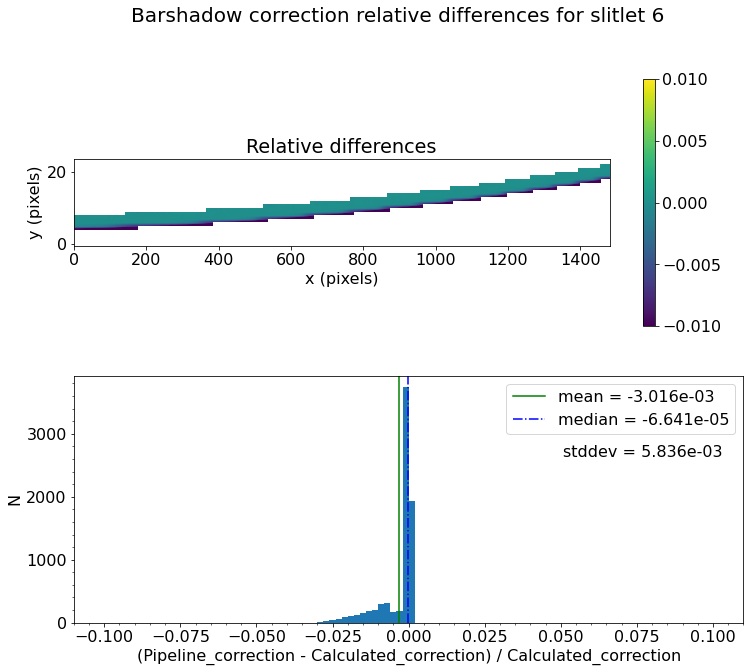


   Relative barshadow_correction  :   mean = -3.016e-03    median = -6.641e-05    stdev = 5.836e-03
    Maximum   Relativebarshadow_correction = 1.718e-03
    Minimum   Relativebarshadow_correction = -2.815e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 6? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  7
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


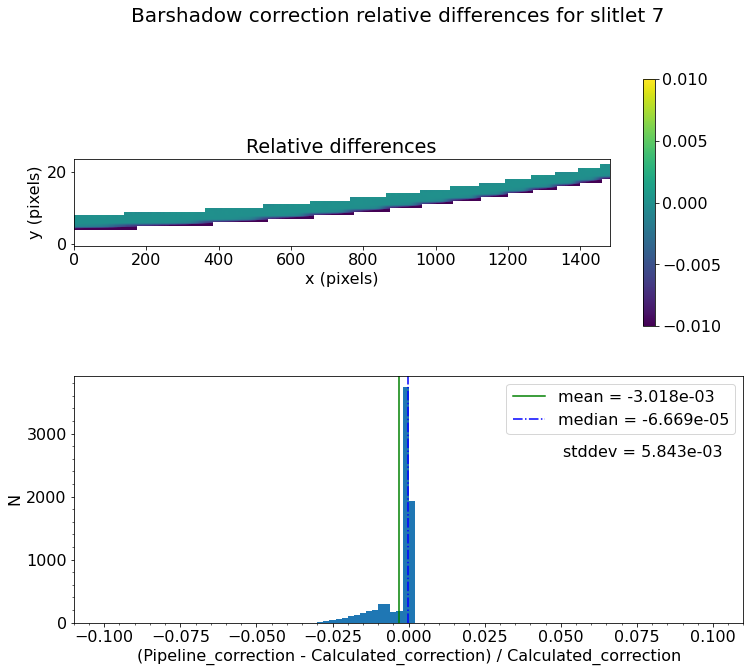


   Relative barshadow_correction  :   mean = -3.018e-03    median = -6.669e-05    stdev = 5.843e-03
    Maximum   Relativebarshadow_correction = 1.708e-03
    Minimum   Relativebarshadow_correction = -2.869e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 7? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  8
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


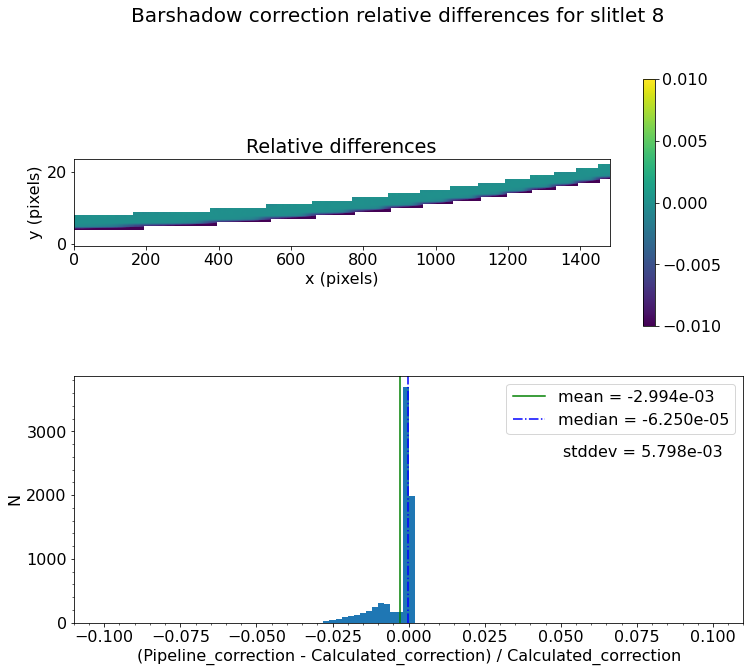


   Relative barshadow_correction  :   mean = -2.994e-03    median = -6.250e-05    stdev = 5.798e-03
    Maximum   Relativebarshadow_correction = 1.902e-03
    Minimum   Relativebarshadow_correction = -2.855e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 8? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  9
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations/

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


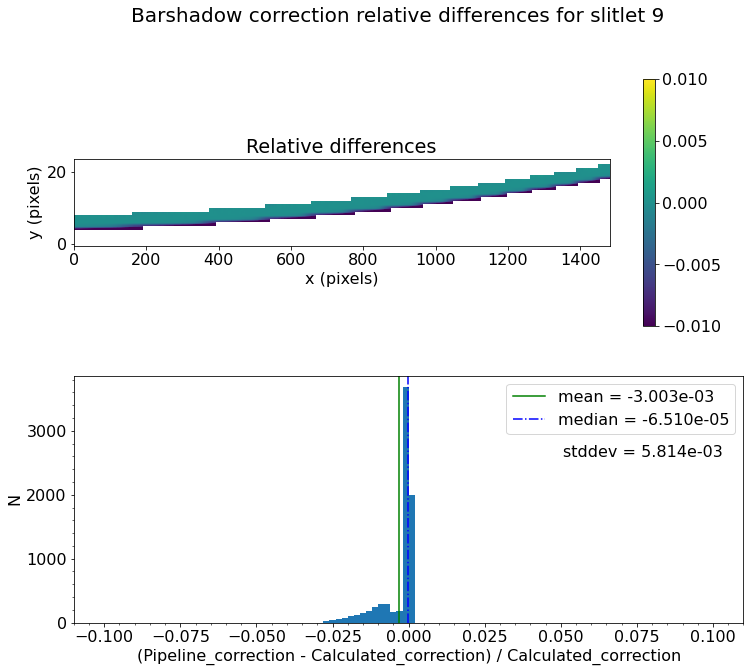


   Relative barshadow_correction  :   mean = -3.003e-03    median = -6.510e-05    stdev = 5.814e-03
    Maximum   Relativebarshadow_correction = 1.475e-03
    Minimum   Relativebarshadow_correction = -2.841e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 9? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  10
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


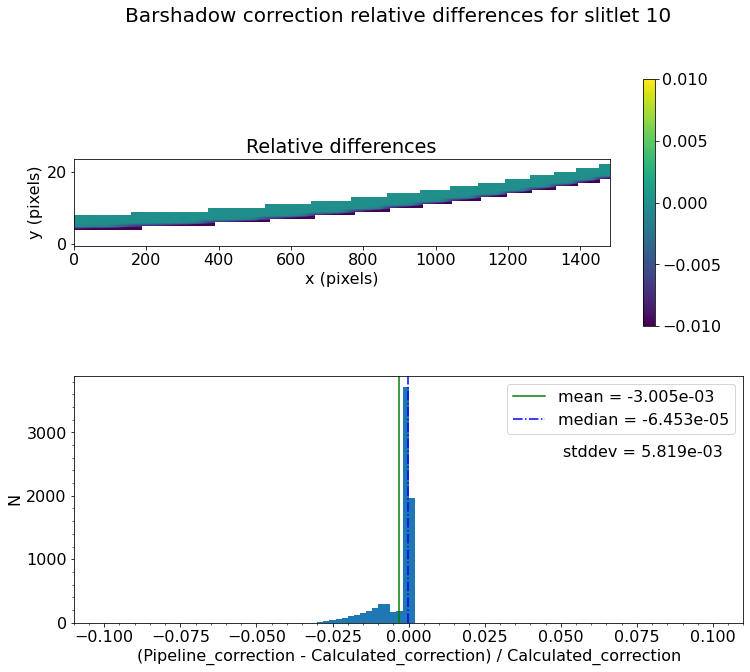


   Relative barshadow_correction  :   mean = -3.005e-03    median = -6.453e-05    stdev = 5.819e-03
    Maximum   Relativebarshadow_correction = 1.839e-03
    Minimum   Relativebarshadow_correction = -2.832e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 10? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  11
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


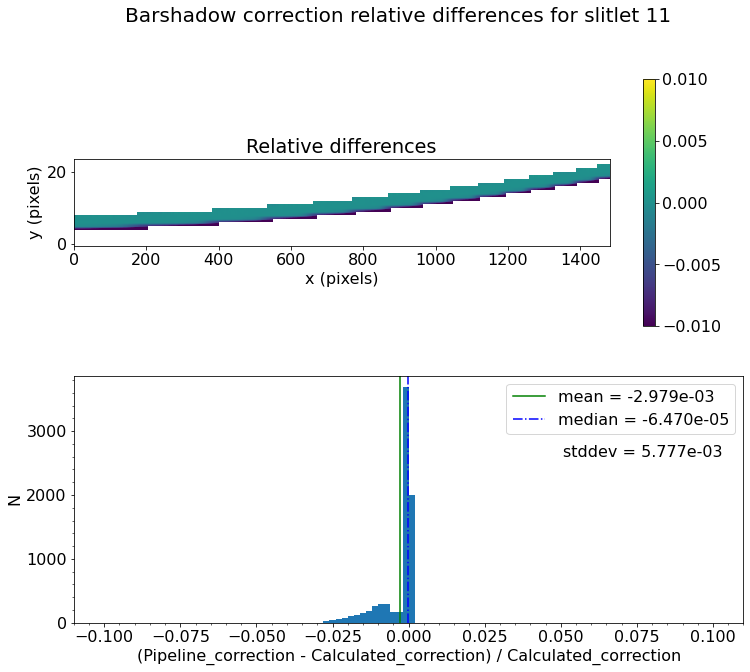


   Relative barshadow_correction  :   mean = -2.979e-03    median = -6.470e-05    stdev = 5.777e-03
    Maximum   Relativebarshadow_correction = 1.923e-03
    Minimum   Relativebarshadow_correction = -2.812e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 11? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  14
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


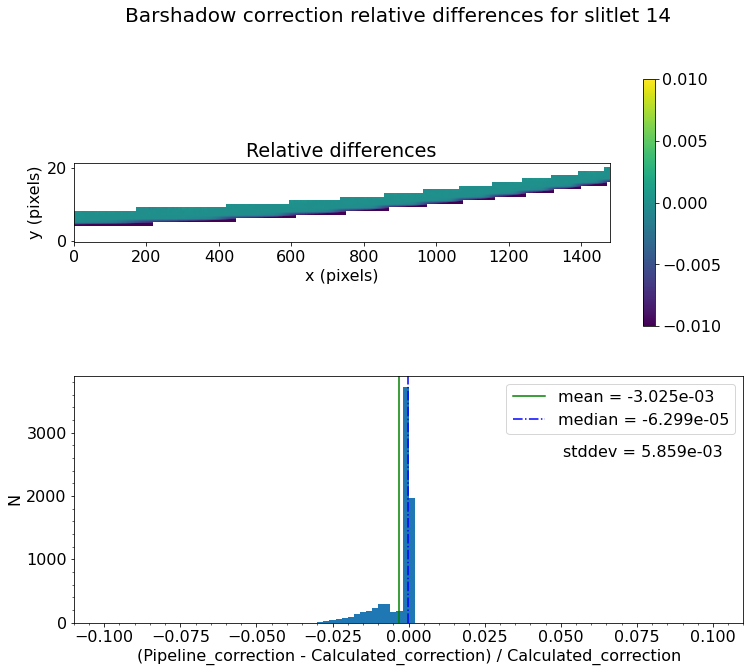


   Relative barshadow_correction  :   mean = -3.025e-03    median = -6.299e-05    stdev = 5.859e-03
    Maximum   Relativebarshadow_correction = 1.204e-03
    Minimum   Relativebarshadow_correction = -2.914e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 14? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  15
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


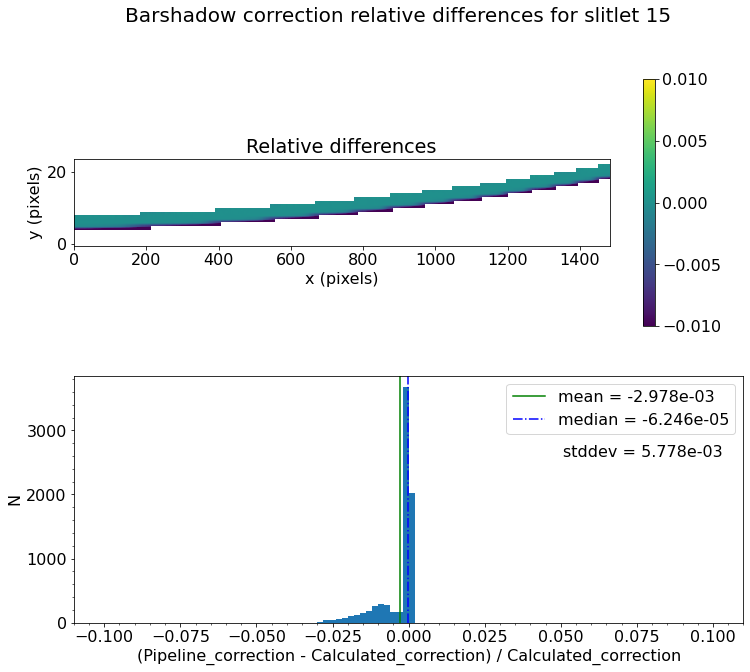


   Relative barshadow_correction  :   mean = -2.978e-03    median = -6.246e-05    stdev = 5.778e-03
    Maximum   Relativebarshadow_correction = 1.915e-03
    Minimum   Relativebarshadow_correction = -2.869e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 15? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  16
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


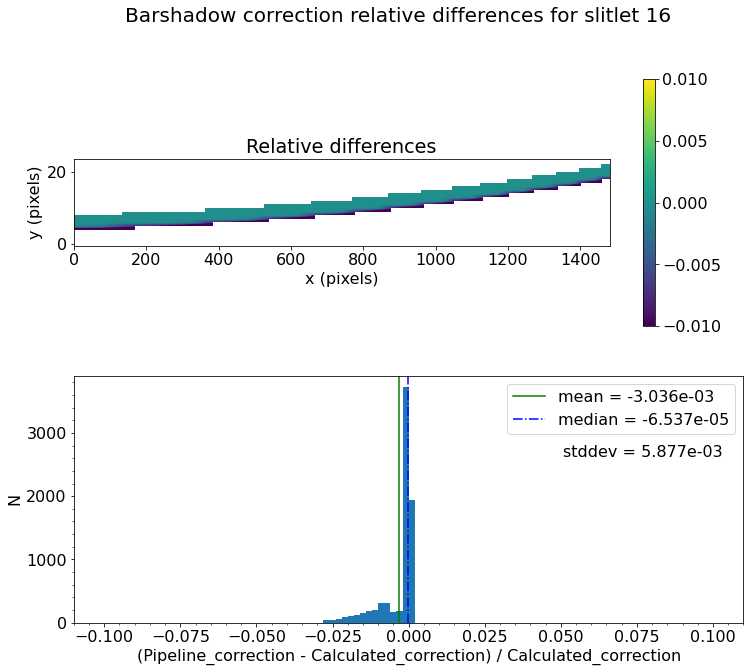


   Relative barshadow_correction  :   mean = -3.036e-03    median = -6.537e-05    stdev = 5.877e-03
    Maximum   Relativebarshadow_correction = 1.679e-03
    Minimum   Relativebarshadow_correction = -2.866e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 16? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  17
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


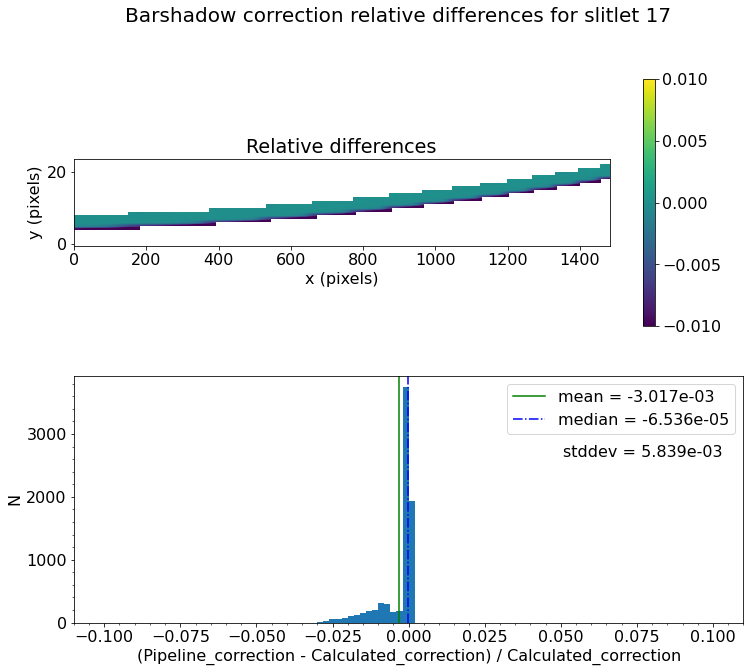


   Relative barshadow_correction  :   mean = -3.017e-03    median = -6.536e-05    stdev = 5.839e-03
    Maximum   Relativebarshadow_correction = 1.718e-03
    Minimum   Relativebarshadow_correction = -2.817e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 17? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  18
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


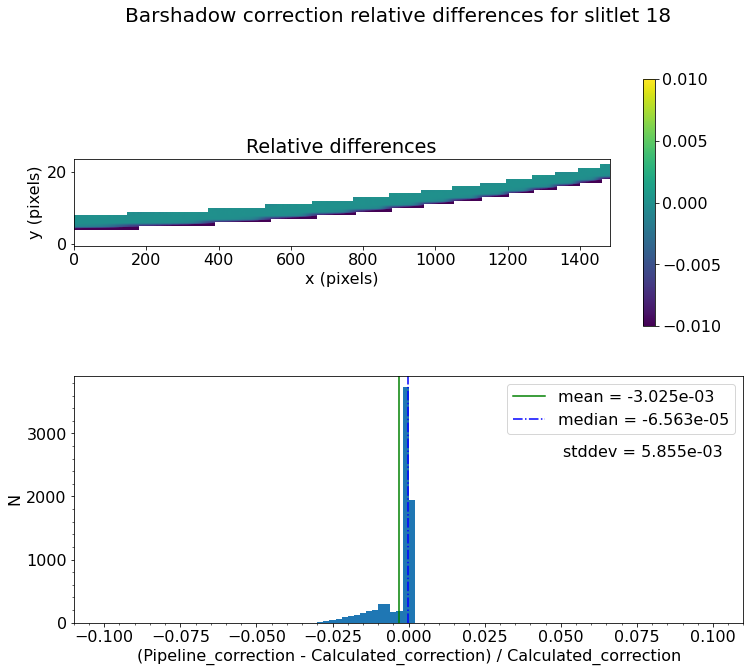


   Relative barshadow_correction  :   mean = -3.025e-03    median = -6.563e-05    stdev = 5.855e-03
    Maximum   Relativebarshadow_correction = 1.725e-03
    Minimum   Relativebarshadow_correction = -2.825e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 18? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  19
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


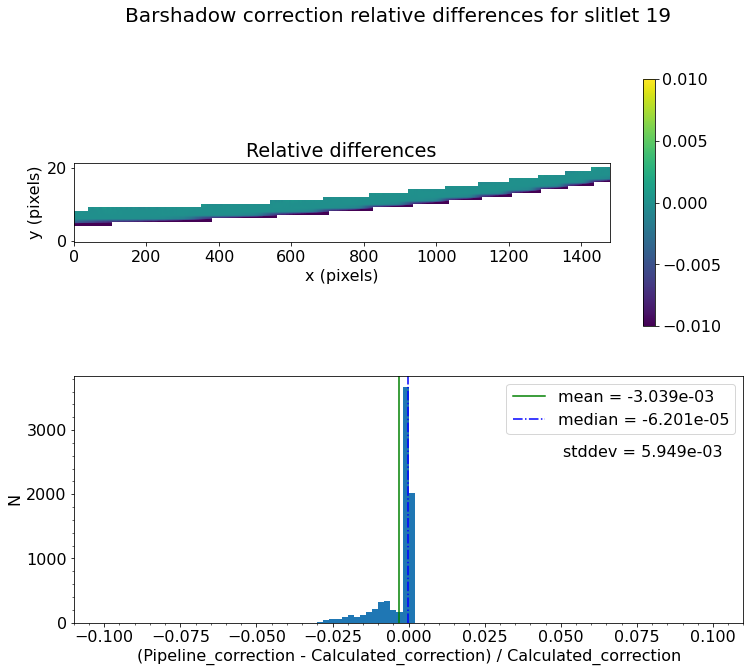


   Relative barshadow_correction  :   mean = -3.039e-03    median = -6.201e-05    stdev = 5.949e-03
    Maximum   Relativebarshadow_correction = 1.905e-03
    Minimum   Relativebarshadow_correction = -2.937e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 19? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  21
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


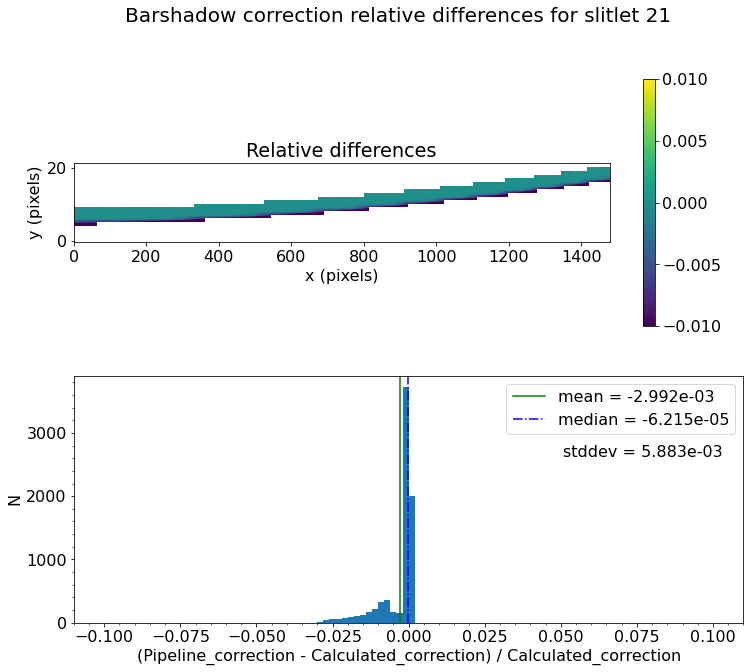


   Relative barshadow_correction  :   mean = -2.992e-03    median = -6.215e-05    stdev = 5.883e-03
    Maximum   Relativebarshadow_correction = 1.457e-03
    Minimum   Relativebarshadow_correction = -2.892e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 21? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  25
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


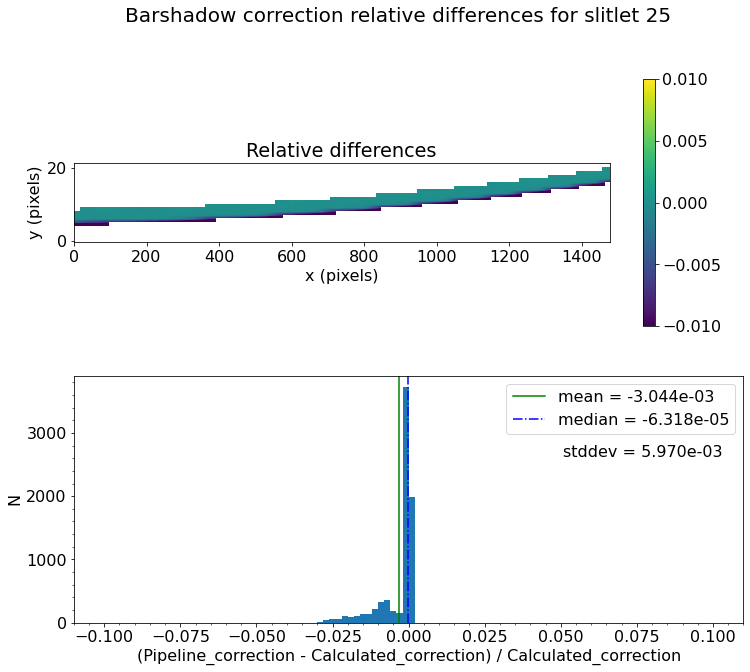


   Relative barshadow_correction  :   mean = -3.044e-03    median = -6.318e-05    stdev = 5.970e-03
    Maximum   Relativebarshadow_correction = 1.541e-03
    Minimum   Relativebarshadow_correction = -2.959e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 25? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  26
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...


Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations/5.3_BarShadow/referenceFilesBS-20160401/jwst-nirspec-mos1x1.bsrf.fits


Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


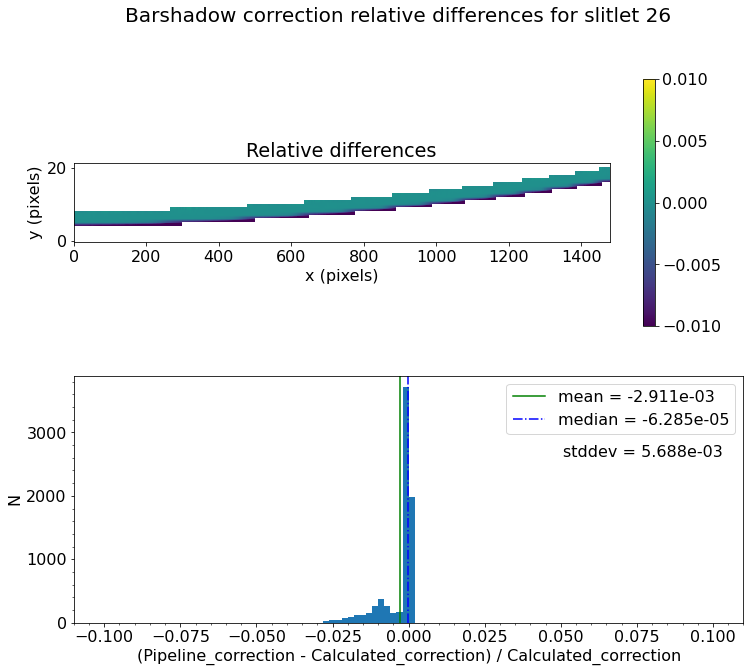


   Relative barshadow_correction  :   mean = -2.911e-03    median = -6.285e-05    stdev = 5.688e-03
    Maximum   Relativebarshadow_correction = 1.757e-03
    Minimum   Relativebarshadow_correction = -2.821e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 26? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  27
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


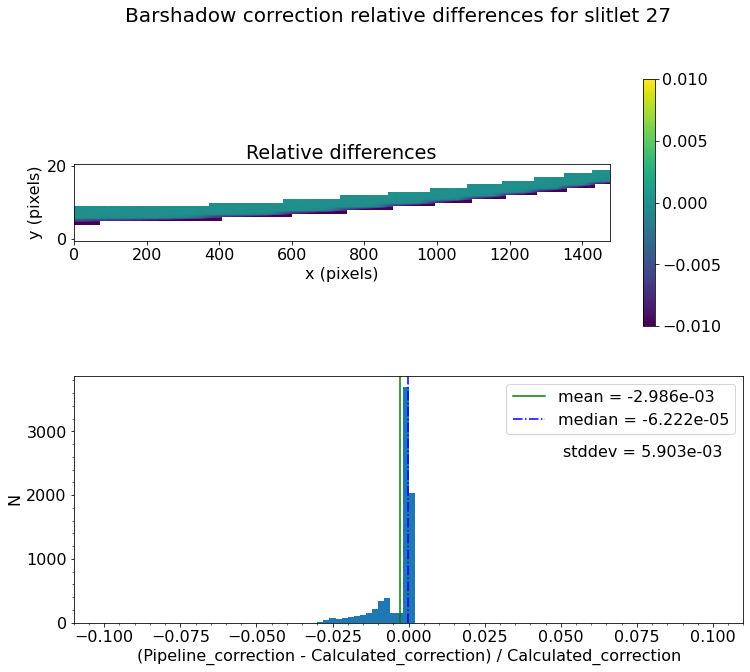


   Relative barshadow_correction  :   mean = -2.986e-03    median = -6.222e-05    stdev = 5.903e-03
    Maximum   Relativebarshadow_correction = 1.925e-03
    Minimum   Relativebarshadow_correction = -2.912e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 27? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  29
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


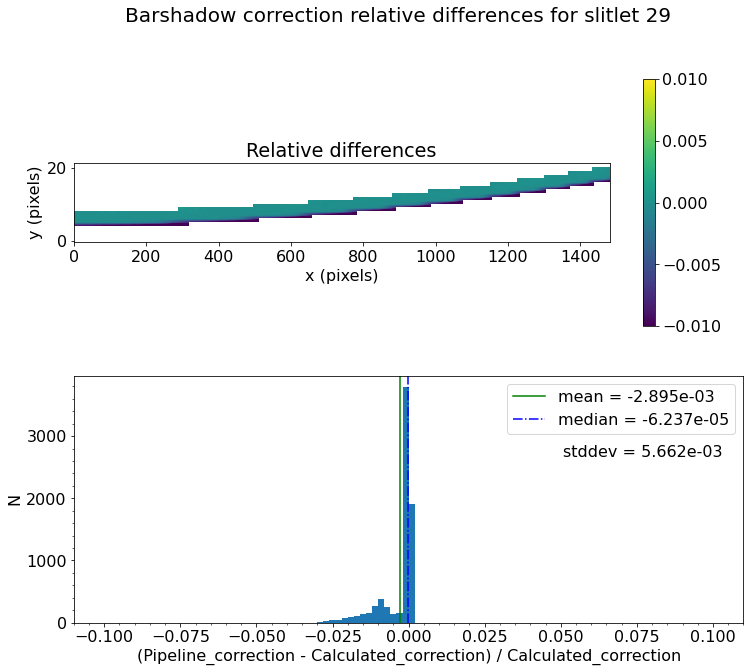


   Relative barshadow_correction  :   mean = -2.895e-03    median = -6.237e-05    stdev = 5.662e-03
    Maximum   Relativebarshadow_correction = 2.029e-03
    Minimum   Relativebarshadow_correction = -2.941e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 29? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  31
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


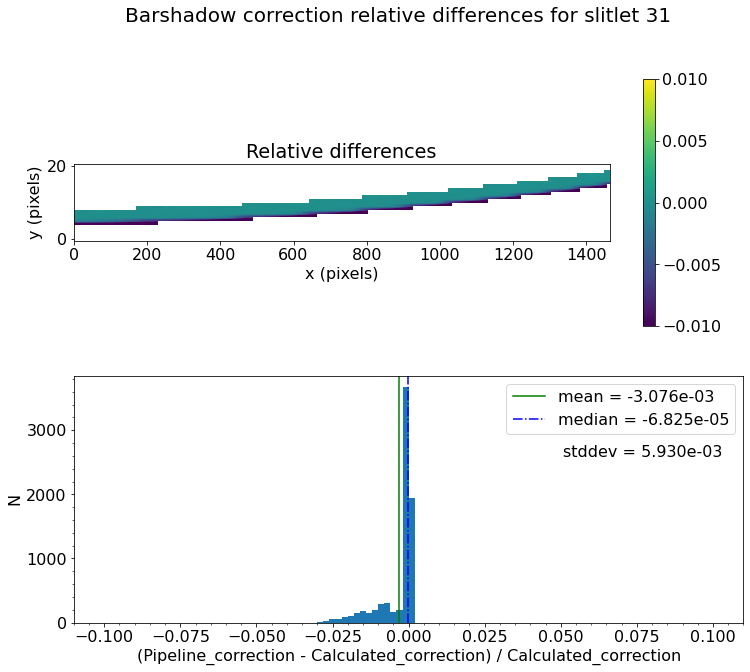


   Relative barshadow_correction  :   mean = -3.076e-03    median = -6.825e-05    stdev = 5.930e-03
    Maximum   Relativebarshadow_correction = 1.367e-03
    Minimum   Relativebarshadow_correction = -2.841e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 31? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  32
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


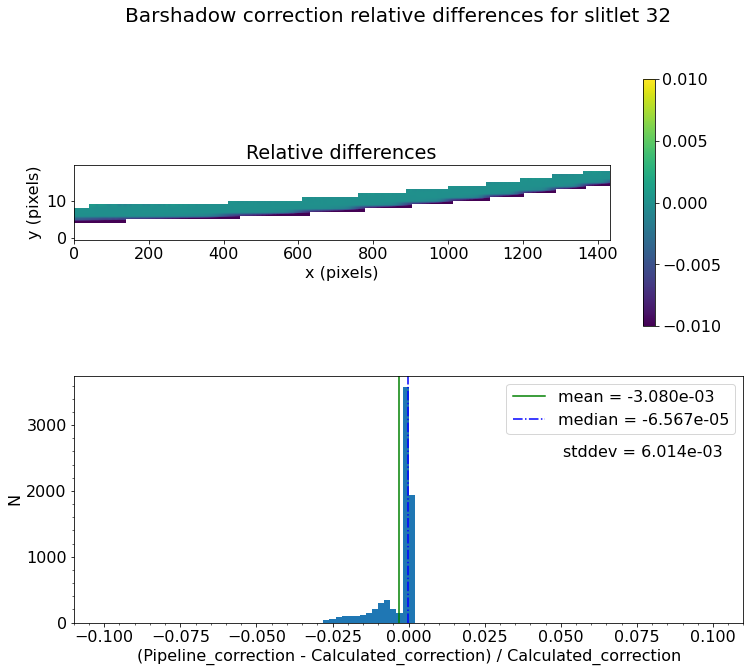


   Relative barshadow_correction  :   mean = -3.080e-03    median = -6.567e-05    stdev = 6.014e-03
    Maximum   Relativebarshadow_correction = 1.415e-03
    Minimum   Relativebarshadow_correction = -2.816e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 32? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  33
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


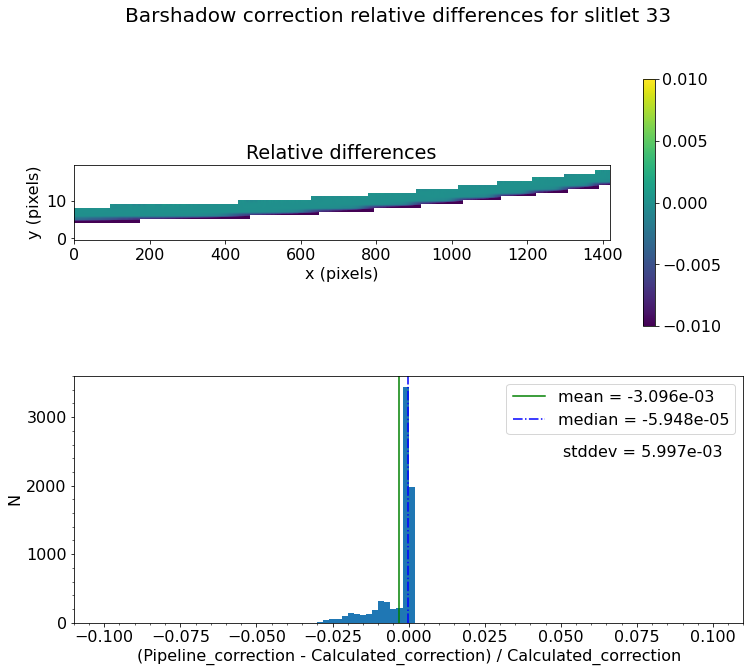


   Relative barshadow_correction  :   mean = -3.096e-03    median = -5.948e-05    stdev = 5.997e-03
    Maximum   Relativebarshadow_correction = 2.072e-03
    Minimum   Relativebarshadow_correction = -2.881e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 26%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 33? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  35
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


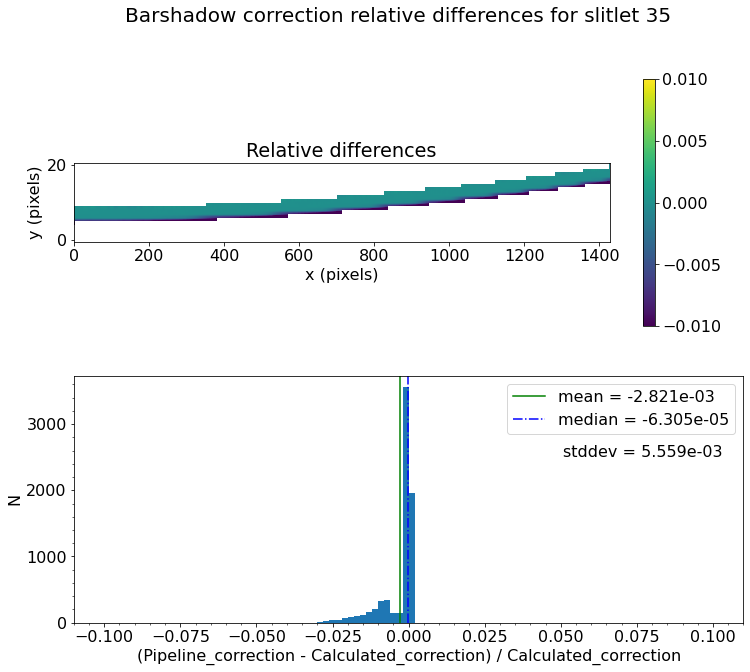


   Relative barshadow_correction  :   mean = -2.821e-03    median = -6.305e-05    stdev = 5.559e-03
    Maximum   Relativebarshadow_correction = 1.381e-03
    Minimum   Relativebarshadow_correction = -2.871e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 35? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  37
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


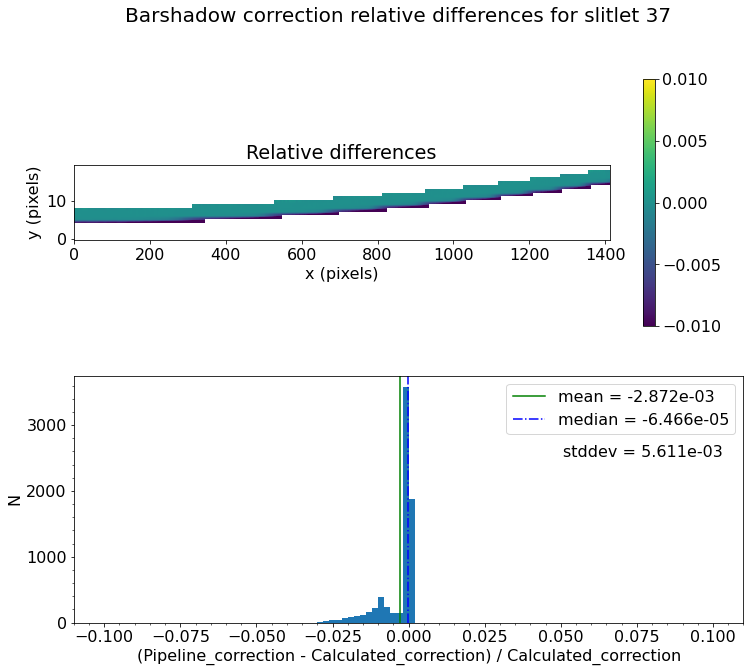


   Relative barshadow_correction  :   mean = -2.872e-03    median = -6.466e-05    stdev = 5.611e-03
    Maximum   Relativebarshadow_correction = 1.789e-03
    Minimum   Relativebarshadow_correction = -2.886e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 37? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  38
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


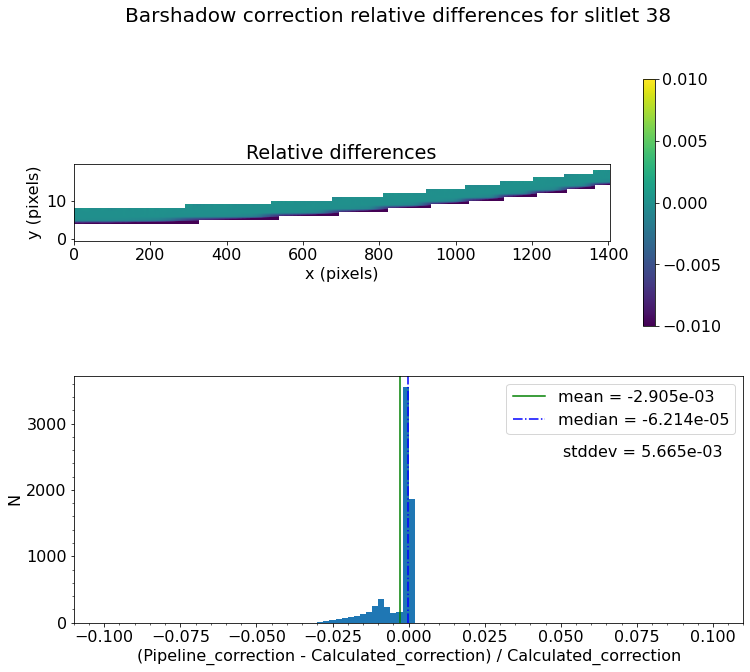


   Relative barshadow_correction  :   mean = -2.905e-03    median = -6.214e-05    stdev = 5.665e-03
    Maximum   Relativebarshadow_correction = 2.042e-03
    Minimum   Relativebarshadow_correction = -2.930e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 38? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  39
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


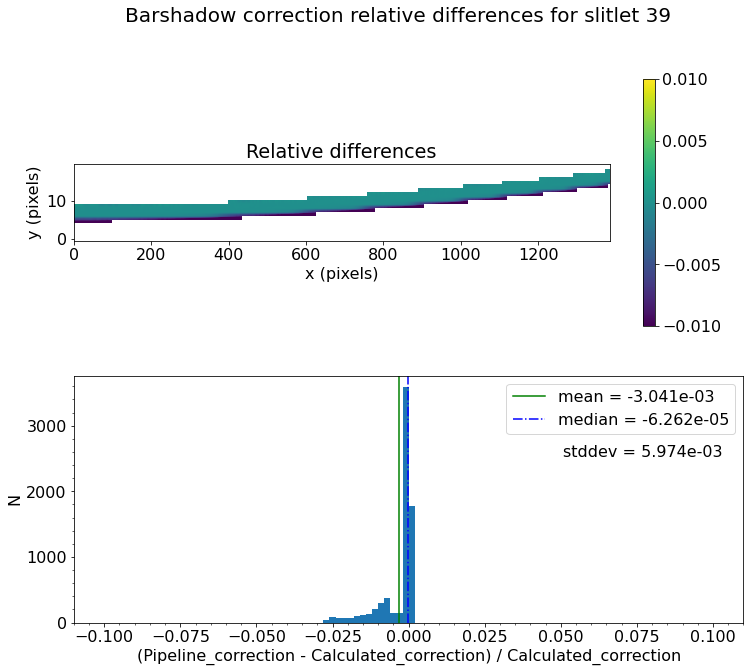


   Relative barshadow_correction  :   mean = -3.041e-03    median = -6.262e-05    stdev = 5.974e-03
    Maximum   Relativebarshadow_correction = 1.176e-03
    Minimum   Relativebarshadow_correction = -2.788e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 39? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  41
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


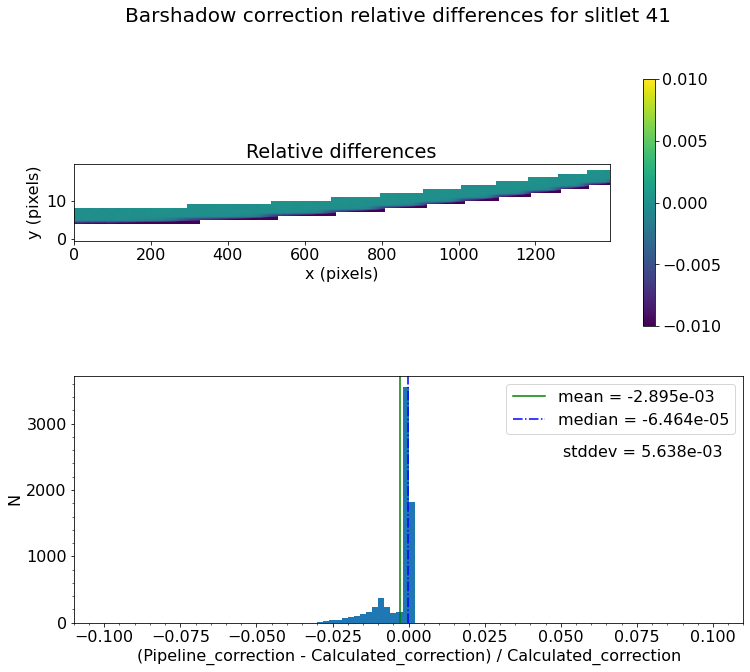


   Relative barshadow_correction  :   mean = -2.895e-03    median = -6.464e-05    stdev = 5.638e-03
    Maximum   Relativebarshadow_correction = 1.679e-03
    Minimum   Relativebarshadow_correction = -2.888e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 41? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  53
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Calculation of barshadow correction done.
429.4560241214042 26.8976157966487
Creating final barshadow test plot...


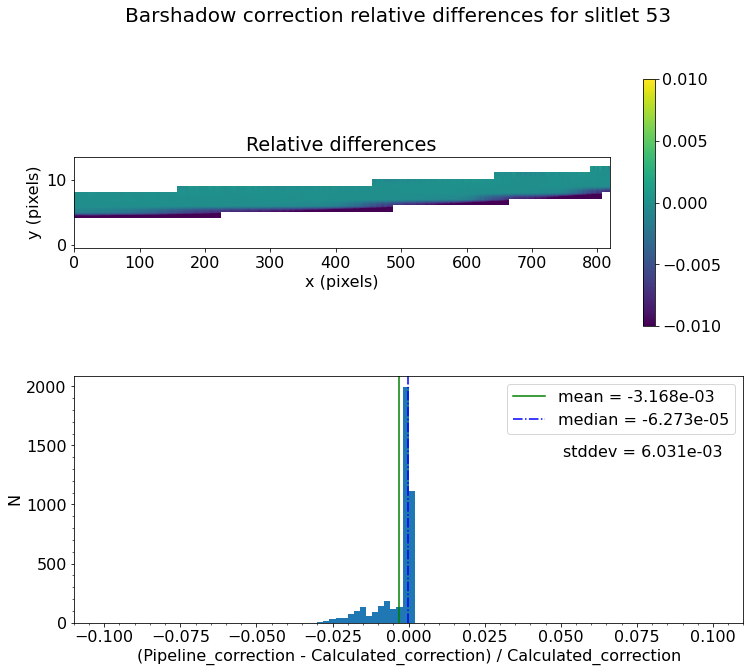


   Relative barshadow_correction  :   mean = -3.168e-03    median = -6.273e-05    stdev = 6.031e-03
    Maximum   Relativebarshadow_correction = 1.761e-03
    Minimum   Relativebarshadow_correction = -2.824e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 26%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 11%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 53? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  54
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...


/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations/5.3_BarShadow/referenceFilesBS-20160401/jwst-nirspec-mos1x1.bsrf.fits


Calculation of barshadow correction done.
426.2587209927364 26.903679487152
Creating final barshadow test plot...


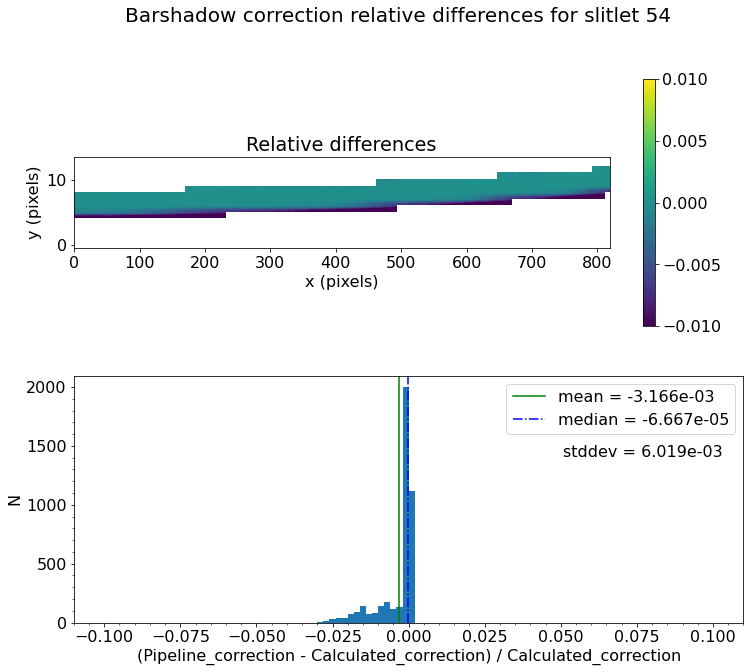


   Relative barshadow_correction  :   mean = -3.166e-03    median = -6.667e-05    stdev = 6.019e-03
    Maximum   Relativebarshadow_correction = 1.585e-03
    Minimum   Relativebarshadow_correction = -2.815e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 26%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 11%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 54? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  1
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


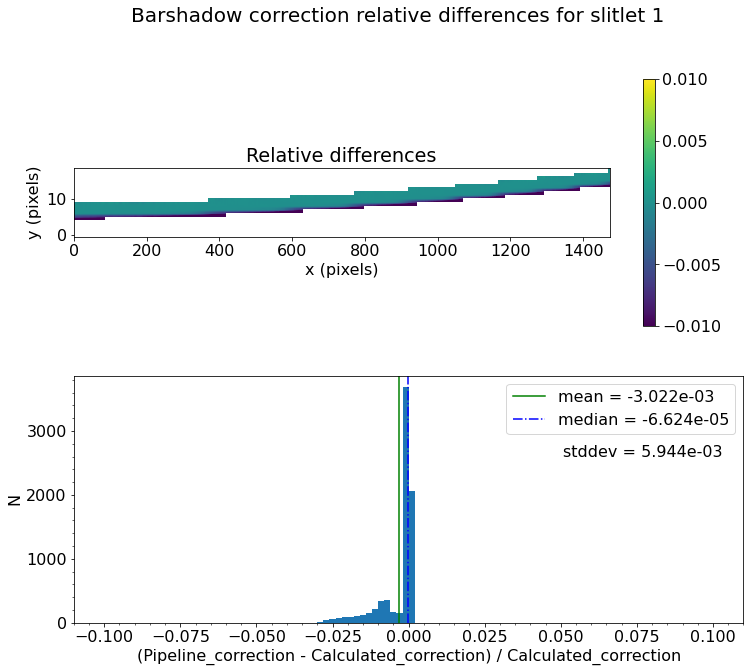


   Relative barshadow_correction  :   mean = -3.022e-03    median = -6.624e-05    stdev = 5.944e-03
    Maximum   Relativebarshadow_correction = 1.209e-03
    Minimum   Relativebarshadow_correction = -2.936e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 1? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  2
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations/

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


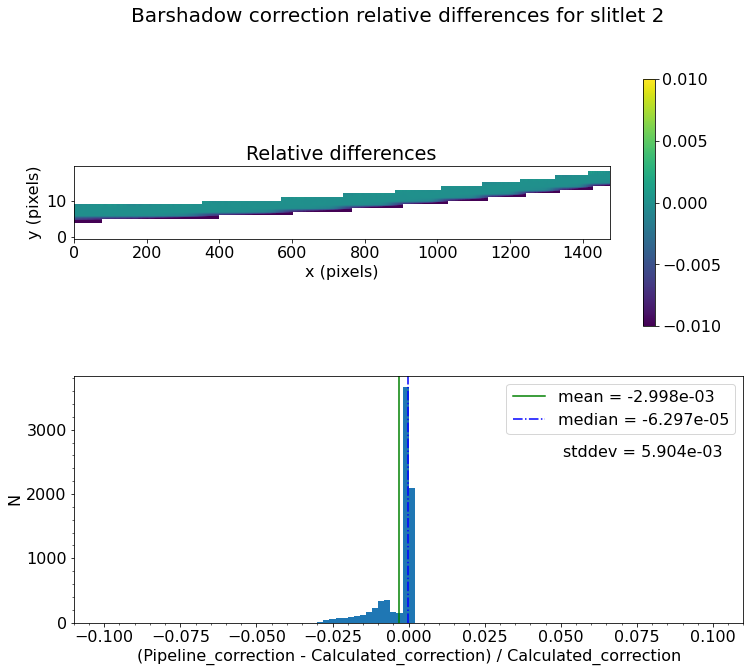


   Relative barshadow_correction  :   mean = -2.998e-03    median = -6.297e-05    stdev = 5.904e-03
    Maximum   Relativebarshadow_correction = 1.782e-03
    Minimum   Relativebarshadow_correction = -2.922e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 2? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  3
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations/

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


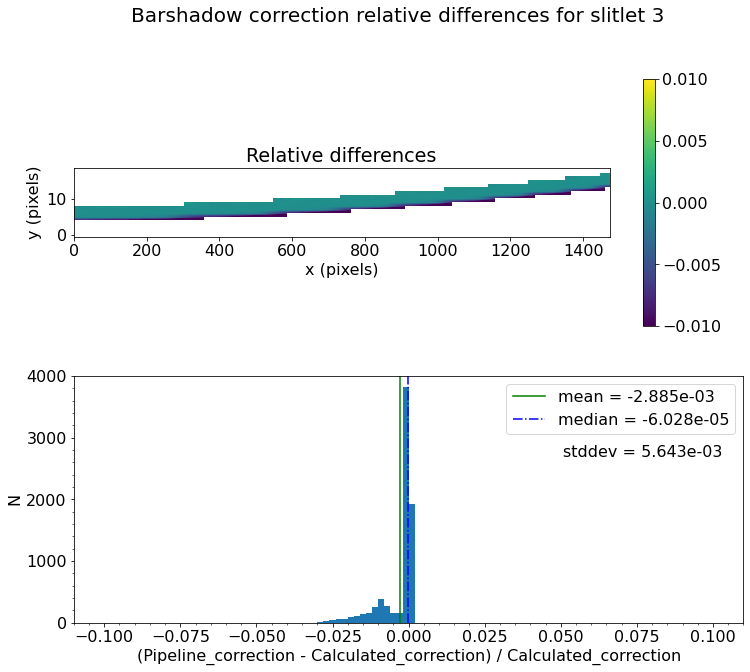


   Relative barshadow_correction  :   mean = -2.885e-03    median = -6.028e-05    stdev = 5.643e-03
    Maximum   Relativebarshadow_correction = 1.703e-03
    Minimum   Relativebarshadow_correction = -2.868e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 3? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  4
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations/

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


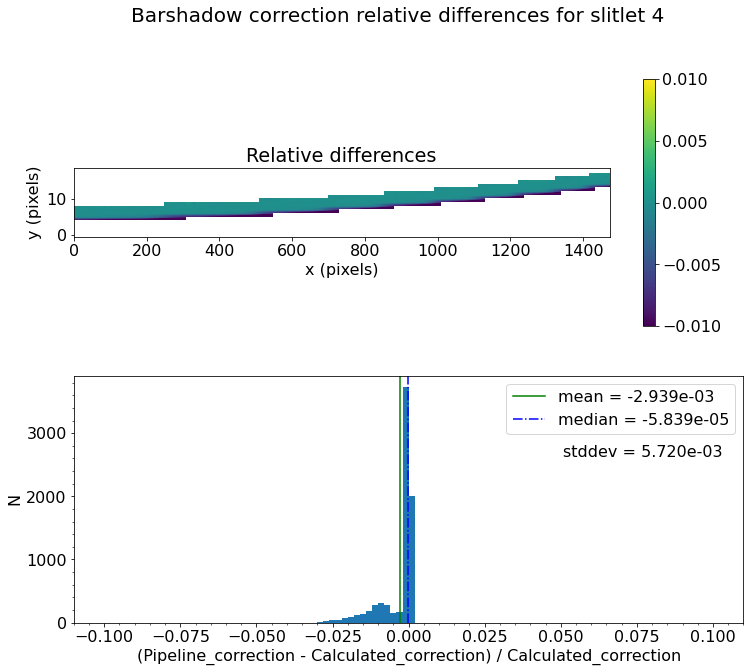


   Relative barshadow_correction  :   mean = -2.939e-03    median = -5.839e-05    stdev = 5.720e-03
    Maximum   Relativebarshadow_correction = 1.743e-03
    Minimum   Relativebarshadow_correction = -2.875e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 4? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  5
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations/

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


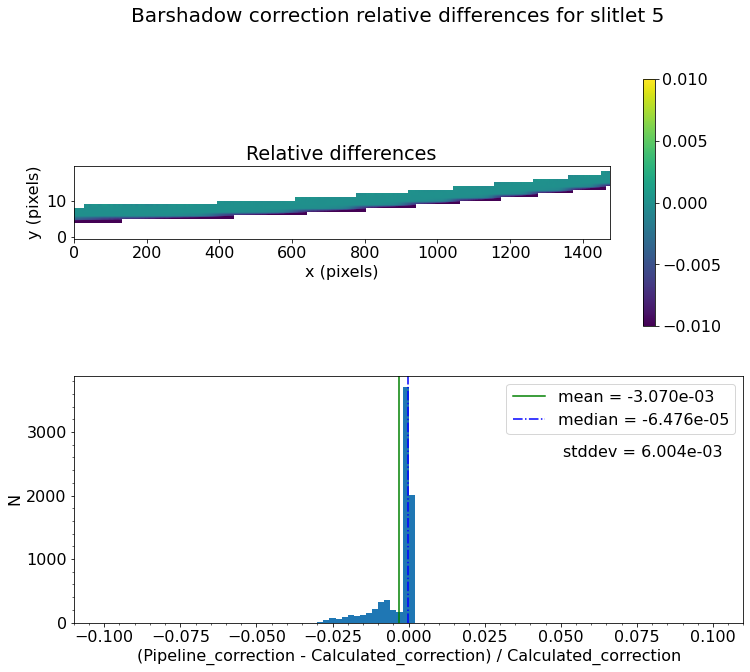


   Relative barshadow_correction  :   mean = -3.070e-03    median = -6.476e-05    stdev = 6.004e-03
    Maximum   Relativebarshadow_correction = 1.519e-03
    Minimum   Relativebarshadow_correction = -2.908e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 5? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  12
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


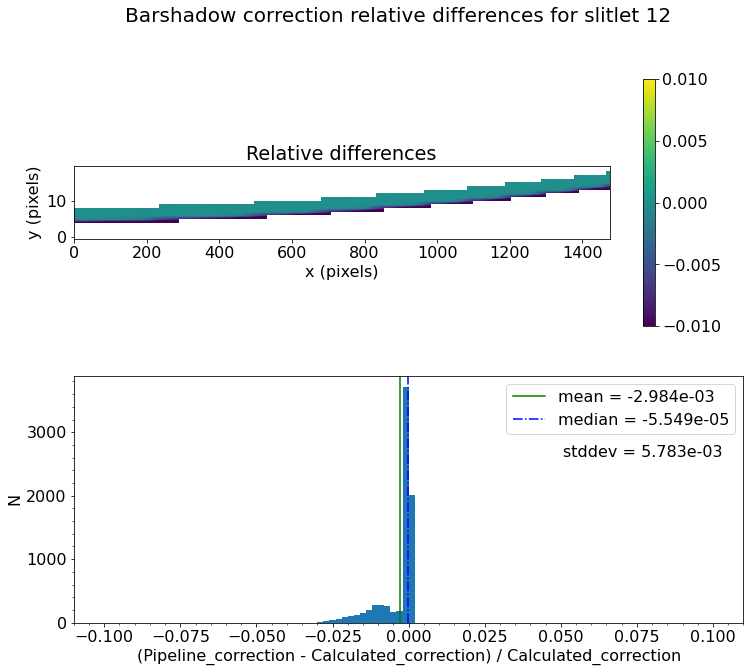


   Relative barshadow_correction  :   mean = -2.984e-03    median = -5.549e-05    stdev = 5.783e-03
    Maximum   Relativebarshadow_correction = 1.209e-03
    Minimum   Relativebarshadow_correction = -2.851e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 12? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  13
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


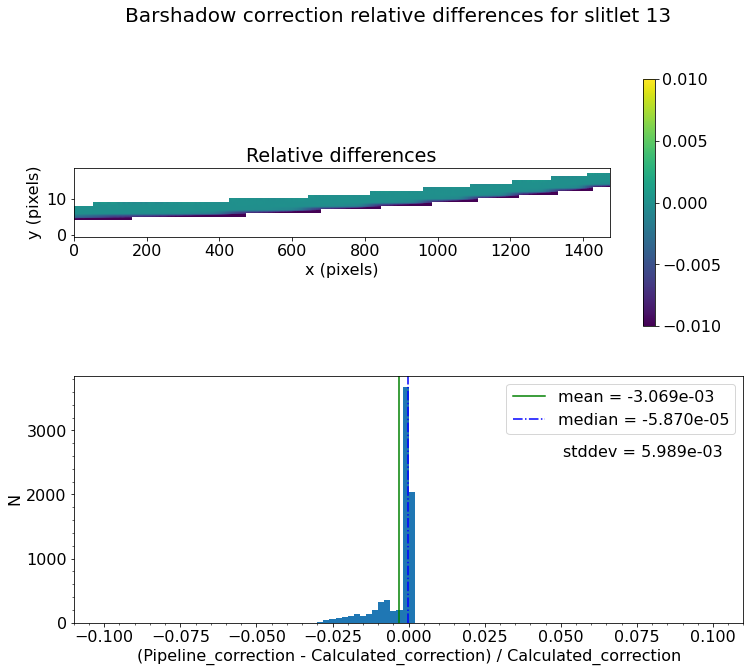


   Relative barshadow_correction  :   mean = -3.069e-03    median = -5.870e-05    stdev = 5.989e-03
    Maximum   Relativebarshadow_correction = 1.744e-03
    Minimum   Relativebarshadow_correction = -2.906e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 26%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 13? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  20
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


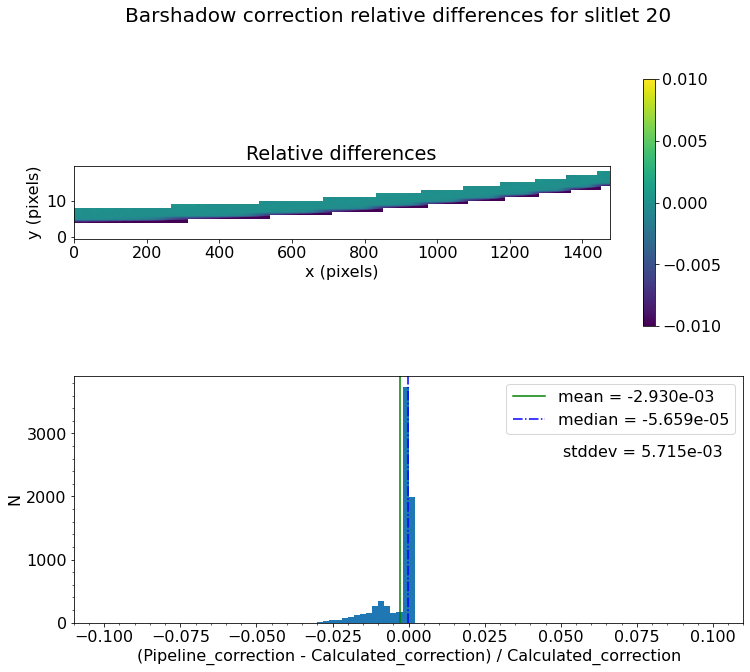


   Relative barshadow_correction  :   mean = -2.930e-03    median = -5.659e-05    stdev = 5.715e-03
    Maximum   Relativebarshadow_correction = 1.938e-03
    Minimum   Relativebarshadow_correction = -2.900e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 20? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  22
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


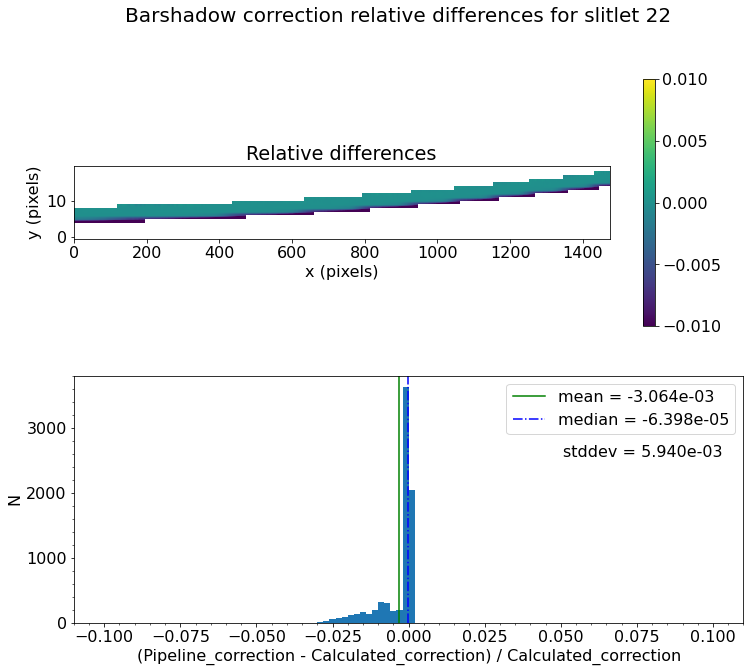


   Relative barshadow_correction  :   mean = -3.064e-03    median = -6.398e-05    stdev = 5.940e-03
    Maximum   Relativebarshadow_correction = 2.135e-03
    Minimum   Relativebarshadow_correction = -2.875e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 22? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  23
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


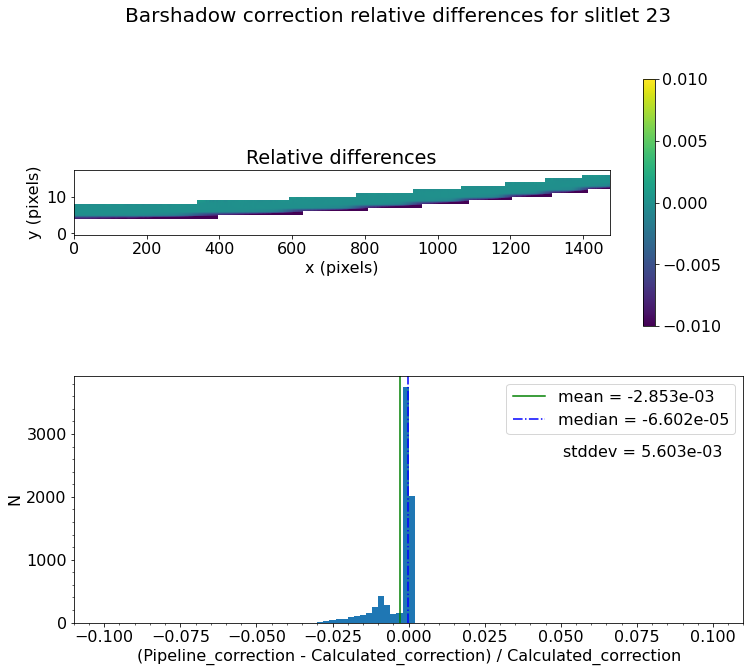


   Relative barshadow_correction  :   mean = -2.853e-03    median = -6.602e-05    stdev = 5.603e-03
    Maximum   Relativebarshadow_correction = 1.440e-03
    Minimum   Relativebarshadow_correction = -2.852e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 23? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  24
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


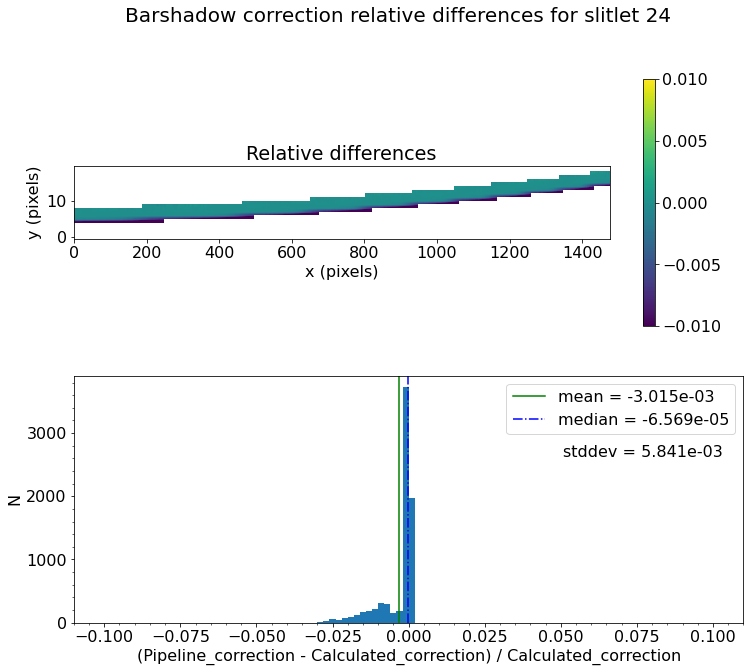


   Relative barshadow_correction  :   mean = -3.015e-03    median = -6.569e-05    stdev = 5.841e-03
    Maximum   Relativebarshadow_correction = 1.784e-03
    Minimum   Relativebarshadow_correction = -2.835e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 24? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  28
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.


Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibrations/5.3_BarShadow/referenceFilesBS-20160401/jwst-nirspec-mos1x1.bsrf.fits


Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


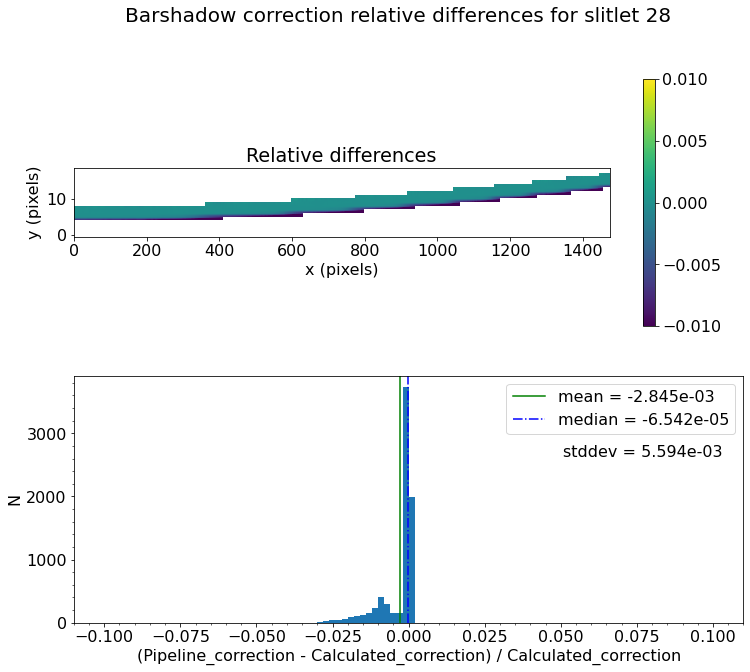


   Relative barshadow_correction  :   mean = -2.845e-03    median = -6.542e-05    stdev = 5.594e-03
    Maximum   Relativebarshadow_correction = 1.789e-03
    Minimum   Relativebarshadow_correction = -2.914e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 28? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  30
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


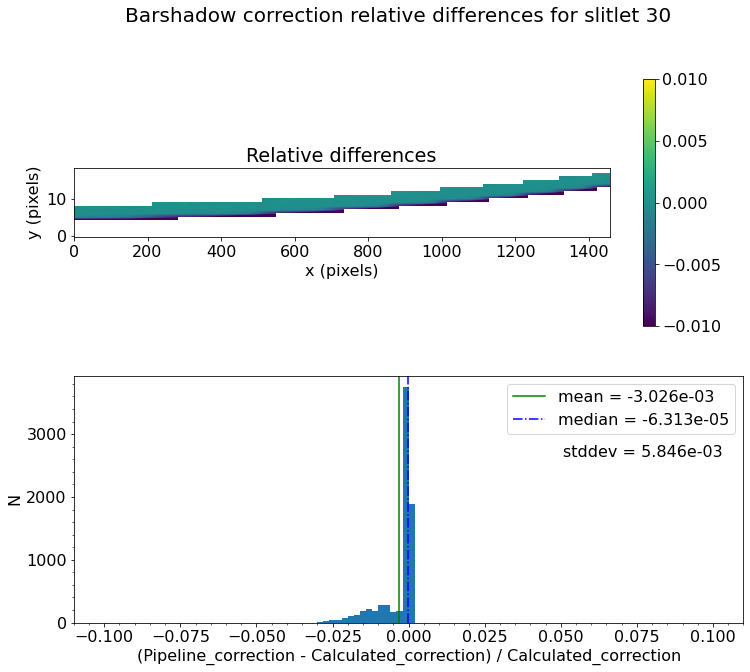


   Relative barshadow_correction  :   mean = -3.026e-03    median = -6.313e-05    stdev = 5.846e-03
    Maximum   Relativebarshadow_correction = 1.936e-03
    Minimum   Relativebarshadow_correction = -2.923e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 30? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  34
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


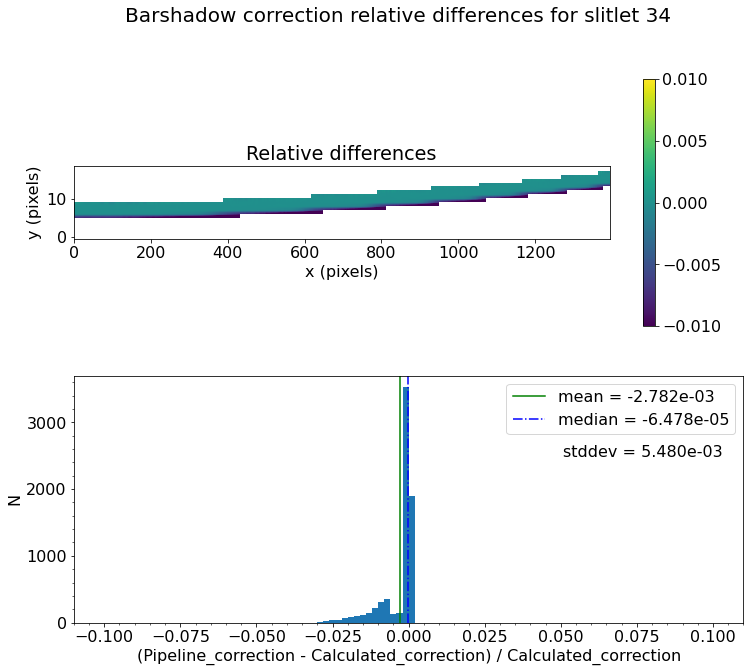


   Relative barshadow_correction  :   mean = -2.782e-03    median = -6.478e-05    stdev = 5.480e-03
    Maximum   Relativebarshadow_correction = 1.829e-03
    Minimum   Relativebarshadow_correction = -2.852e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 17%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 34? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  36
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


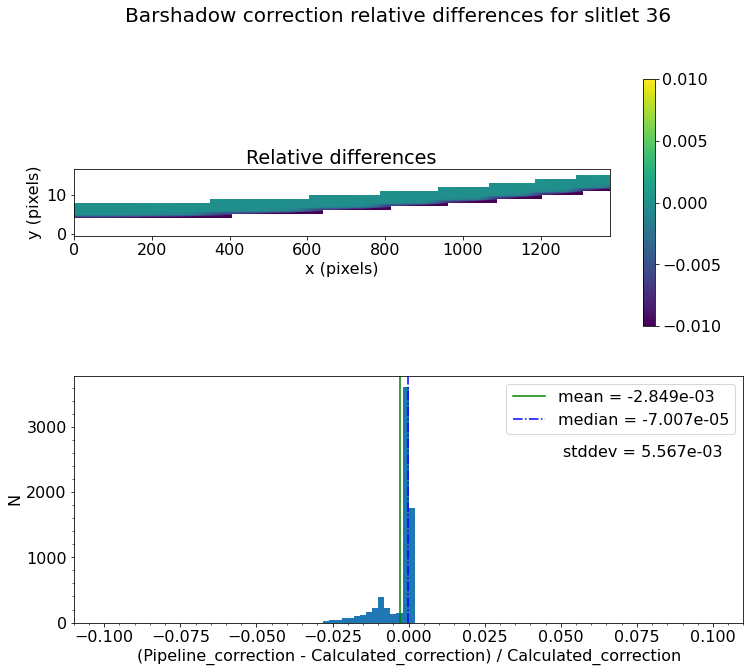


   Relative barshadow_correction  :   mean = -2.849e-03    median = -7.007e-05    stdev = 5.567e-03
    Maximum   Relativebarshadow_correction = 1.244e-03
    Minimum   Relativebarshadow_correction = -2.806e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 36? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  40
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
717.8478879652469 26.906201801445103
Creating final barshadow test plot...


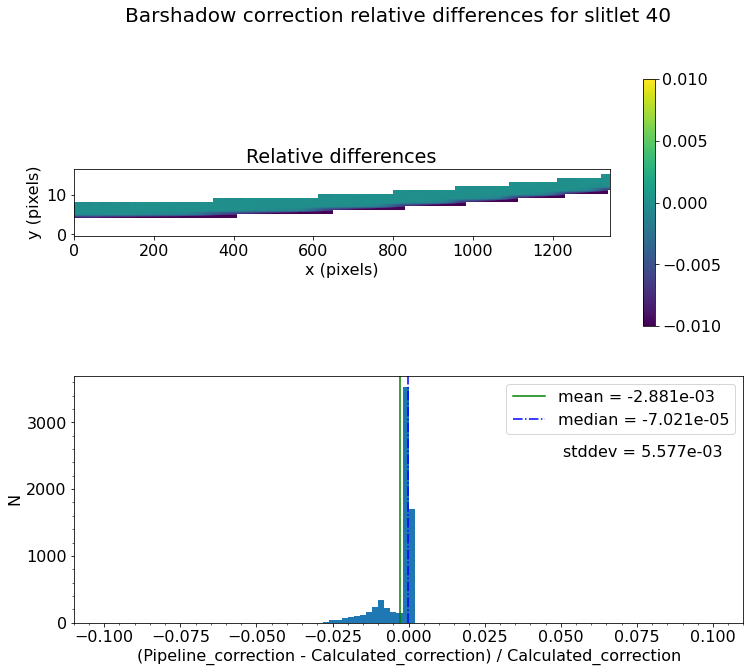


   Relative barshadow_correction  :   mean = -2.881e-03    median = -7.021e-05    stdev = 5.577e-03
    Maximum   Relativebarshadow_correction = 1.526e-03
    Minimum   Relativebarshadow_correction = -2.796e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 40? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  42
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
736.5492365260191 26.907388994041778
Creating final barshadow test plot...


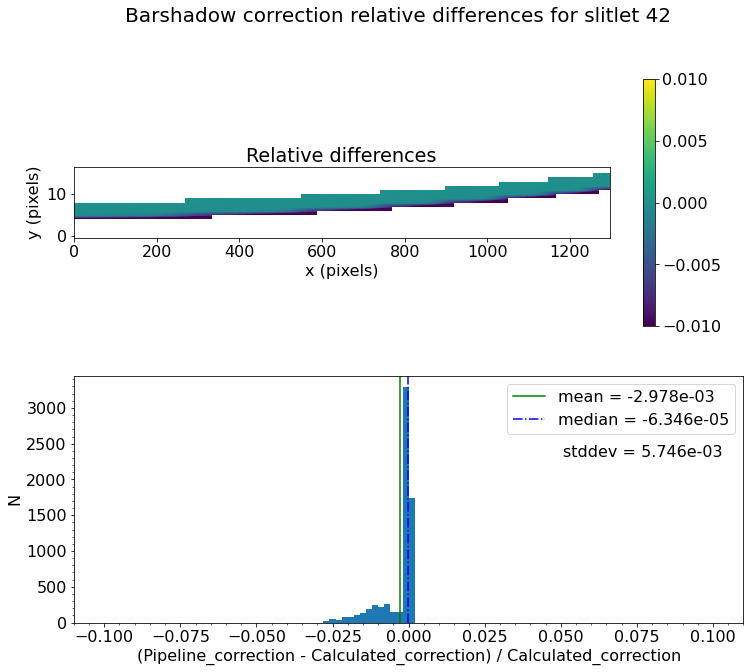


   Relative barshadow_correction  :   mean = -2.978e-03    median = -6.346e-05    stdev = 5.746e-03
    Maximum   Relativebarshadow_correction = 2.072e-03
    Minimum   Relativebarshadow_correction = -2.791e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 42? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  43
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

Calculation of barshadow correction done.
689.9349073679869 26.898072914723645
Creating final barshadow test plot...


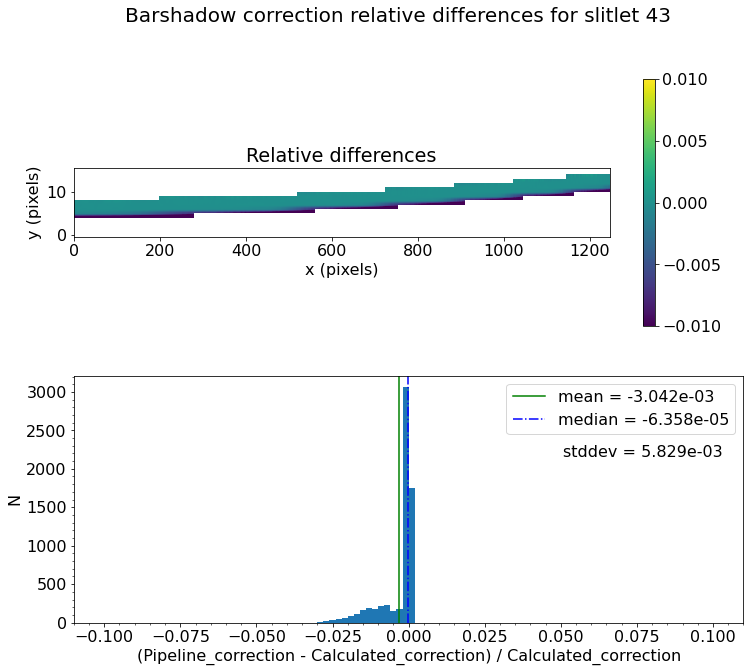


   Relative barshadow_correction  :   mean = -3.042e-03    median = -6.358e-05    stdev = 5.829e-03
    Maximum   Relativebarshadow_correction = 1.221e-03
    Minimum   Relativebarshadow_correction = -2.884e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 11%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 43? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  44
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Referenc

Calculation of barshadow correction done.
679.9641907876581 26.902628246867557
Creating final barshadow test plot...


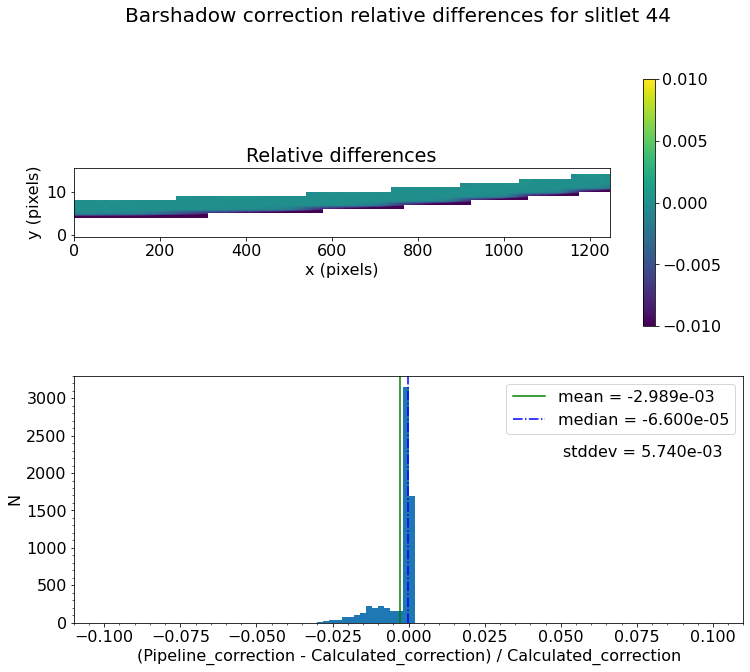


   Relative barshadow_correction  :   mean = -2.989e-03    median = -6.600e-05    stdev = 5.740e-03
    Maximum   Relativebarshadow_correction = 1.406e-03
    Minimum   Relativebarshadow_correction = -2.910e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 44? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  45
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Calculation of barshadow correction done.
675.2201065606389 26.909022673391682
Creating final barshadow test plot...


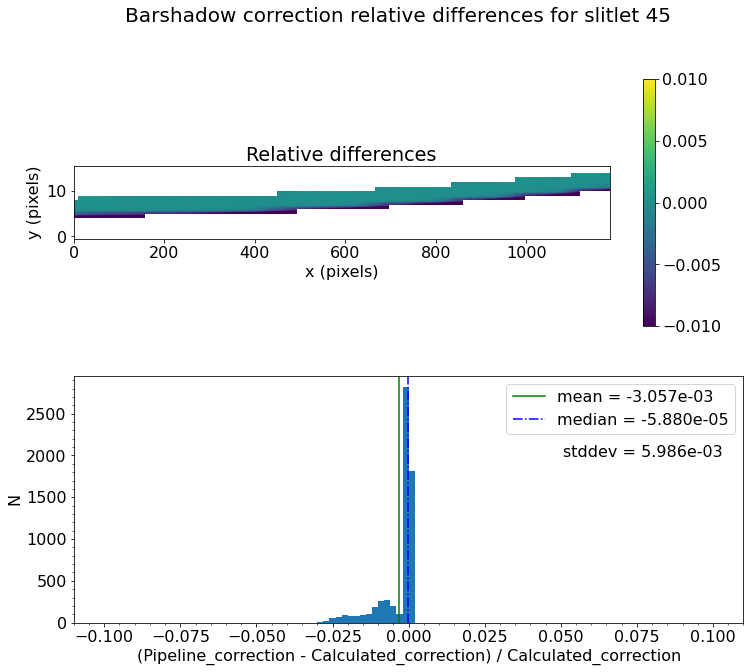


   Relative barshadow_correction  :   mean = -3.057e-03    median = -5.880e-05    stdev = 5.986e-03
    Maximum   Relativebarshadow_correction = 1.425e-03
    Minimum   Relativebarshadow_correction = -2.889e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 45? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  46
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Calculation of barshadow correction done.
628.3528797143198 26.907387263499682
Creating final barshadow test plot...


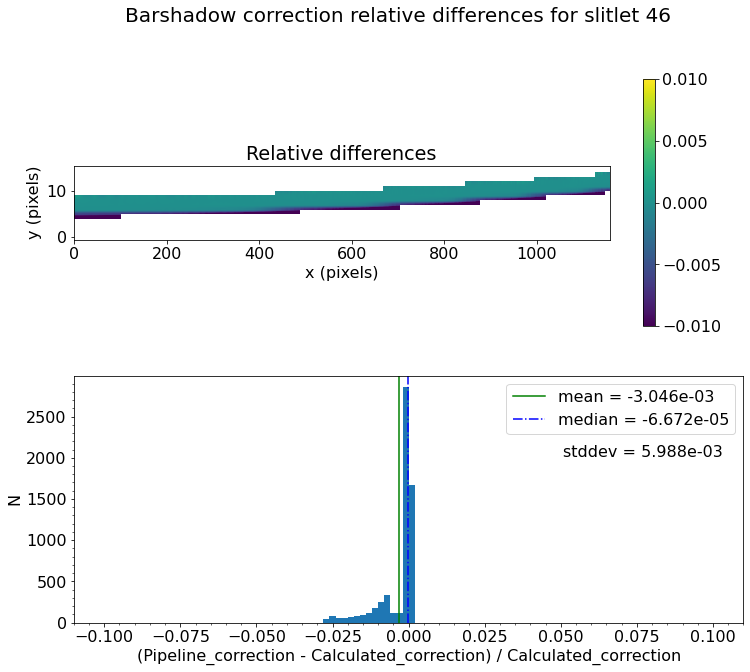


   Relative barshadow_correction  :   mean = -3.046e-03    median = -6.672e-05    stdev = 5.988e-03
    Maximum   Relativebarshadow_correction = 1.793e-03
    Minimum   Relativebarshadow_correction = -2.787e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 9%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 46? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  47
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Calculation of barshadow correction done.
566.0835177748166 26.901105539942886
Creating final barshadow test plot...


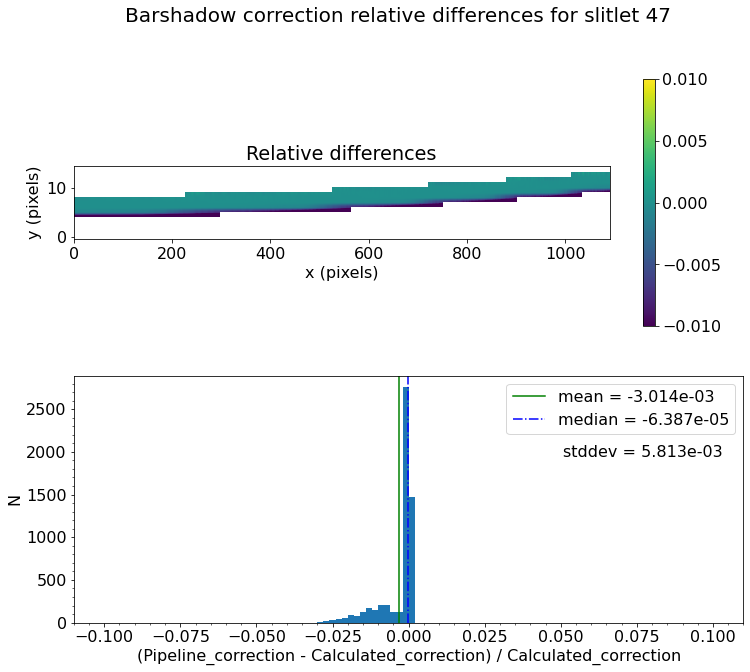


   Relative barshadow_correction  :   mean = -3.014e-03    median = -6.387e-05    stdev = 5.813e-03
    Maximum   Relativebarshadow_correction = 1.517e-03
    Minimum   Relativebarshadow_correction = -2.902e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 47? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  48
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Calculation of barshadow correction done.
561.7669238150397 26.903533880206133
Creating final barshadow test plot...


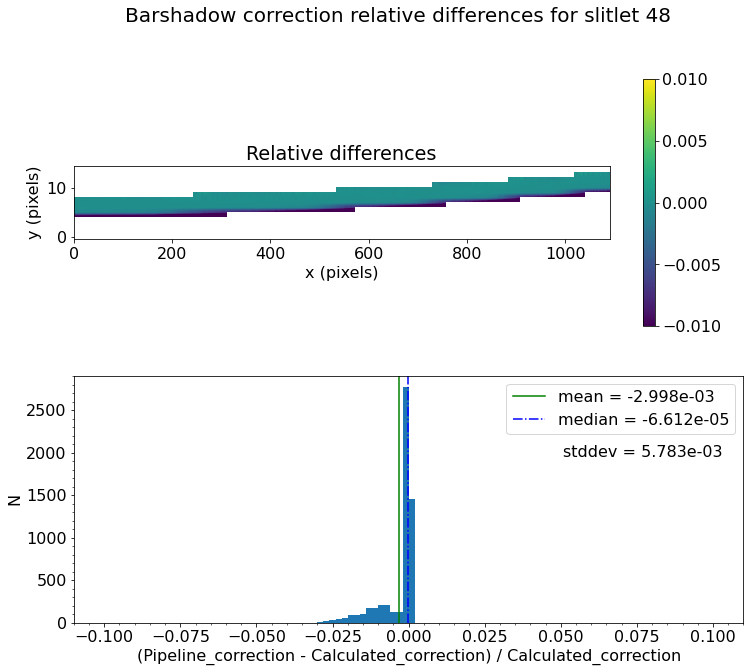


   Relative barshadow_correction  :   mean = -2.998e-03    median = -6.612e-05    stdev = 5.783e-03
    Maximum   Relativebarshadow_correction = 1.651e-03
    Minimum   Relativebarshadow_correction = -2.877e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 48? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  49
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Calculation of barshadow correction done.
510.5417110307708 26.89942162711025
Creating final barshadow test plot...


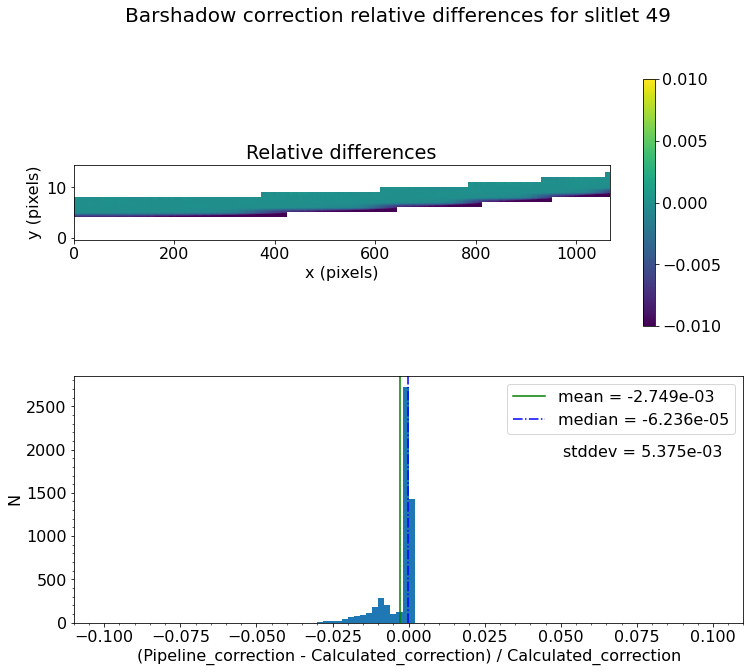


   Relative barshadow_correction  :   mean = -2.749e-03    median = -6.236e-05    stdev = 5.375e-03
    Maximum   Relativebarshadow_correction = 1.177e-03
    Minimum   Relativebarshadow_correction = -2.815e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 8%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 49? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  50
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Calculation of barshadow correction done.
525.6815486602569 26.89982581835418
Creating final barshadow test plot...


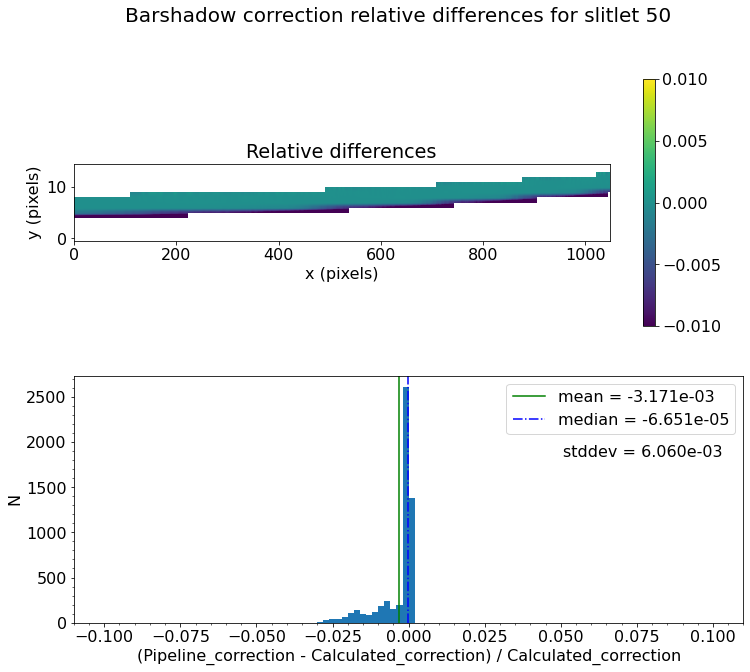


   Relative barshadow_correction  :   mean = -3.171e-03    median = -6.651e-05    stdev = 6.060e-03
    Maximum   Relativebarshadow_correction = 1.648e-03
    Minimum   Relativebarshadow_correction = -2.837e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 26%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 11%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 50? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  51
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Referenc

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Calculation of barshadow correction done.
518.2363133126122 26.906766488227944
Creating final barshadow test plot...


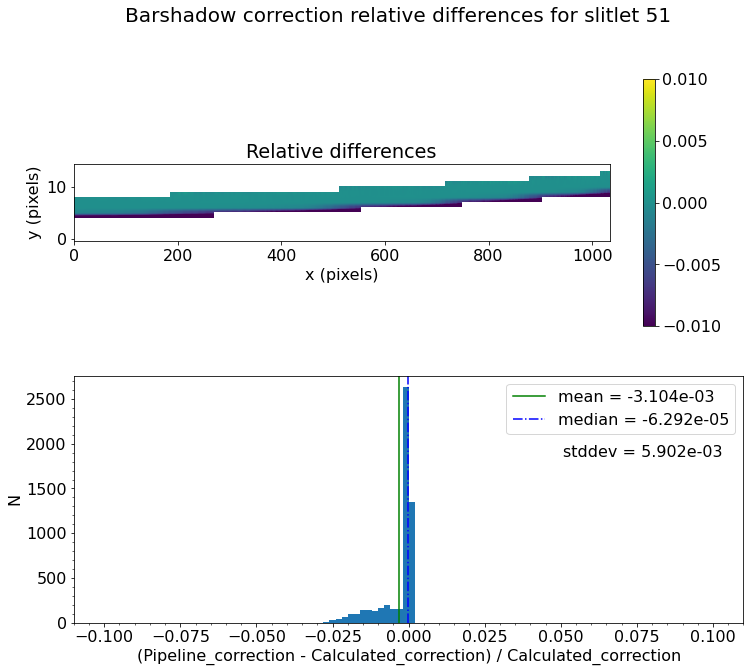


   Relative barshadow_correction  :   mean = -3.104e-03    median = -6.292e-05    stdev = 5.902e-03
    Maximum   Relativebarshadow_correction = 1.358e-03
    Minimum   Relativebarshadow_correction = -2.734e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 11%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 51? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED

Working with slitlet  52
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Referenc

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Calculation of barshadow correction done.
507.37795245035966 26.908367350122248
Creating final barshadow test plot...


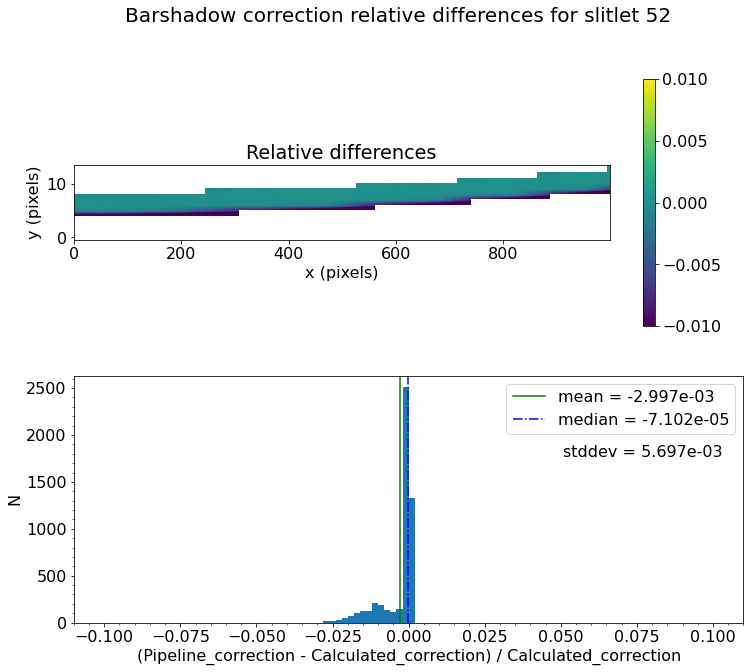


   Relative barshadow_correction  :   mean = -2.997e-03    median = -7.102e-05    stdev = 5.697e-03
    Maximum   Relativebarshadow_correction = 1.044e-03
    Minimum   Relativebarshadow_correction = -2.715e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 25%
                            ->  3xtheshold = 19%
                            ->  5xtheshold = 10%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 52? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  55
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibratio

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


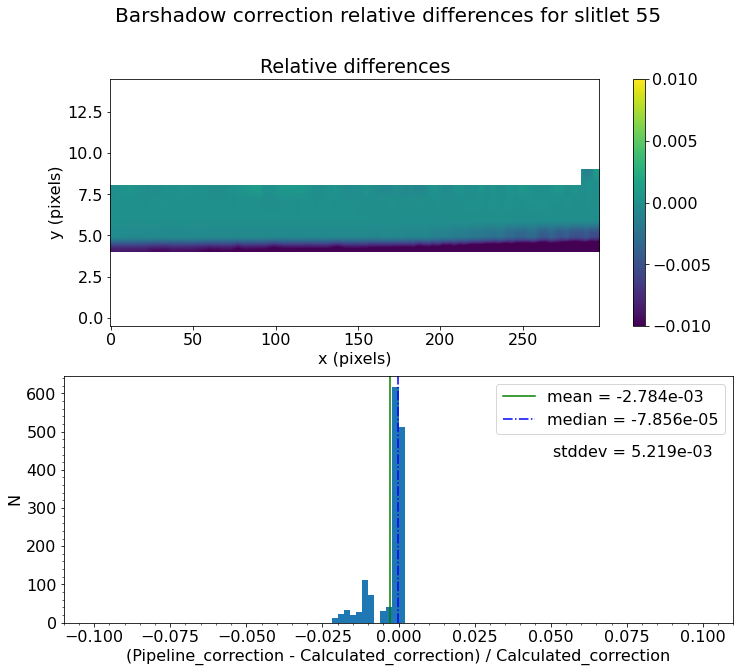


   Relative barshadow_correction  :   mean = -2.784e-03    median = -7.856e-05    stdev = 5.219e-03
    Maximum   Relativebarshadow_correction = 1.028e-03
    Minimum   Relativebarshadow_correction = -2.143e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 24%
                            ->  3xtheshold = 20%
                            ->  5xtheshold = 7%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 55? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  56
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


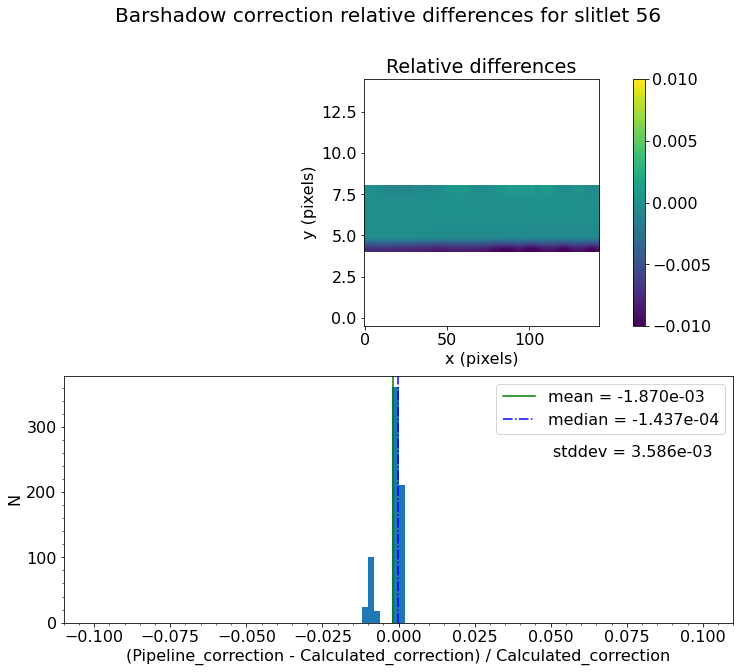


   Relative barshadow_correction  :   mean = -1.870e-03    median = -1.437e-04    stdev = 3.586e-03
    Maximum   Relativebarshadow_correction = 1.258e-03
    Minimum   Relativebarshadow_correction = -1.043e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 20%
                            ->  3xtheshold = 20%
                            ->  5xtheshold = 0%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 56? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: PASSED

Working with slitlet  57
Slitlet name in fits file previous to barshadow and in barshadow output file are the same.
Calculating barshadow correction...
Reference file used for barshadow calculation: /grp/jwst/wit4/nirspec/CDP3/05_Other_Calibration

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

Calculation of barshadow correction done.
nan nan
Creating final barshadow test plot...


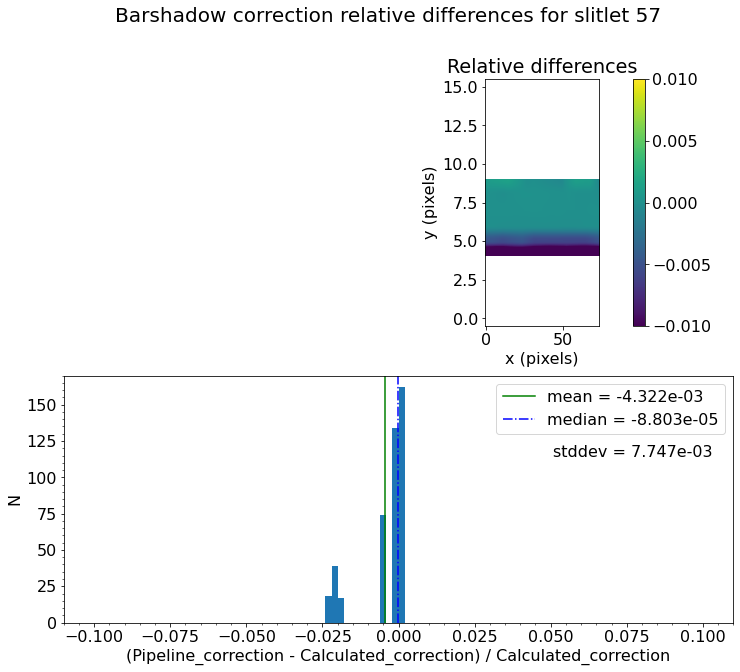


   Relative barshadow_correction  :   mean = -4.322e-03    median = -8.803e-05    stdev = 7.747e-03
    Maximum   Relativebarshadow_correction = 1.475e-03
    Minimum   Relativebarshadow_correction = -2.267e-02
    Percentage of pixels where median of relative differences is greater than: 
                            ->  1xtheshold = 33%
                            ->  3xtheshold = 17%
                            ->  5xtheshold = 17%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 * PASS/FAIL TEST: Is the median <= threshold for slit 57? PASSED

 * Result of number of points greater than 3*threshold greater than 10%: FAILED

 * Result of number of points greater than 5*threshold greater than 10%: FAILED


 * Test of barshadow_correction for slitlet 6  PASSED.

 * Test of barshadow_correction for slitlet 7  PASSED.

 * Test of barshadow_correction for slitlet 8  

/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encounter

In [7]:
# Set common NPTT switches for this test

# accepted threshold difference with respect to benchmark files
barshadow_threshold_diff = 0.0025

# other variables
mode_used = 'MOS'
write_barshadow_files = False
show_final_fig = True
save_final_fig = False
show_intermediary_figs = False
save_intermediary_figs = False

# Get the data
results_dict = {}
detectors = ['nrs1', 'nrs2']
for mode_config, data_set_dict in testing_data.items():
    for det in detectors:
        print('Testing files for detector: ', det)
        data = get_artifactory_file(data_set_dict, det)
        uncal_file, msa_shutter_config = data
        print('Working with uncal_file: ', uncal_file)
        uncal_basename = os.path.basename(uncal_file)
        
        # Run the stage 1 pipeline 
        rate_object = Detector1Pipeline.call(uncal_file)
        # Make sure the MSA shutter configuration file is set up correctly
        if msa_shutter_config is not None:
            msa_metadata = rate_object.meta.instrument.msa_metadata_file
            if msa_metadata is None or msa_metadata == 'N/A':
                rate_object.meta.instrument.msa_metadata_file = msa_shutter_config

        # Run the stage 2 pipeline steps
        try:
            pipe_object = AssignWcsStep.call(rate_object)
            skip_file = False
        except:
            print('No open slits fall on detector ', det, '\n')
            skip_file = True
            
        if not skip_file: 
            pipe_object = MSAFlagOpenStep.call(pipe_object)
            pipe_object = Extract2dStep.call(pipe_object)
            pipe_object = SourceTypeStep.call(pipe_object)
            pipe_object = WavecorrStep.call(pipe_object)
            pipe_object = FlatFieldStep.call(pipe_object, save_interpolated_flat=False)
            pathloss_object = PathLossStep.call(pipe_object)
            barshadow_object = BarShadowStep.call(pathloss_object)

            # Run the validation test
            %matplotlib inline

            result, _, _ = nptt.calwebb_spec2_pytests.auxiliary_code.barshadow_testing.run_barshadow_tests(
                                                                pathloss_object, 
                                                                barshadow_object,
                                                                barshadow_threshold_diff=barshadow_threshold_diff,
                                                                save_final_figs=save_final_fig,
                                                                show_final_figs=show_final_fig,
                                                                save_intermediary_figs=save_intermediary_figs,
                                                                show_intermediary_figs=show_intermediary_figs,
                                                                write_barshadow_files=write_barshadow_files)

        else:
            result = 'skipped'

        # Did the test passed 
        print("Did barshadow validation test passed? ", result, "\n\n")
        rd = {uncal_basename: result}
        results_dict.update(rd)
        
        # close all open files
        psutil.Process().open_files()
        closing_files = []
        for fd in psutil.Process().open_files():
            if data_dir.name in fd.path:
                closing_files.append(fd)
        for fd in closing_files:
            try:
                print('Closing file: ', fd)
                open(fd.fd).close()
            except:
                print('File already closed: ', fd)
            

In [8]:
# Quickly see if the test passed 

print('These are the final results of the tests: ')
for key, val in results_dict.items():
    print(key, val)

These are the final results of the tests: 
mos_prism_nrs1_uncal.fits True
mos_prism_nrs2_uncal.fits skipped
mos_g140m_line1_NRS1_uncal.fits True
mos_g140m_line1_NRS2_uncal.fits True


<a id="about_ID"></a>
## About this Notebook
**Author:** Maria A. Pena-Guerrero, Staff Scientist II - Systems Science Support, NIRSpec
<br>**Updated On:** April/9/2021

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 